In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Authors: Davy SIMEU, Romin DURAND, Joyce TCHAMDJOU**

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/ia304 
%ls

/content/drive/MyDrive/Colab Notebooks/ia304
binaryalphadigs.mat


# Import des librairies

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Récupération des données

## Utilitaires / Routines

In [ ]:
def char_to_index(char):
  ascii = ord(char)
  if 48<=ascii<=57: # 0, 1, ..., 9
    return ascii-48
  elif 65<=ascii<=90: # A, B, ..., Z
    return ascii-65+10
  elif 97<=ascii<=122: # a, b, ..., z
    return ascii-97 + 10
  else:
    print('Error: {} is not a digit or a letter'.format(char))
    return -1

def index_to_char(index):
  if 0<=index<=9: # Digits
    return str(index)
  elif 10<=index<=35: # Letters
    return str(chr(index-10+65))

def plot_random_sample_of_each_char(X, n_sample_per_char=39, 
                                    height=20, width=16, ncol=3):
  n, _ = X.shape
  if n%n_sample_per_char != 0:
    print('Warning: first dimension of X should be ' \
          + 'a multiple of n_sample_per_char={}'.format(n_sample_per_char))
    
  n_char = n//n_sample_per_char
  nrow = n_char//ncol + int(n_char%ncol>0)
  fig, axs = plt.subplots(nrow, ncol)
  for i in range(nrow*ncol):
    if nrow==1:
      ax = axs[i%ncol]
    else :
      ax = axs[i//ncol,i%ncol]

    if i<n_char:
      rand_ind = np.random.randint(i*n_sample_per_char, (i+1)*n_sample_per_char)
      rand_char = X[rand_ind]
      img = rand_char.reshape(height, width)
      ax.matshow(img)
      ax.axis('off')
    else:
      fig.delaxes(ax)

  fig.show()

Dans cette partie, on implémente la fonction ``lire_alpha_digit`` permettant de récupérer les données souhaitées au bon format.

In [ ]:
def lire_alpha_digit(file_name, characters, 
                     n_sample_per_char=39, height=20, width=16):
  f = scipy.io.loadmat('binaryalphadigs.mat')
  data = f['dat']

  char_indices = [char_to_index(char) for char in characters if char_to_index(char)!=-1]
  char_indices = np.unique(char_indices)

  N_char = len(char_indices)
  n = n_sample_per_char*N_char
  p = height*width 

  X = np.zeros((n,p))
  for i, idx in enumerate(char_indices):
    for j in range(n_sample_per_char):
      k = i*n_sample_per_char + j
      line = data[idx, j].flatten()
      X[k] = line

  return X

## Exemple de chargement de données

shape of X: (234, 320)


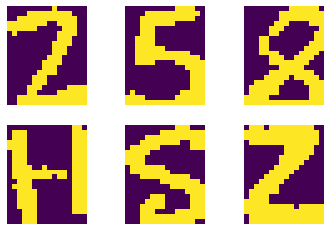

In [ ]:
X = lire_alpha_digit('binaryalphadigs.mat', '258SHZ')
print('shape of X: {}'.format(X.shape))
plot_random_sample_of_each_char(X)

# Création de la classe RBM

In [32]:
class RBM():
  def __init__(self, p, q, var=1e-2):
    self.a = np.zeros(p)
    self.b = np.zeros(q)
    self.W = np.random.normal(0, 1, size=(p,q))*np.sqrt(var)
    self.q = q
  
  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def entree_sortie(self, X):
    return self.sigmoid(X @ self.W + self.b)

  def sortie_entree(self, H):
    return self.sigmoid(H @ self.W.T + self.a)

  def train(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
    
    n, p = X.shape
    err_history = []
    for epoch in range(nb_epoch):
      np.random.shuffle(X)  
      if verbose:
        print('\n##### Epoch: {}/{} #####'.format(epoch, nb_epoch))
      for batch in range(0, n, batch_size):
        if verbose:
          print('\r>>> samples {:d}/{:d} [{:.0f}%]'.format(batch+1, n, 
                                                  (batch+1)/n*100), end='')
        X_batch = X[batch:min(batch+batch_size, n)]
        current_bs = X_batch.shape[0]

        # Calcul de v_0, v_1, p(v|h) et p(h|v)
        v_0 = X_batch 
        ph_v_0 = self.entree_sortie(v_0) 
        h_0 = (np.random.random((current_bs, self.q)) < ph_v_0).astype(int) 
        pv_h_0 = self.sortie_entree(h_0) 
        v_1 = (np.random.random((current_bs, p)) < pv_h_0).astype(int) 
        ph_v_1 = self.entree_sortie(v_1) 

        # Calcul du gradient (des dérivées partielles)
        grad_a = np.sum(v_0 - v_1, axis=0) 
        grad_b = np.sum(ph_v_0 - ph_v_1, axis=0) 
        grad_W = v_0.T @ ph_v_0 - v_1.T @ ph_v_1

        # Mise à jour des paramètres
        self.W += lr/current_bs * grad_W
        self.a += lr/current_bs * grad_a
        self.b += lr/current_bs * grad_b

      H = self.entree_sortie(X)
      X_rec = self.sortie_entree(H)

      if epoch % epoch_per_plot == 0 and verbose:
        rand_idx = np.random.randint(n)
        original_img = X[rand_idx].reshape(height, width)
        reconstructed_img = X_rec[rand_idx].reshape(height, width)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,2))
        ax1.imshow(original_img)
        ax1.set_title("Original")
        ax2.imshow(reconstructed_img)
        ax2.set_title("Reconstructed")
        fig.suptitle("Epoch: {}".format(epoch))
        plt.tight_layout()
        plt.show()

      err = np.mean((X-X_rec)**2)
      err_history.append(err)
      if verbose:
        print('\n>>> MSE: {}'.format(err))
      
    return err_history

  def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
    p, q = self.W.shape
    nb_images = nrow*ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8))

    for i in range(nb_images):
      v = (np.random.random(p) < thresh).astype(int)
      for j in range(nb_iter):
        ph_v = self.entree_sortie(v) 
        h = (np.random.random(q) < ph_v).astype(int)
        pv_h = self.sortie_entree(h)
        v = (np.random.random(p) < pv_h).astype(int)

      image = v.reshape(height,width)
      axs[i//ncol, i%ncol].imshow(image)
      axs[i//ncol, i%ncol].axis('off')
    plt.tight_layout()
    plt.show()

# Utilisation du modèle et analyse
Nous pouvons maintenant entrainer le modèle et étudier son comportement

320

##### Epoch: 0/1000 #####
>>> samples 66/78 [85%]

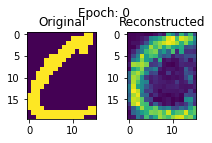


>>> MSE: 0.1465697657241318

##### Epoch: 1/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.13120205540552501

##### Epoch: 2/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.11658492436297567

##### Epoch: 3/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.10724715859040361

##### Epoch: 4/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.10056814979742179

##### Epoch: 5/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.09429138046834729

##### Epoch: 6/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0904449761625853

##### Epoch: 7/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.08362722151796541

##### Epoch: 8/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.08027095683871392

##### Epoch: 9/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.07579502307733824

##### Epoch: 10/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.07237228481836831

##### Epoch: 11/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.06966546212804074

##### Epoch: 12/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.06677425051846937

##### Ep

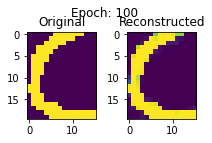


>>> MSE: 0.003436383547724013

##### Epoch: 101/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0033346258120832

##### Epoch: 102/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0032418566464146284

##### Epoch: 103/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0031370484223215297

##### Epoch: 104/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003181947029810588

##### Epoch: 105/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.003055935826396409

##### Epoch: 106/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.002867017094861556

##### Epoch: 107/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0028731518827078643

##### Epoch: 108/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0028910230246662672

##### Epoch: 109/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0026735519108509556

##### Epoch: 110/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0027061407122278757

##### Epoch: 111/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.002645230771496096

##### Epoch: 112/1000 #####
>>> samples 66/78 [85%]

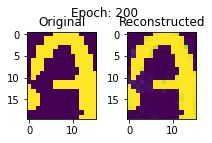


>>> MSE: 0.0006912082026886919

##### Epoch: 201/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006755737085232464

##### Epoch: 202/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006634235316557053

##### Epoch: 203/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006384602776653832

##### Epoch: 204/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0006170619717246036

##### Epoch: 205/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000604427457989329

##### Epoch: 206/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000593772187046666

##### Epoch: 207/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0005985240433464496

##### Epoch: 208/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0005948140254781985

##### Epoch: 209/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0005788113262169082

##### Epoch: 210/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0005961471011180518

##### Epoch: 211/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0005952654728775115

##### Epoch: 212/1000 #####
>>> samples 66/78

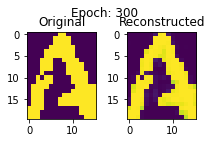


>>> MSE: 0.0002730596131854948

##### Epoch: 301/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002752775666103335

##### Epoch: 302/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002746242334239246

##### Epoch: 303/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00027707329392068225

##### Epoch: 304/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00028278088035718987

##### Epoch: 305/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002831043824734098

##### Epoch: 306/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000283080975473913

##### Epoch: 307/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000268396963818389

##### Epoch: 308/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002665139075798539

##### Epoch: 309/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00026529445186244065

##### Epoch: 310/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0002599775804782897

##### Epoch: 311/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.000260156755732862

##### Epoch: 312/1000 #####
>>> samples 66/

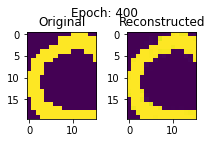


>>> MSE: 0.00014433859762238372

##### Epoch: 401/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014477758294613108

##### Epoch: 402/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014541632324369054

##### Epoch: 403/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014417878452915671

##### Epoch: 404/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014560821609713515

##### Epoch: 405/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00014714747610364377

##### Epoch: 406/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0001427201896372851

##### Epoch: 407/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00013832393262518122

##### Epoch: 408/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00013871606706446685

##### Epoch: 409/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00013547284074116994

##### Epoch: 410/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.00013727808234574286

##### Epoch: 411/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 0.0001381324384810793

##### Epoch: 412/1000 #####
>>> s

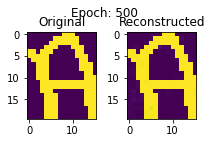


>>> MSE: 9.117103624029513e-05

##### Epoch: 501/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.06453772222738e-05

##### Epoch: 502/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.116917257240315e-05

##### Epoch: 503/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.182938073359562e-05

##### Epoch: 504/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.918142273802292e-05

##### Epoch: 505/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 9.00945733549207e-05

##### Epoch: 506/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.894618638300203e-05

##### Epoch: 507/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.875478879164566e-05

##### Epoch: 508/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.790630762488118e-05

##### Epoch: 509/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.824379558295785e-05

##### Epoch: 510/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.779215882551425e-05

##### Epoch: 511/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 8.782117905270304e-05

##### Epoch: 512/1000 #####
>>> samples 66/78

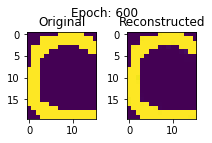


>>> MSE: 6.479383095254051e-05

##### Epoch: 601/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.389895993055843e-05

##### Epoch: 602/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.436762121351783e-05

##### Epoch: 603/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.278079919580715e-05

##### Epoch: 604/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.305599614304449e-05

##### Epoch: 605/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.22188924575211e-05

##### Epoch: 606/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.145745869600366e-05

##### Epoch: 607/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.410154972517658e-05

##### Epoch: 608/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.434018586265712e-05

##### Epoch: 609/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.504005371157862e-05

##### Epoch: 610/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.341166850498347e-05

##### Epoch: 611/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 6.365719163853576e-05

##### Epoch: 612/1000 #####
>>> samples 66/7

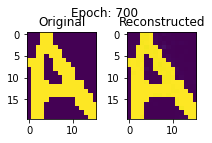


>>> MSE: 4.5510352839440556e-05

##### Epoch: 701/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.569654307866073e-05

##### Epoch: 702/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.601152439711219e-05

##### Epoch: 703/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.606458957221644e-05

##### Epoch: 704/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.758353137905143e-05

##### Epoch: 705/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.654880174059542e-05

##### Epoch: 706/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.7195071094352835e-05

##### Epoch: 707/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.737850871472852e-05

##### Epoch: 708/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.6181798231740686e-05

##### Epoch: 709/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.6131434969587335e-05

##### Epoch: 710/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.504813727799064e-05

##### Epoch: 711/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 4.4523982699390476e-05

##### Epoch: 712/1000 #####
>>> sample

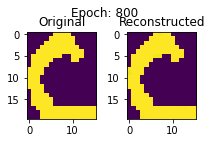


>>> MSE: 3.516635262823051e-05

##### Epoch: 801/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.49602772180694e-05

##### Epoch: 802/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.410420042907831e-05

##### Epoch: 803/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.388082693946892e-05

##### Epoch: 804/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.345449069430162e-05

##### Epoch: 805/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.3457372883173464e-05

##### Epoch: 806/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.3775124455031615e-05

##### Epoch: 807/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.3092120690153354e-05

##### Epoch: 808/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.320187012805676e-05

##### Epoch: 809/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.3117596425549677e-05

##### Epoch: 810/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.270790661954088e-05

##### Epoch: 811/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 3.2634528511930346e-05

##### Epoch: 812/1000 #####
>>> samples

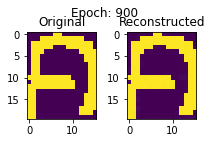


>>> MSE: 2.7175864450546203e-05

##### Epoch: 901/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.714042968164356e-05

##### Epoch: 902/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.7331050011230207e-05

##### Epoch: 903/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6941255369028493e-05

##### Epoch: 904/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.651017070833493e-05

##### Epoch: 905/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6104905796495497e-05

##### Epoch: 906/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6407576918431386e-05

##### Epoch: 907/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.679285592368259e-05

##### Epoch: 908/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6374185705499818e-05

##### Epoch: 909/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6042055584952594e-05

##### Epoch: 910/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6200670303509133e-05

##### Epoch: 911/1000 #####
>>> samples 66/78 [85%]
>>> MSE: 2.6119245814885897e-05

##### Epoch: 912/1000 #####
>>> sa

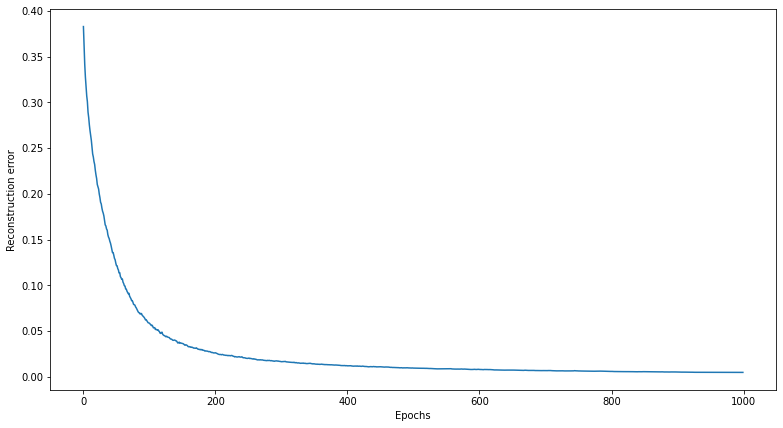

In [40]:
X = lire_alpha_digit('binaryalphadigs.mat', 'AC')
_, p = X.shape
print(p)

my_rbm = RBM(p, q=256)
err_history = my_rbm.train(X, nb_epoch=1000, lr=1e-1, epoch_per_plot=100)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

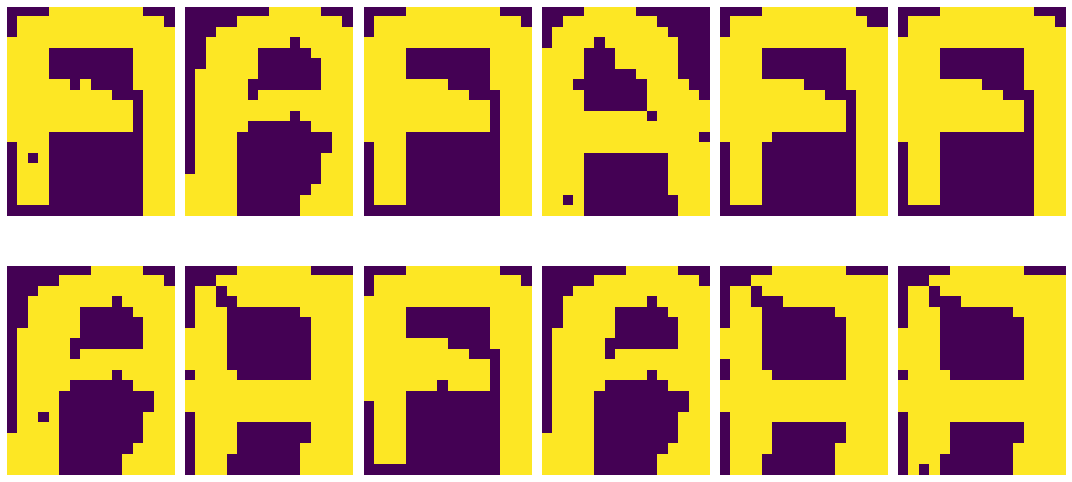

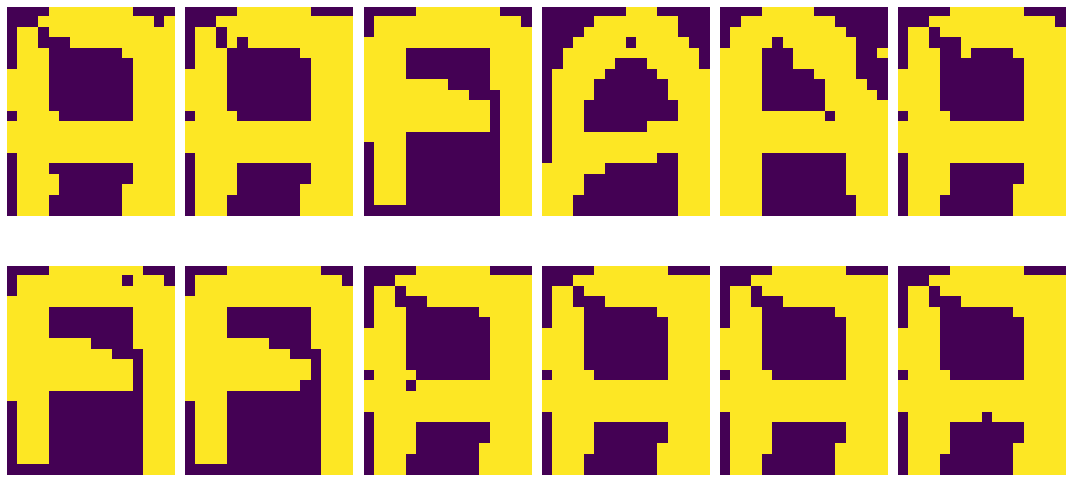

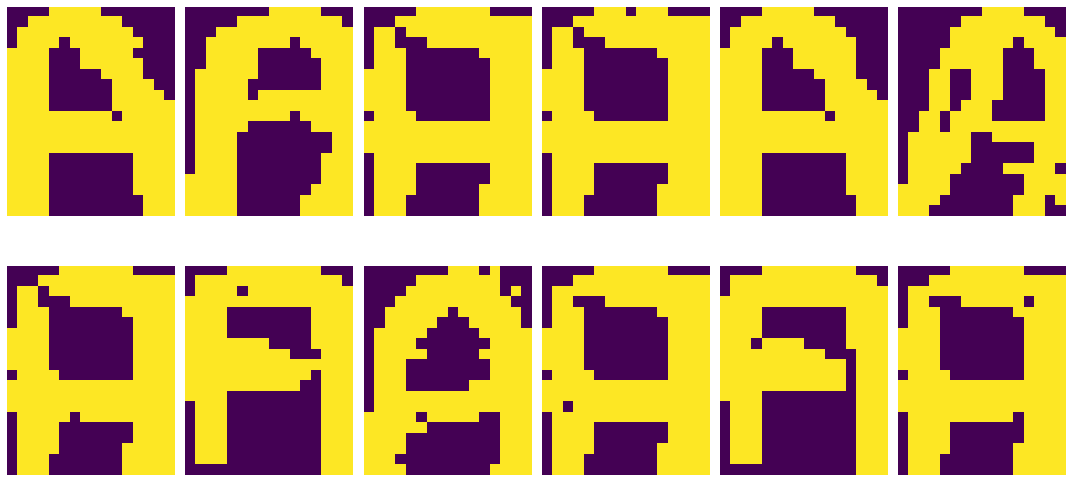

In [11]:
for _ in range(3):
  my_rbm.generate(nb_iter=10, thresh=0.5, ncol=6, nrow=2)

In [12]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 1e-1
lrs = [lr*10, lr, lr/10, lr/100, lr/1000, lr/10000]
err = []
for el in lrs:
  my_rbm = RBM(p, q=256)
  err_history = my_rbm.train(X, nb_epoch=500, lr=el, epoch_per_plot=100, verbose=False)
  err.append(err_history)

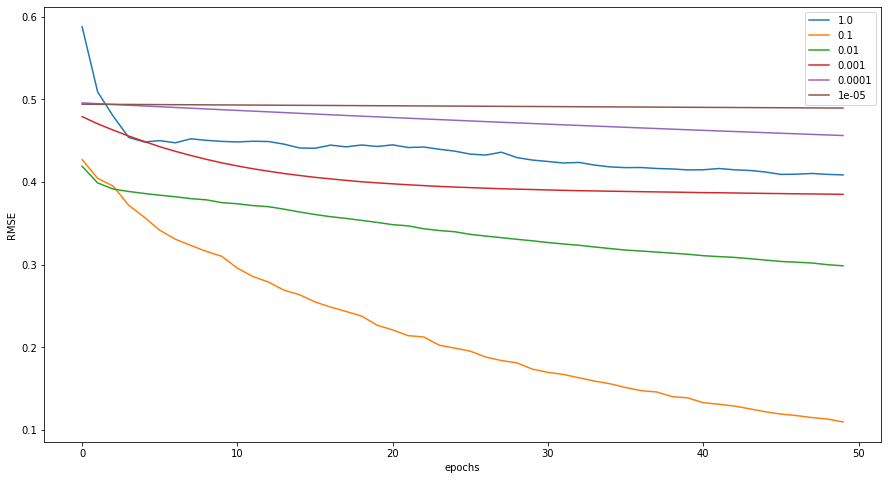

In [13]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err):
  plt.plot(np.sqrt(el[:50]), label=lrs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

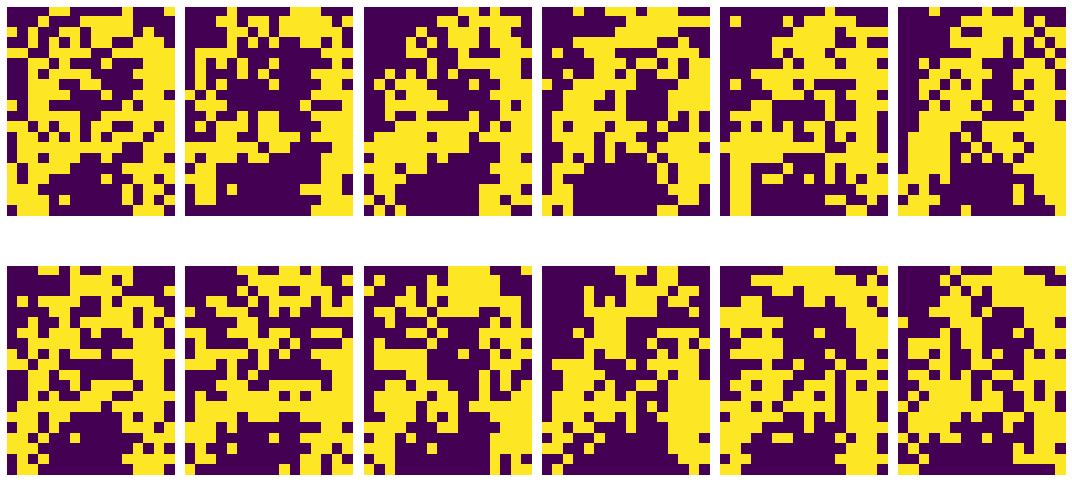

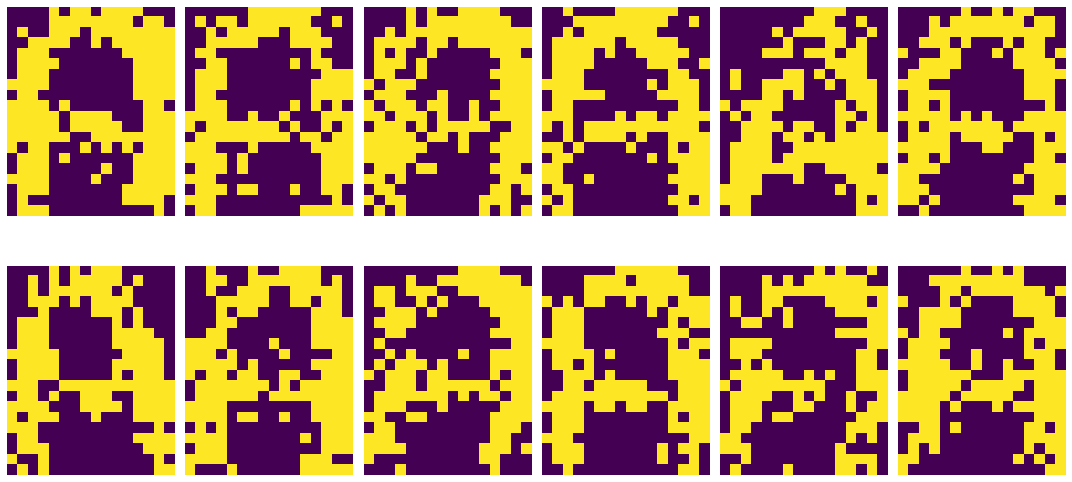

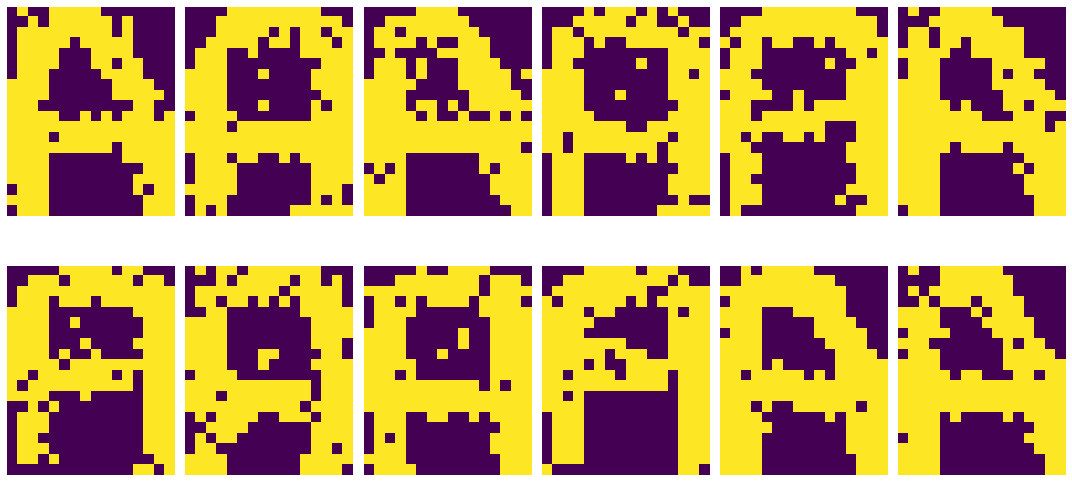

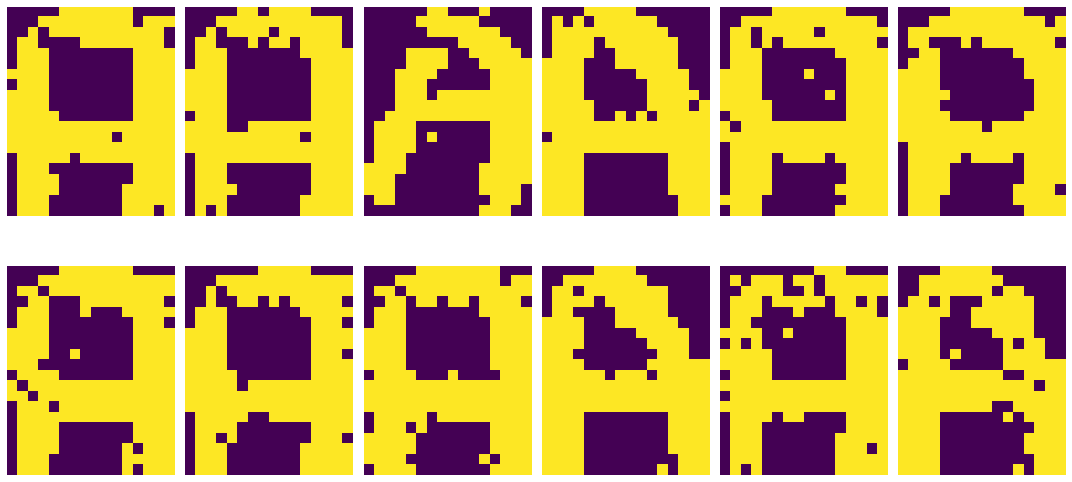

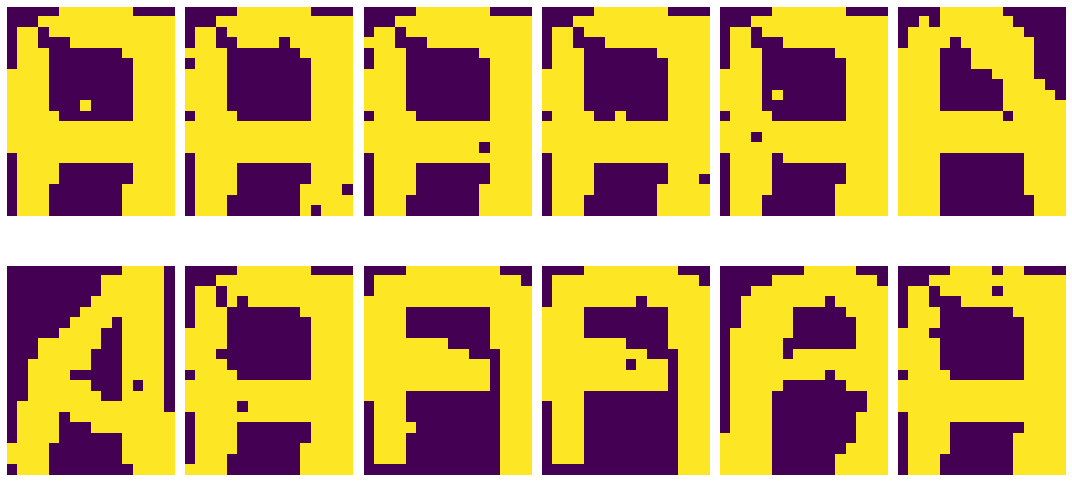

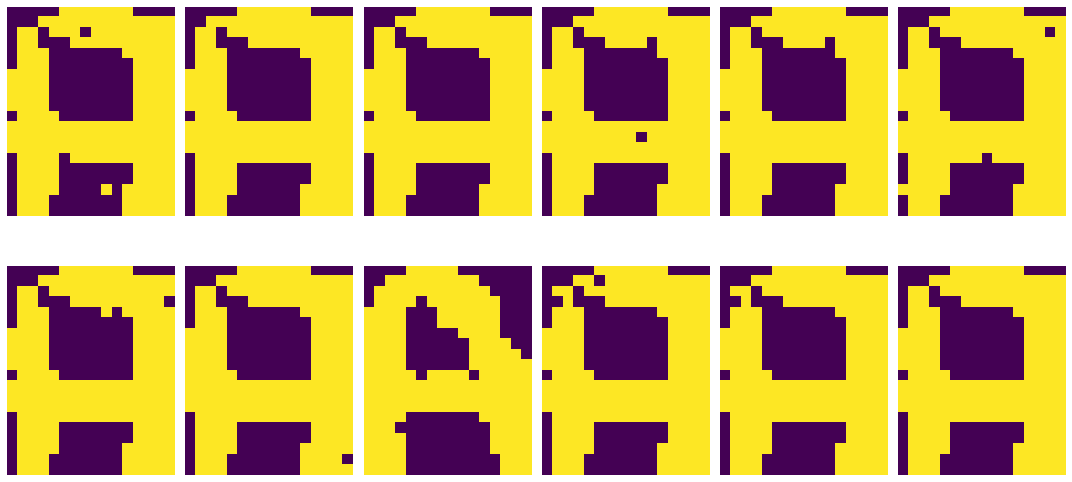

In [14]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 5
epochs = [lr, lr*2, lr*10, lr*20, lr*100, lr*200]
err = []
for el in epochs:
  my_rbm = RBM(p, q=256)
  err_history = my_rbm.train(X, nb_epoch=el, lr=1e-1, epoch_per_plot=100, verbose=False)
  err.append(err_history)
  for _ in range(1):
    my_rbm.generate(nb_iter=10, thresh=0.5, ncol=6, nrow=2)

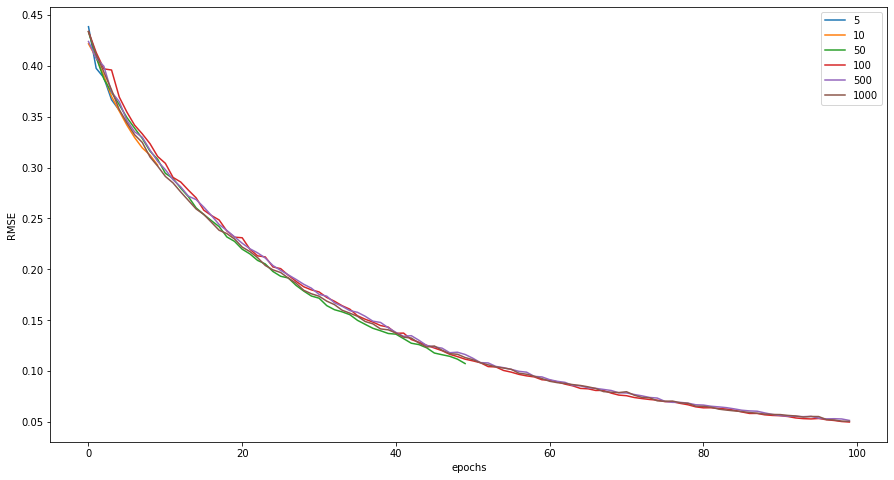

In [15]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err):
  plt.plot(np.sqrt(el[:100]), label=epochs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [16]:
X = lire_alpha_digit('binaryalphadigs.mat', 'A')
_, p = X.shape
lr = 32
Qs = [lr, lr*2, lr*4, lr*8, lr*16, lr*32]
err = []
for el in Qs:
  my_rbm = RBM(p, q=el)
  err_history = my_rbm.train(X, nb_epoch=500, lr=1e-1, epoch_per_plot=100, verbose=False)
  err.append(err_history)

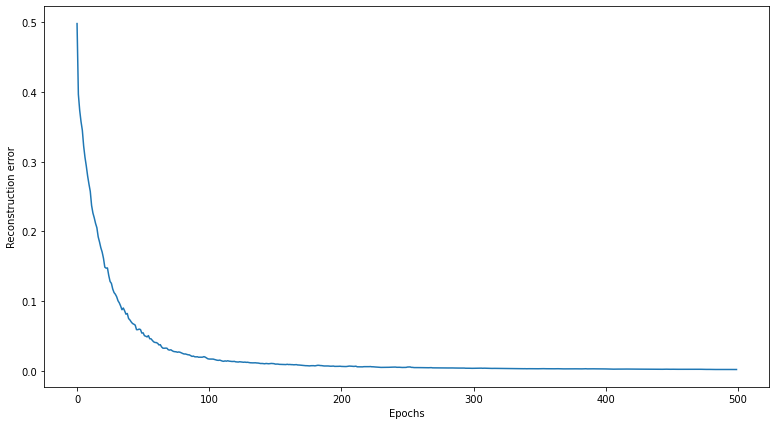

In [17]:
plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

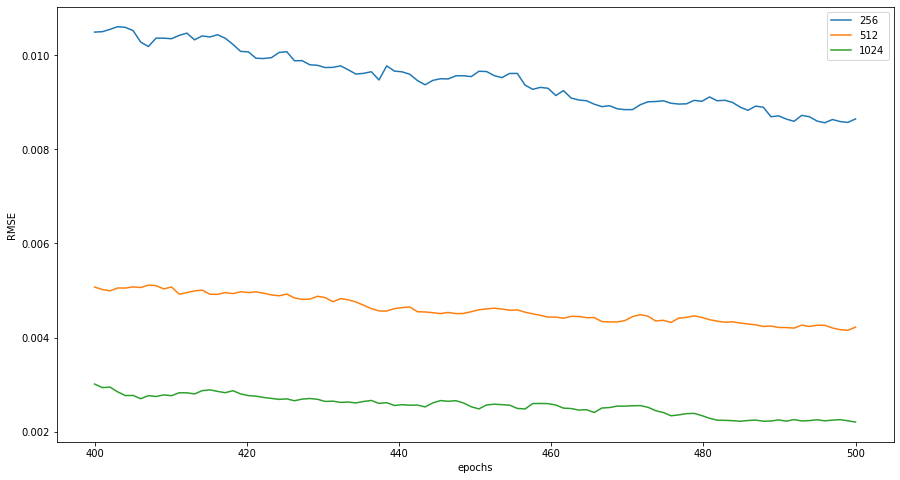

In [18]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err[-3:]):
  plt.plot(np.linspace(400,500,100),np.sqrt(el[400:]), label=Qs[i-3])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

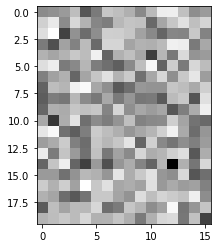

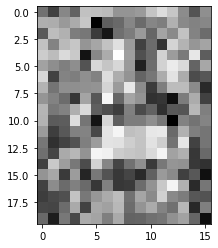

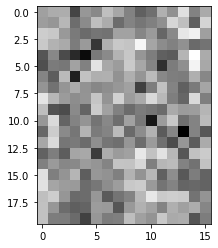

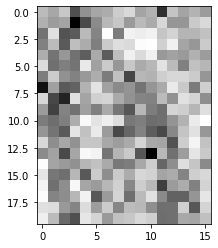

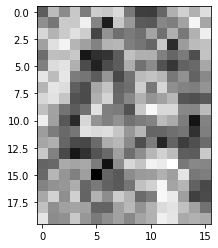

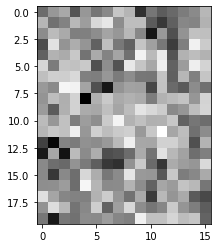

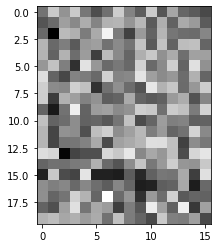

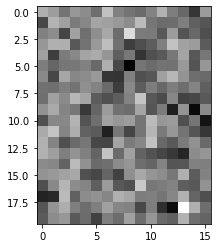

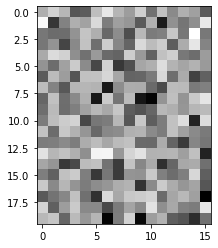

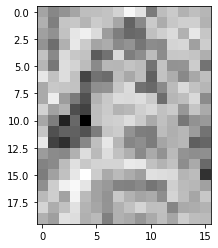

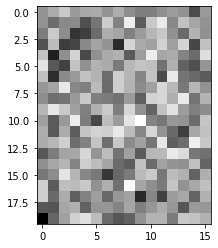

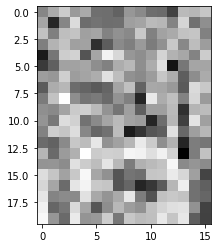

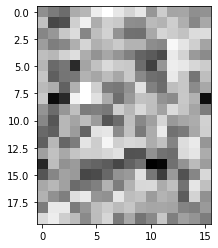

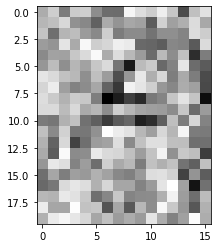

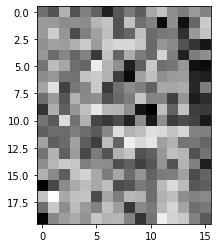

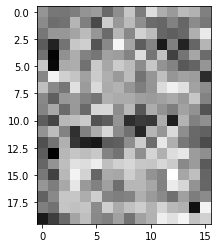

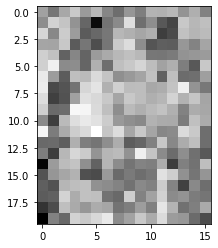

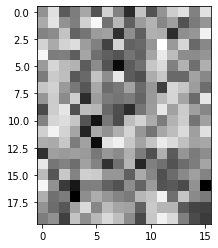

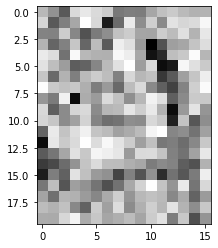

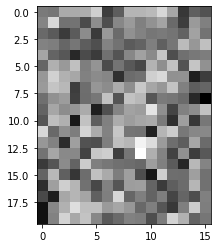

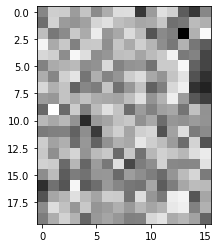

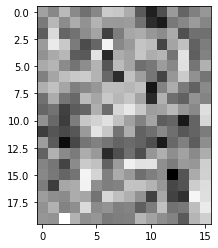

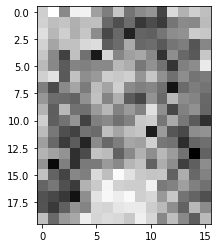

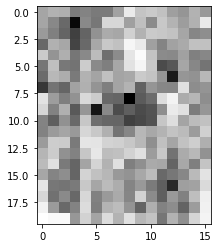

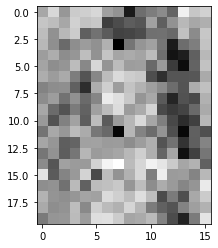

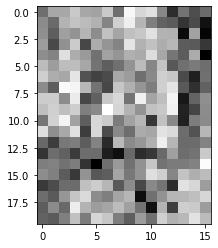

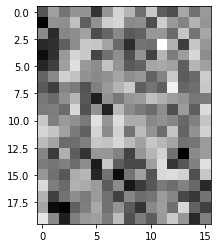

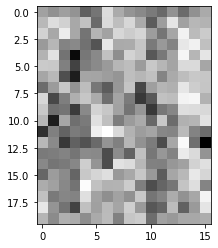

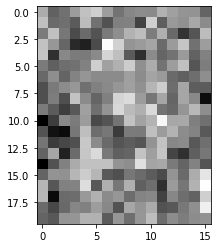

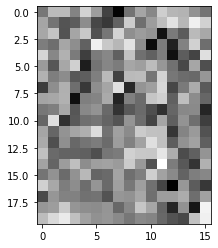

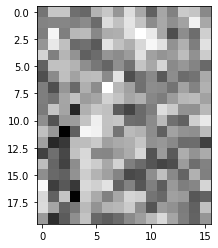

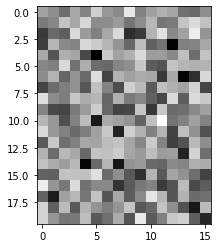

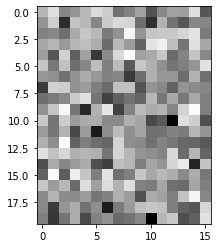

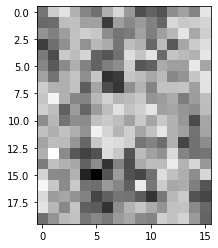

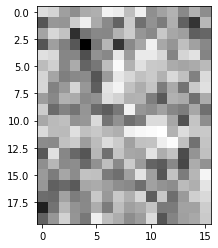

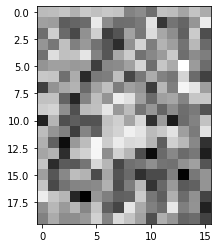

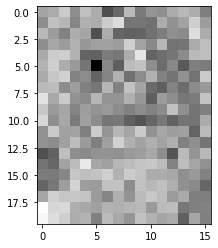

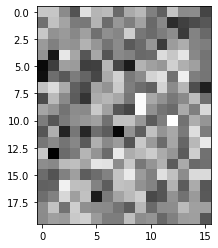

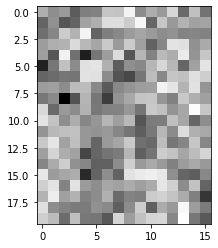

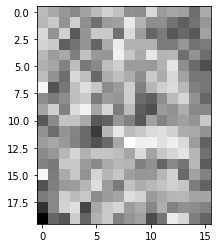

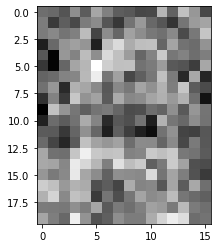

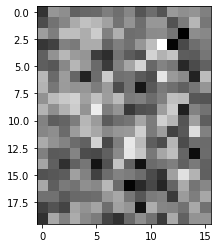

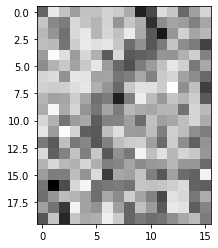

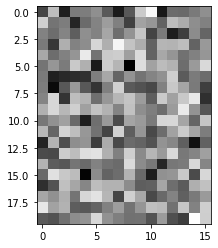

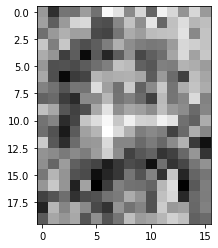

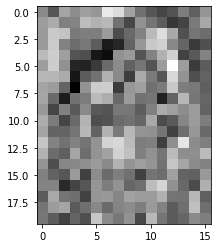

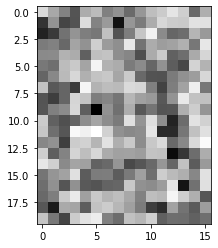

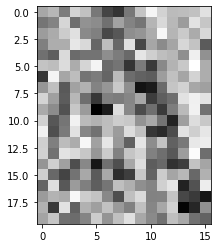

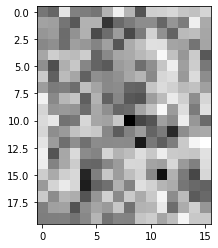

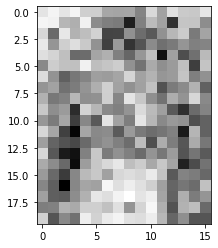

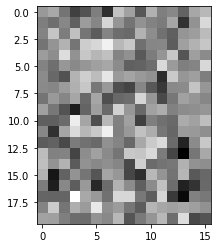

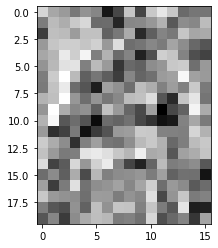

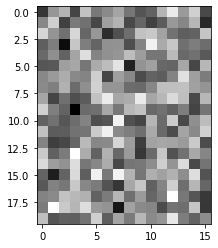

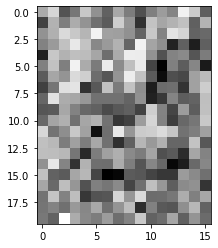

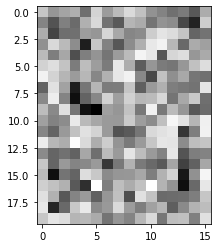

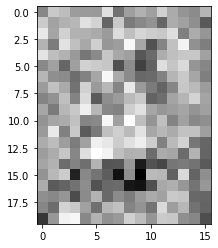

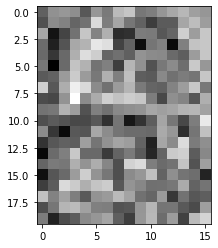

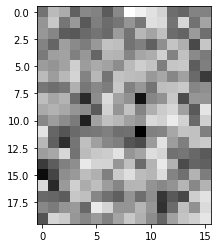

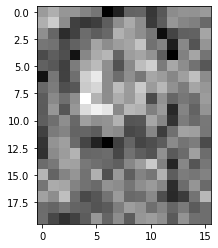

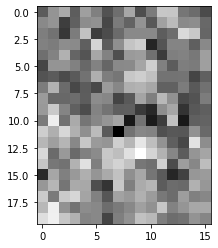

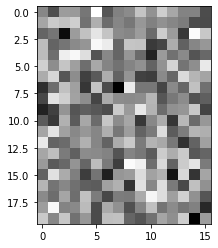

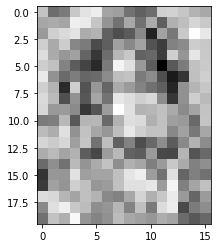

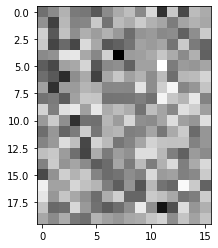

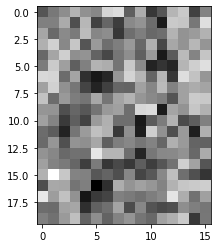

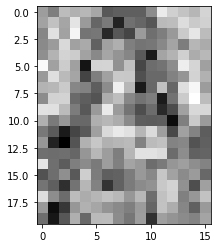

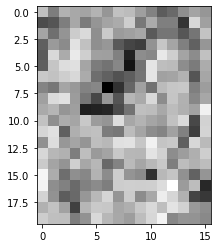

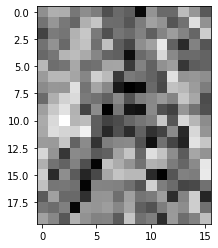

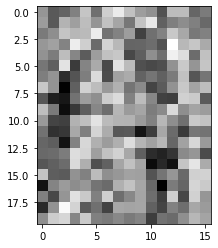

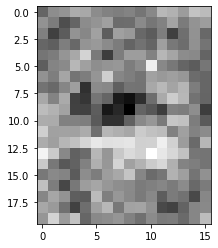

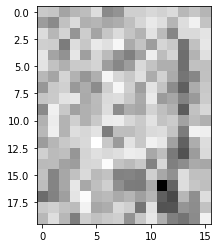

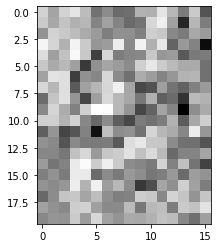

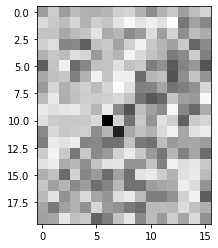

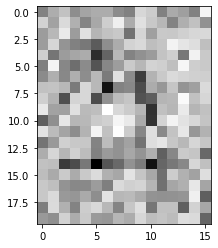

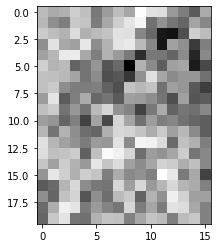

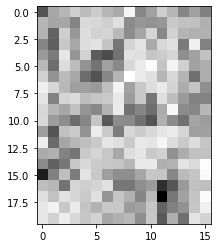

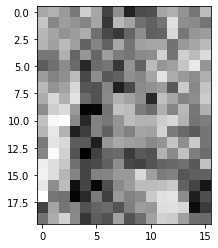

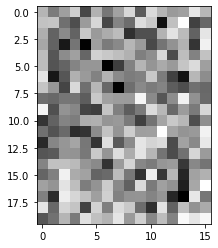

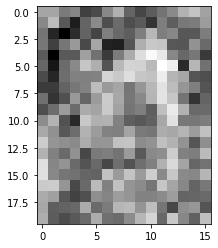

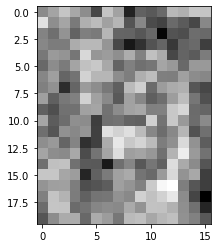

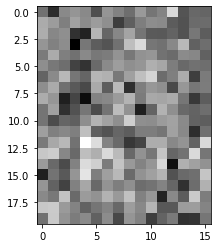

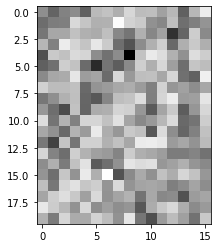

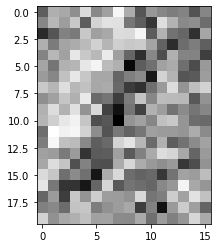

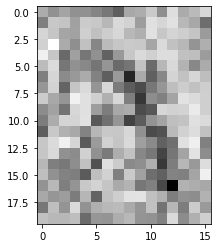

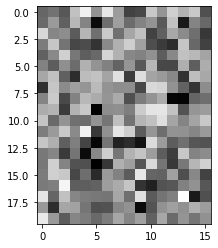

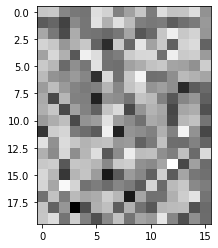

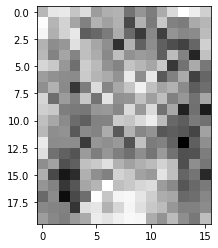

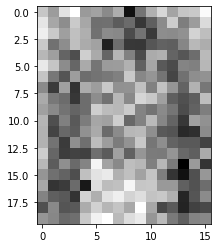

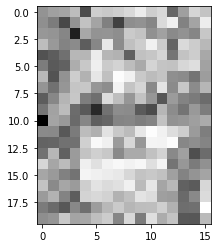

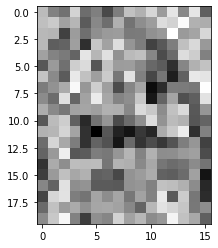

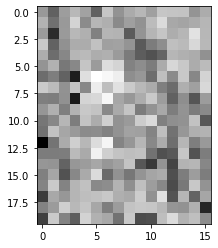

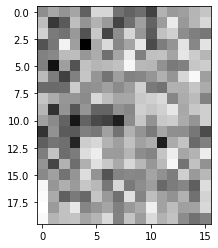

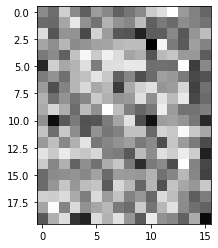

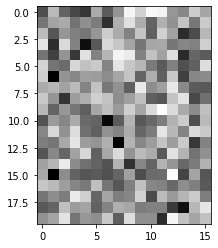

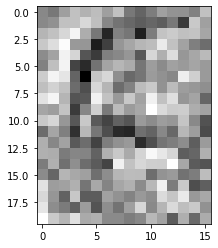

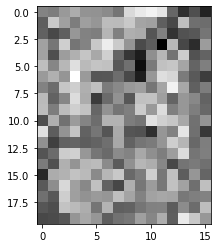

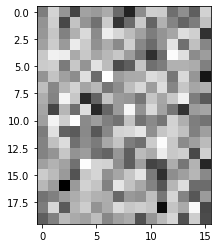

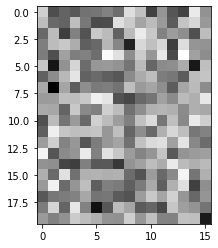

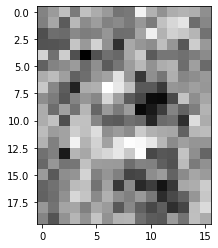

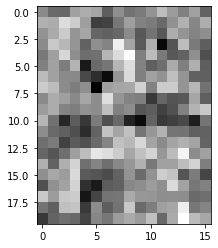

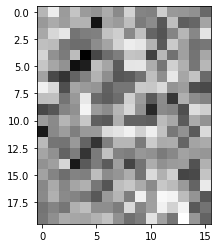

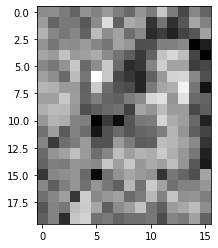

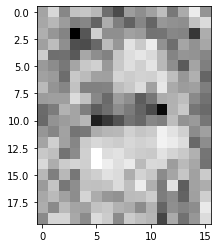

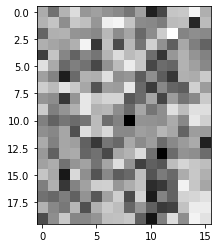

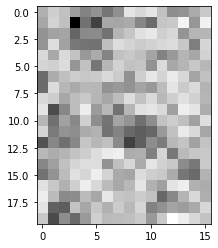

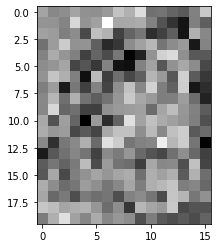

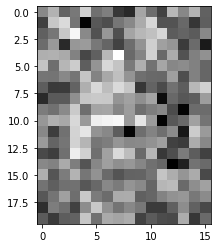

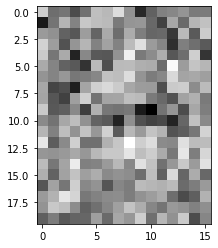

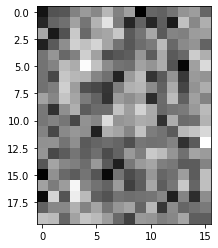

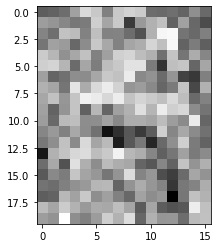

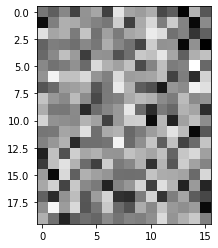

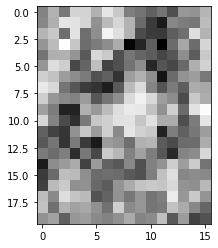

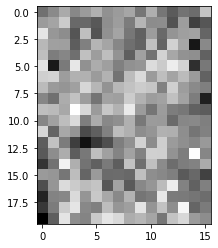

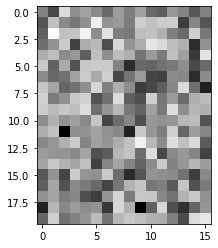

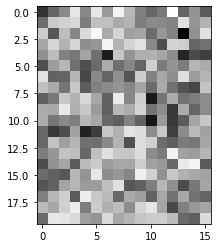

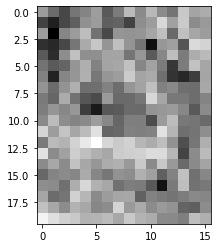

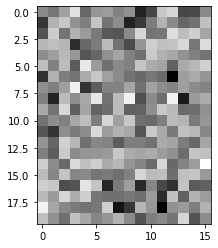

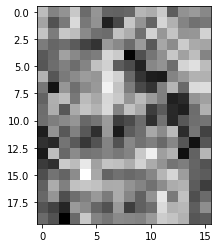

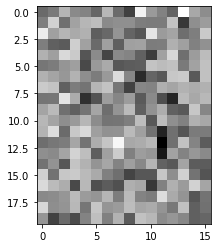

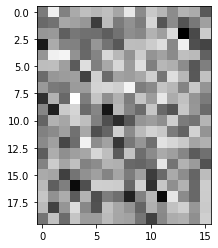

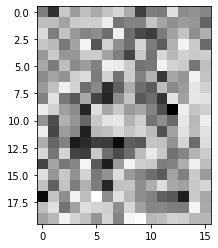

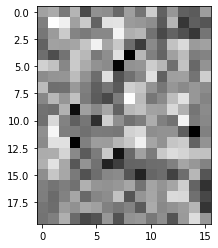

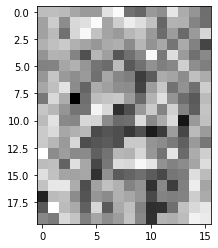

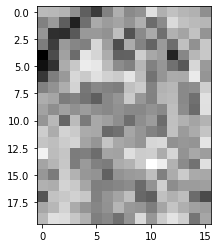

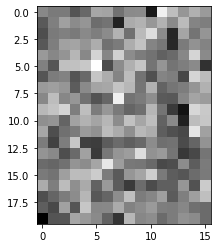

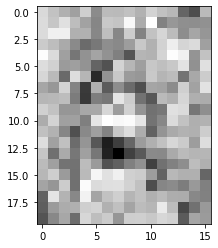

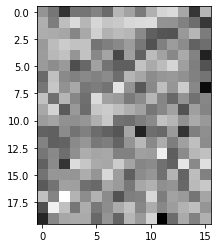

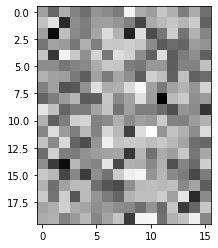

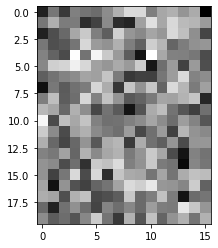

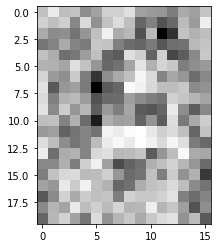

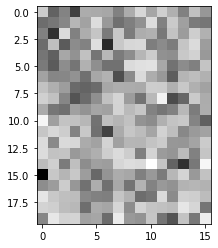

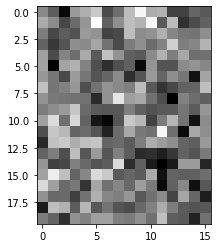

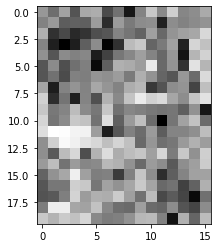

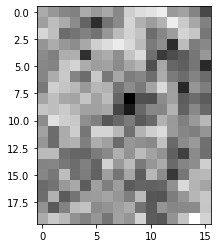

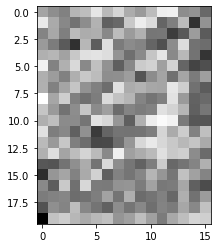

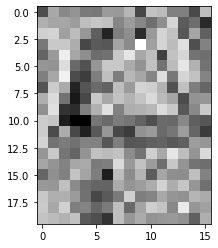

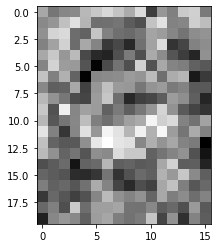

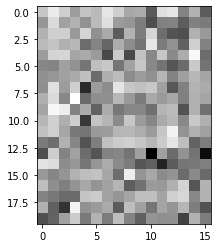

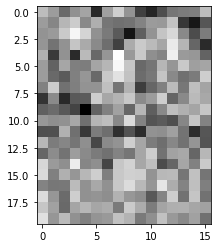

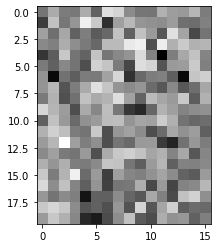

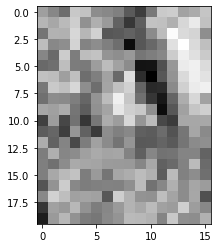

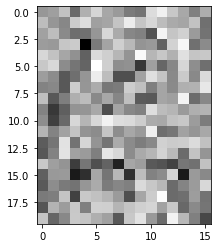

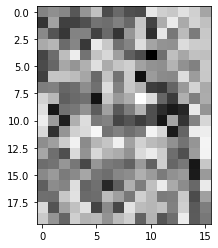

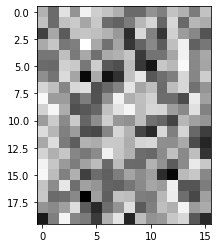

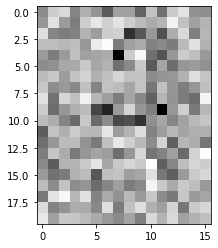

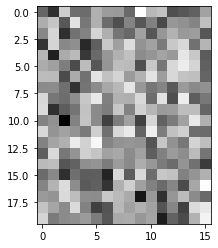

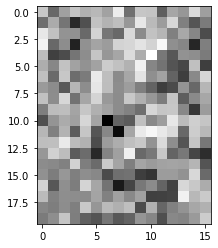

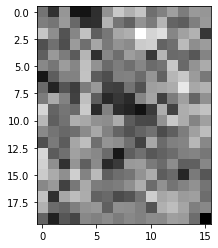

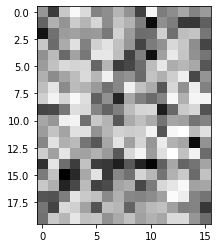

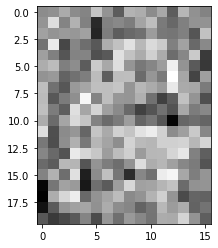

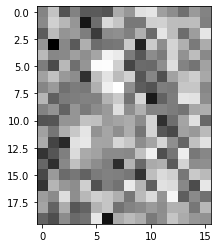

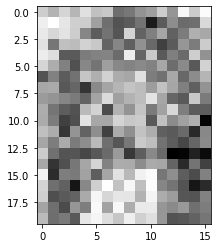

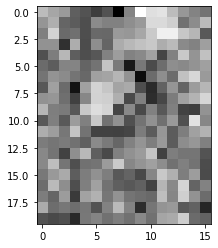

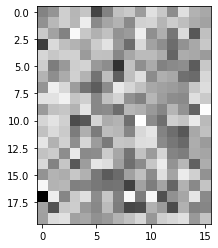

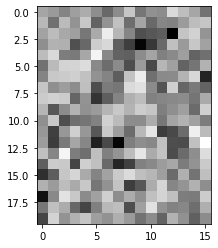

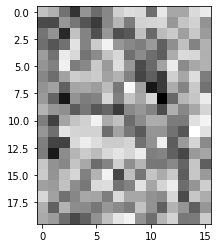

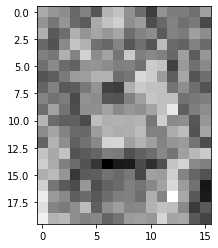

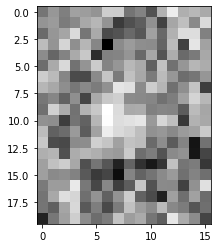

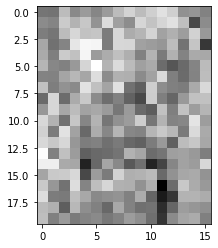

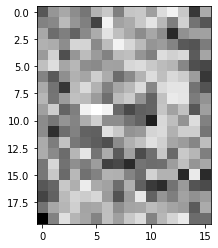

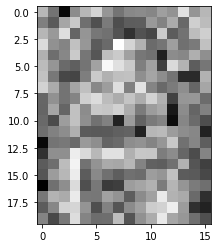

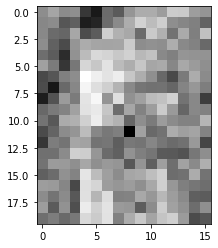

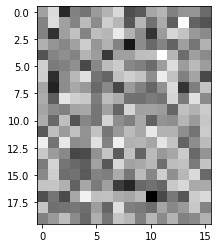

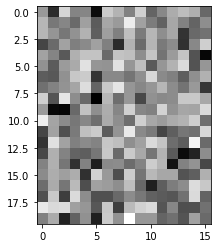

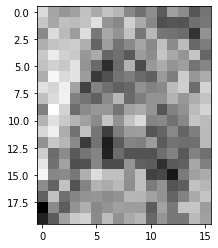

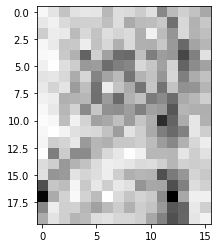

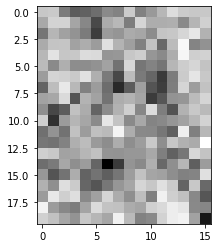

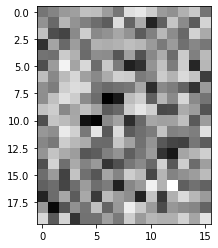

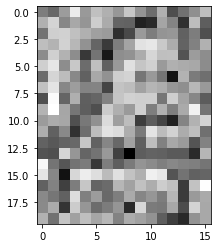

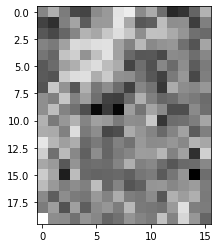

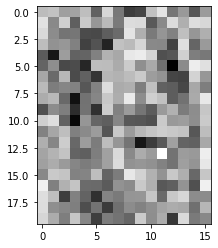

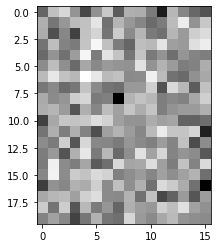

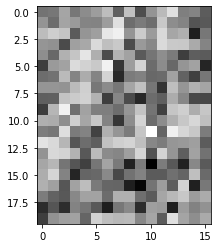

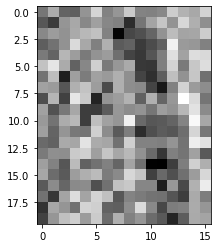

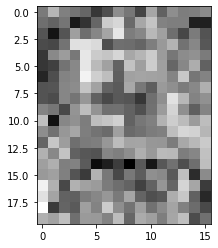

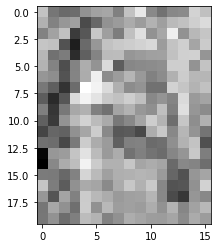

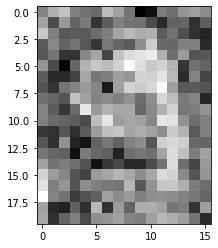

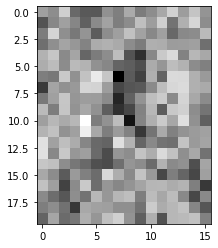

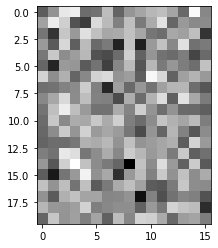

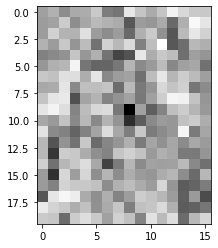

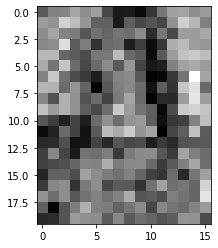

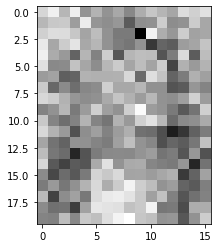

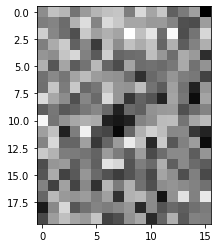

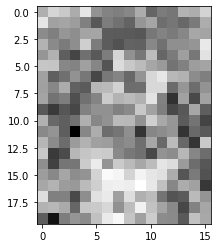

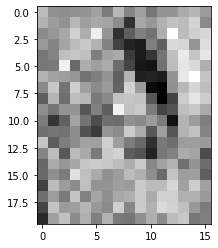

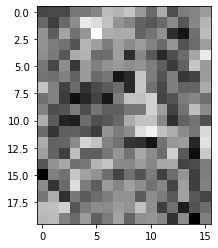

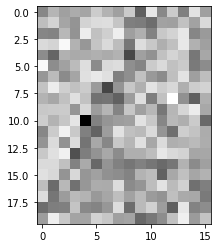

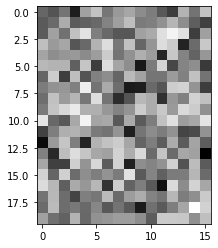

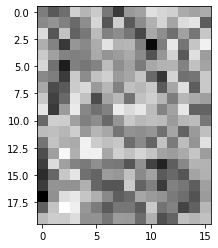

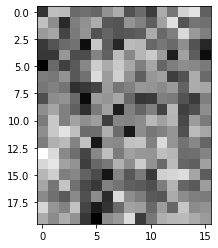

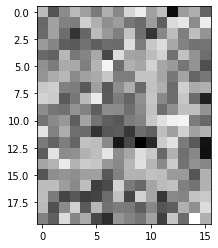

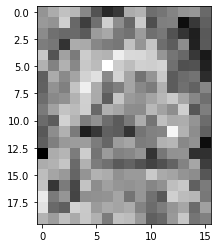

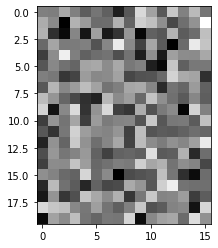

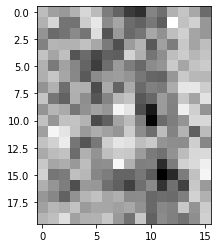

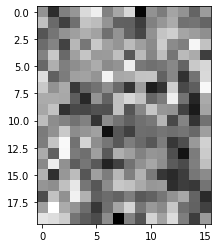

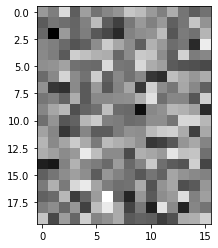

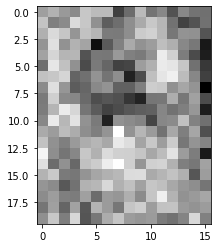

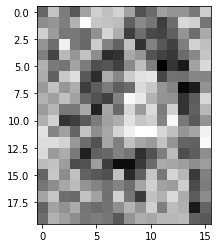

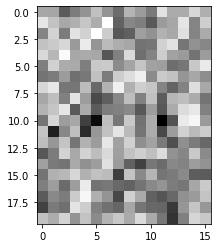

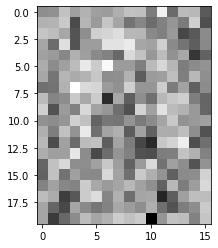

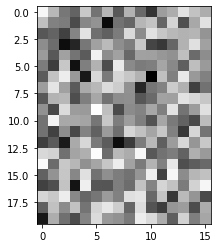

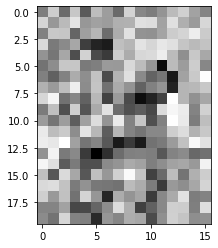

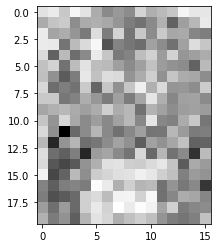

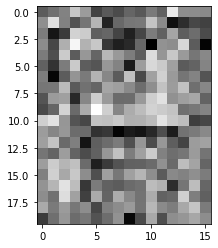

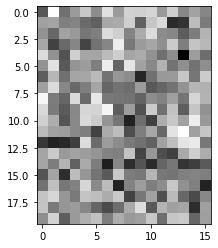

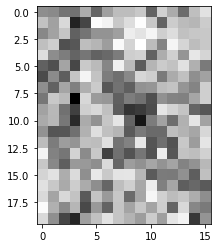

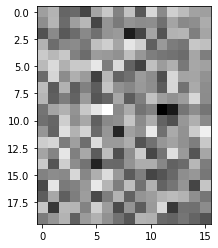

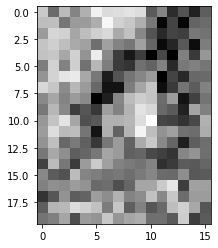

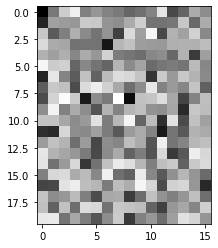

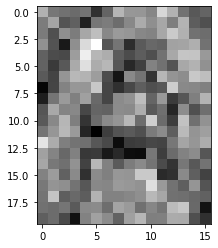

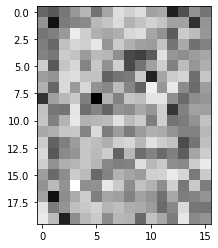

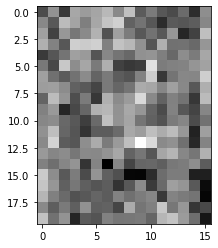

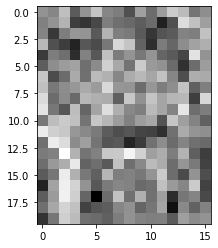

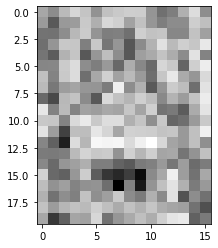

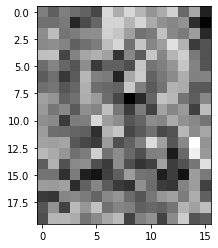

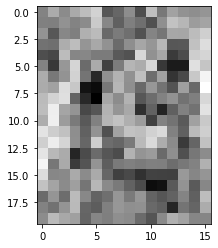

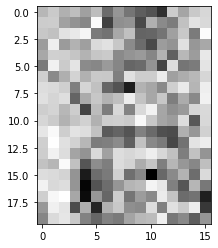

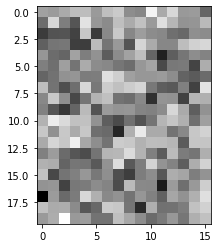

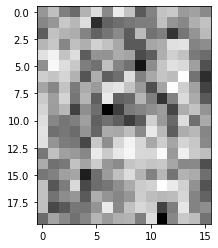

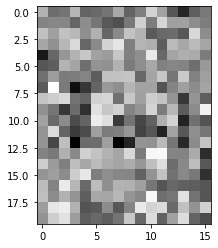

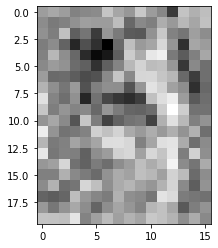

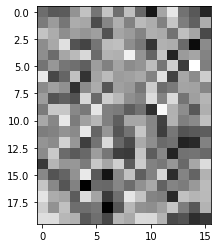

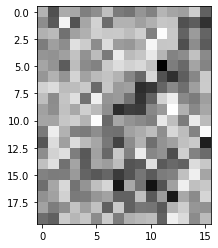

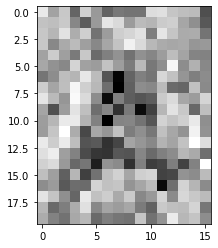

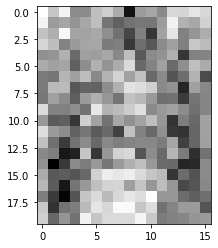

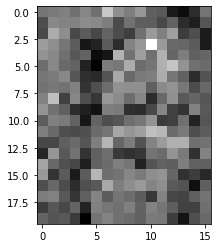

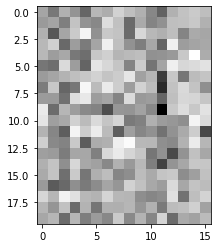

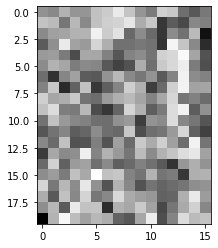

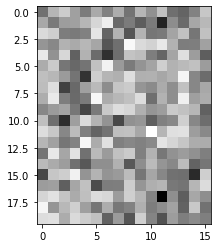

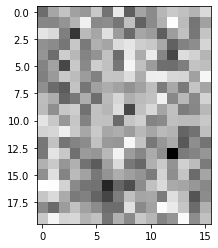

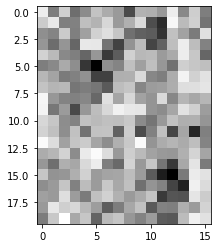

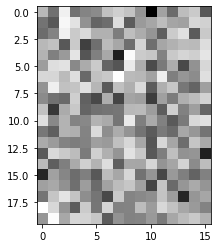

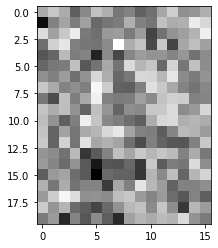

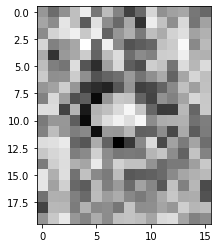

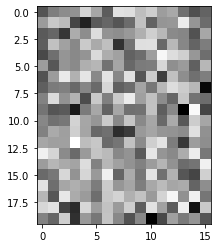

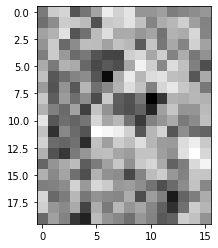

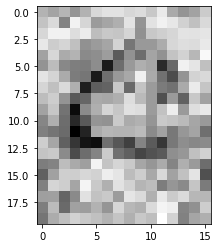

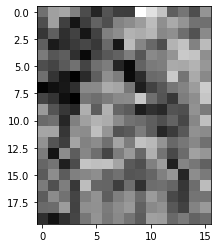

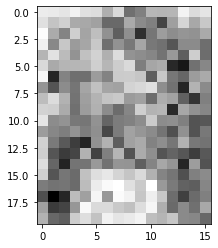

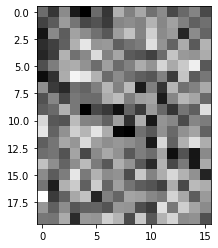

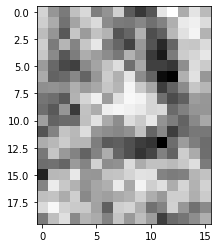

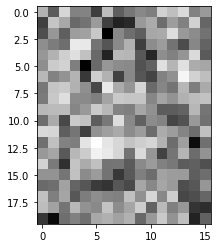

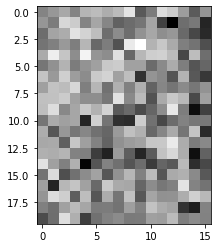

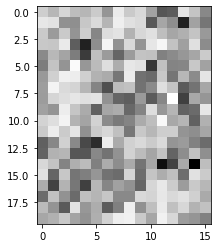

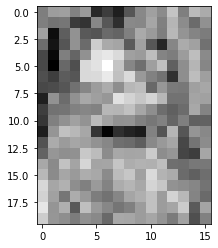

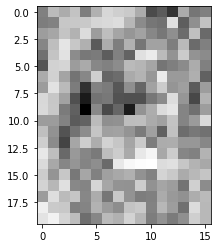

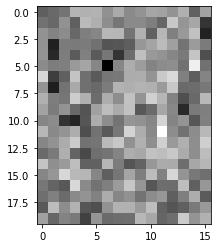

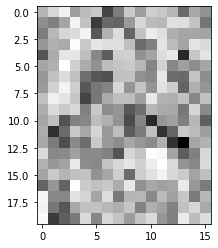

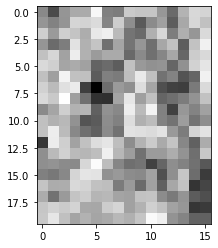

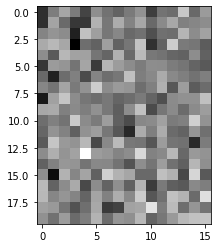

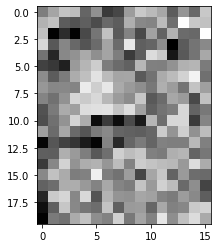

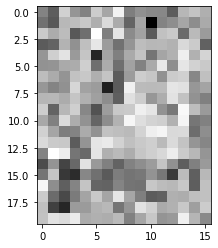

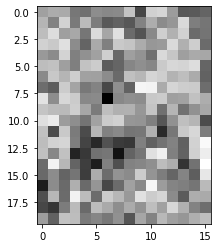

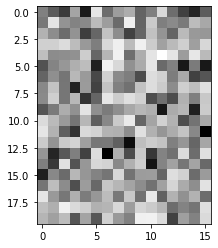

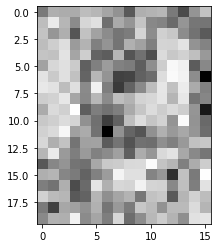

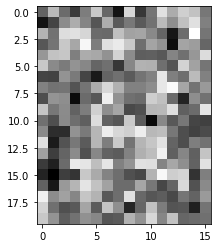

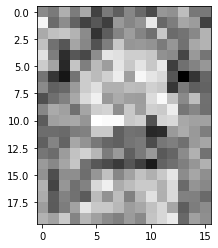

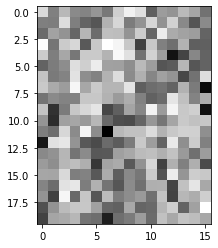

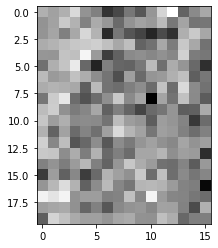

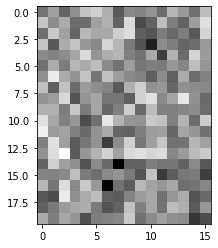

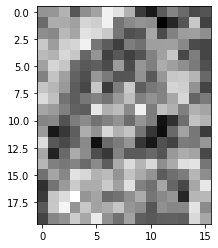

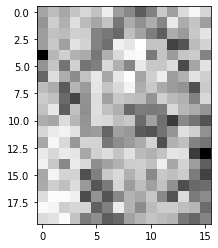

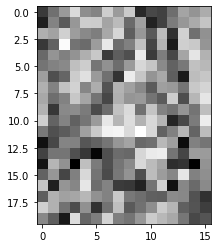

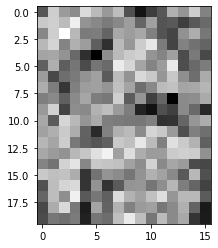

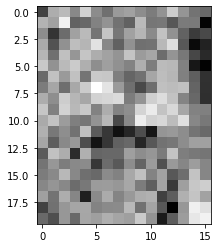

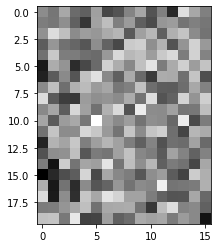

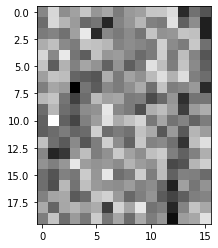

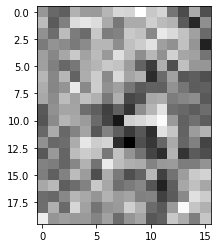

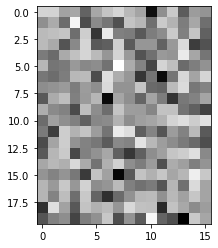

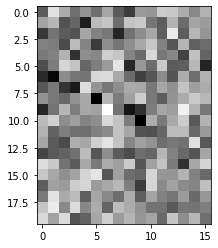

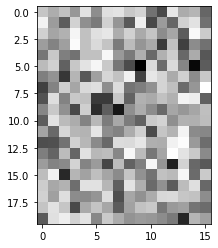

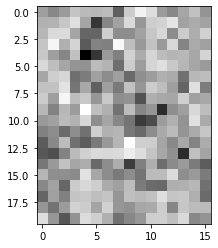

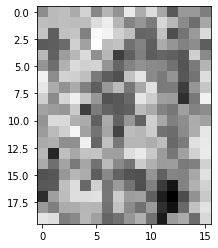

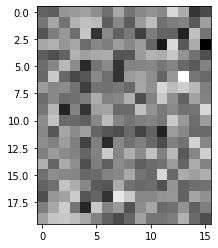

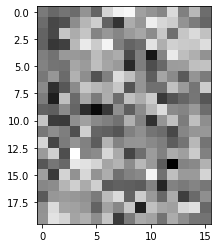

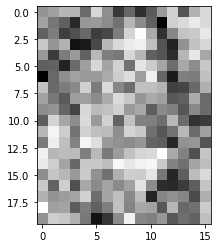

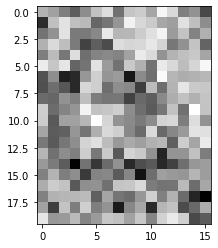

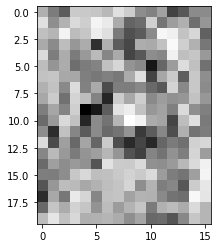

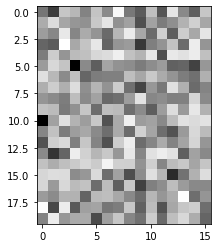

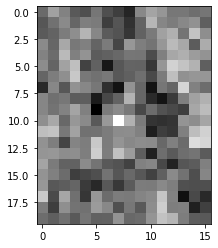

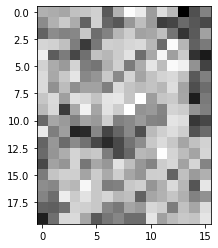

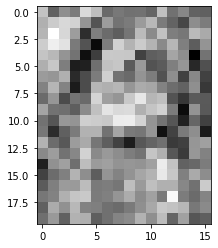

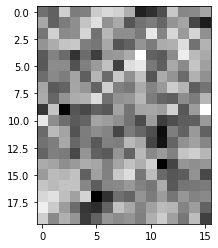

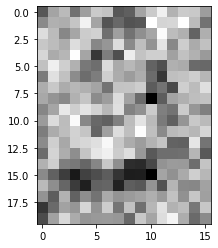

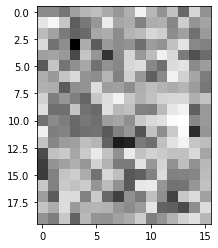

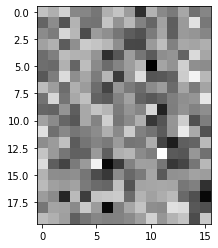

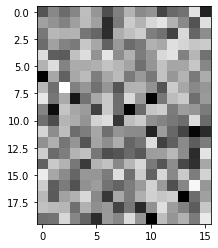

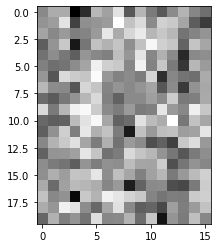

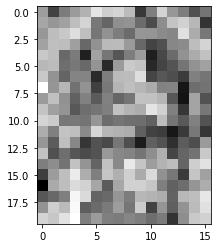

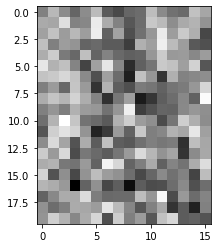

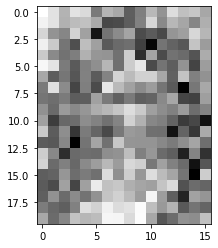

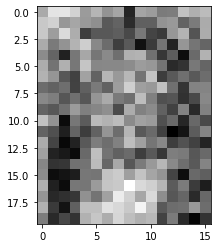

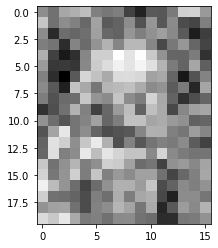

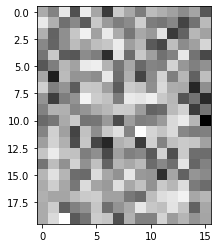

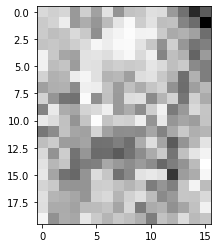

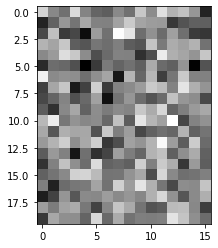

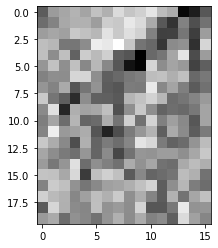

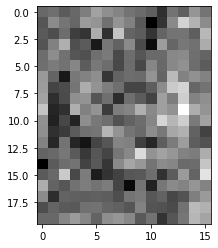

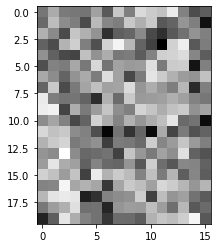

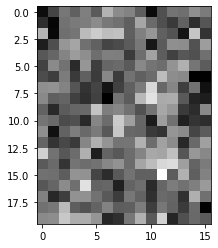

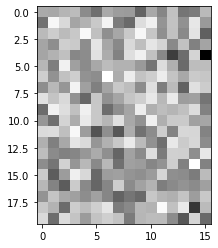

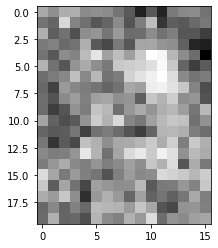

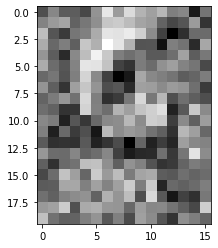

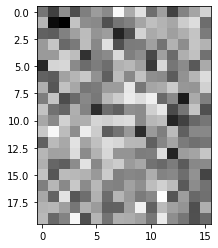

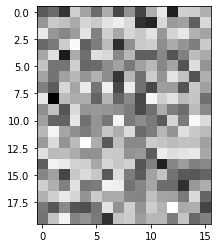

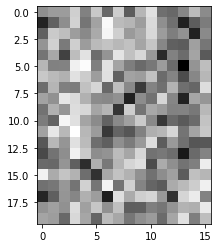

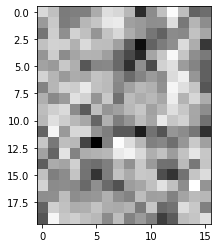

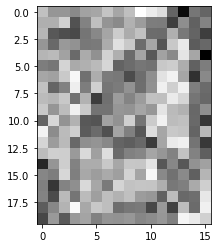

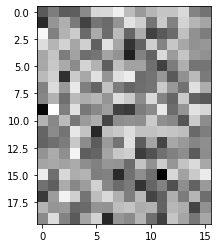

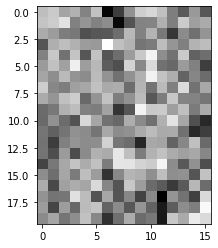

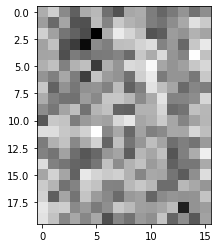

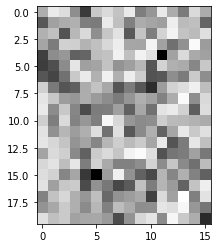

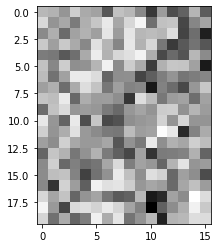

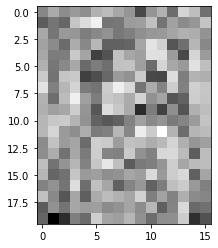

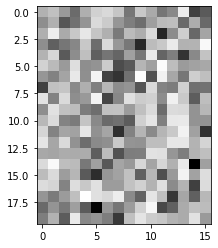

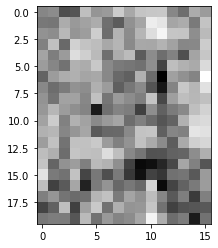

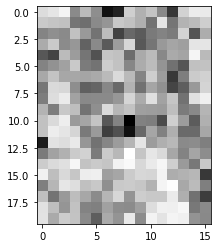

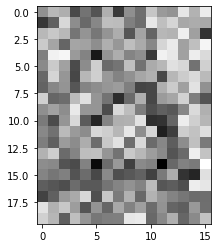

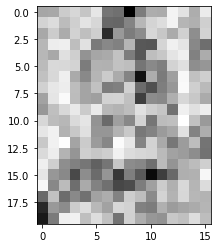

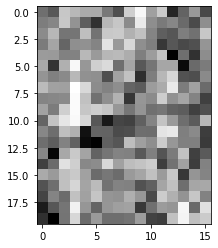

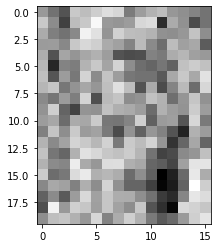

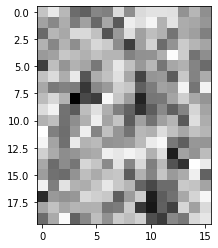

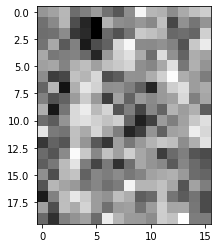

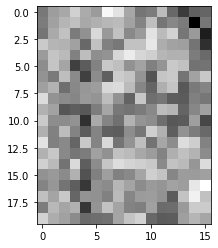

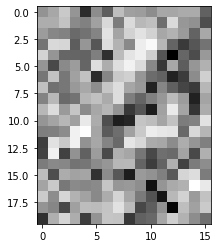

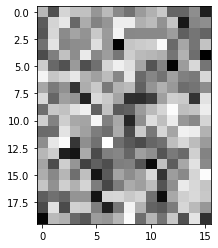

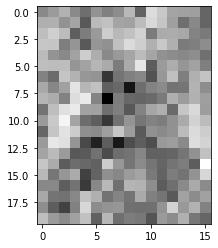

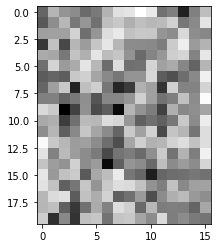

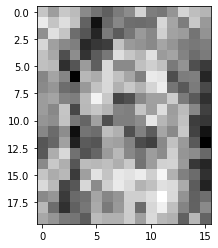

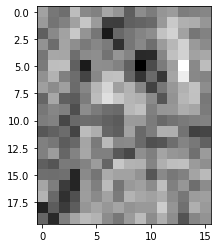

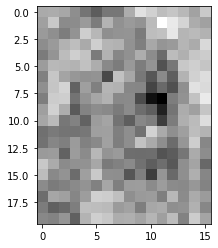

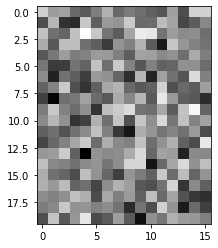

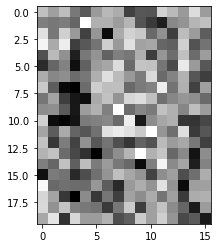

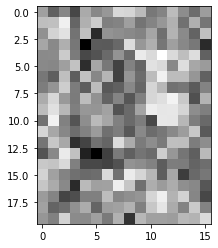

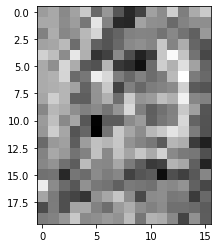

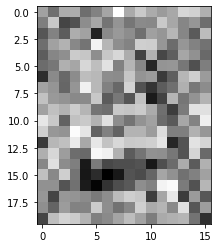

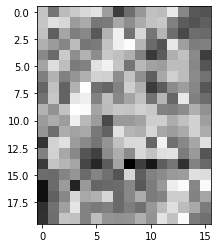

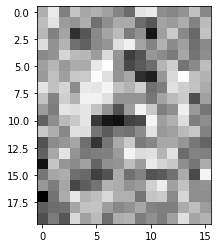

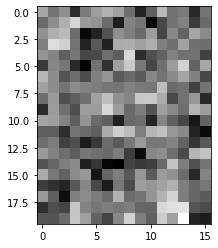

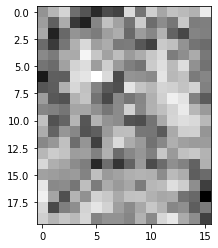

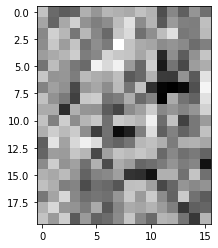

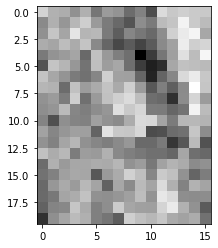

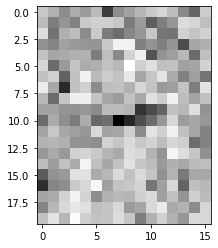

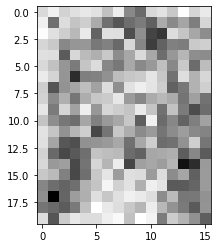

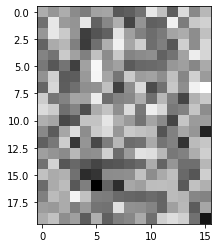

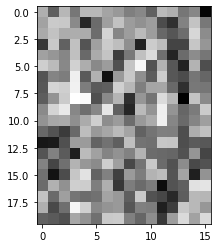

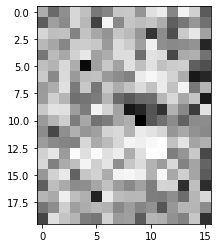

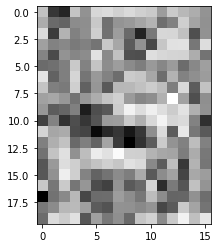

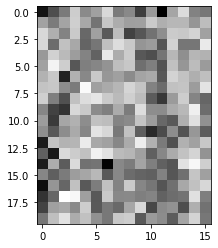

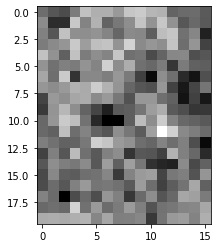

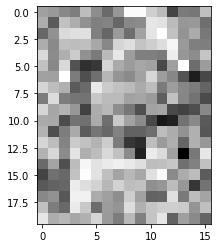

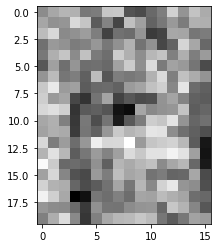

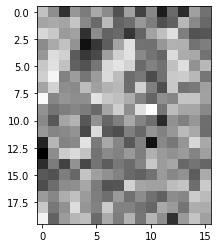

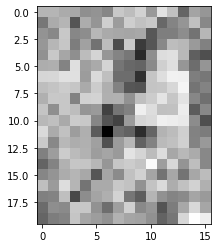

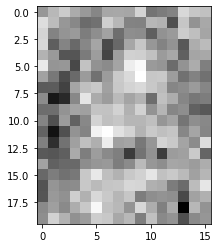

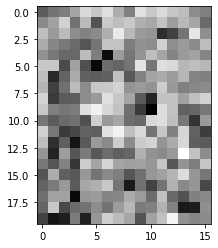

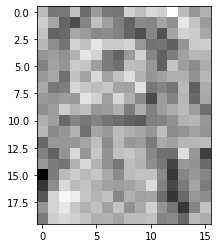

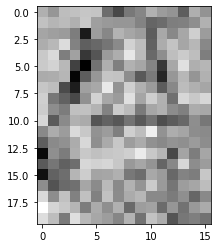

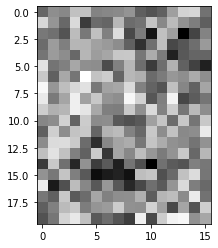

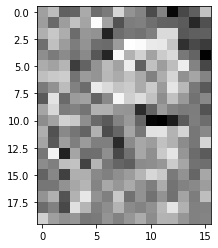

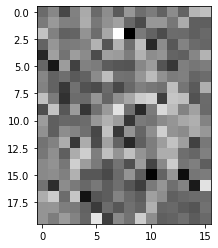

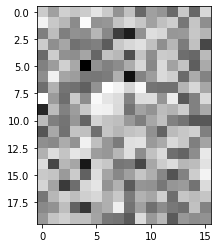

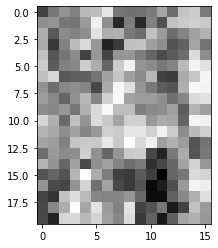

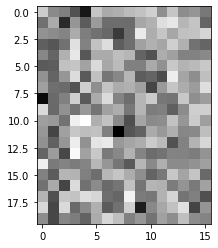

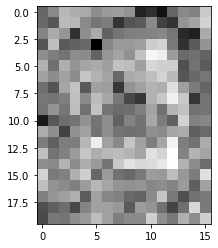

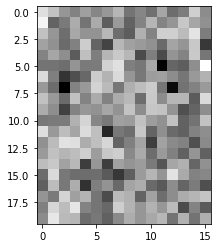

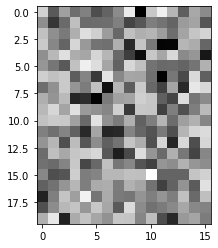

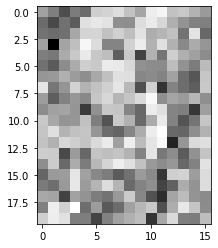

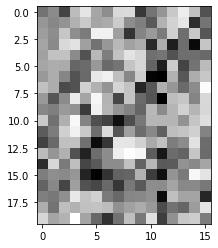

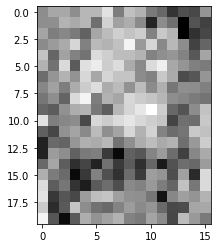

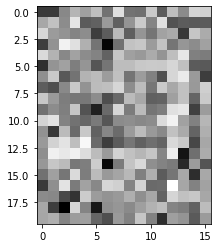

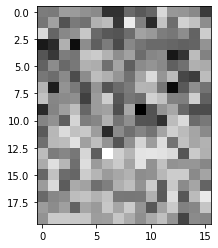

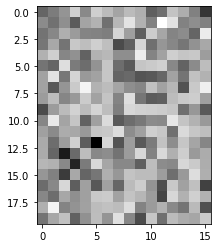

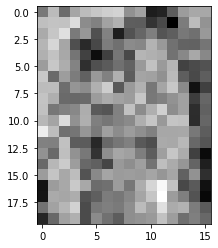

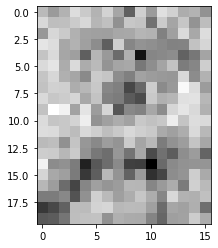

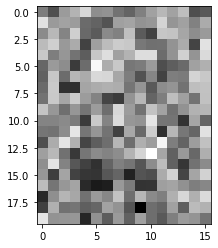

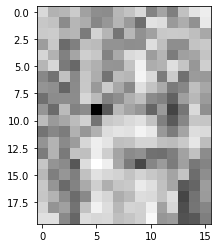

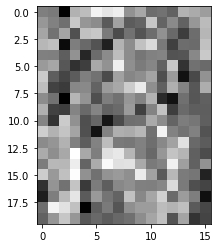

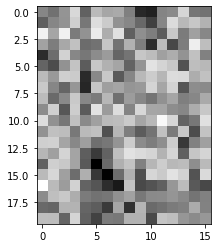

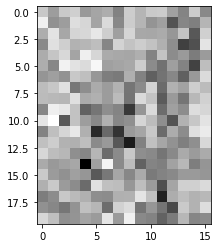

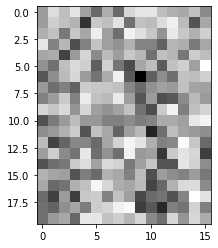

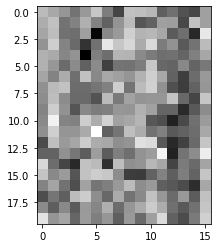

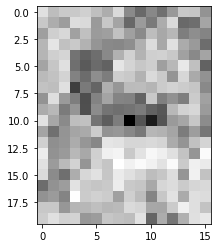

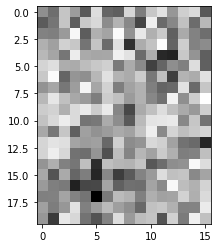

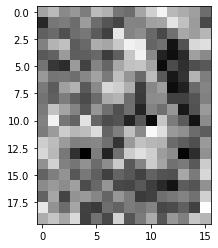

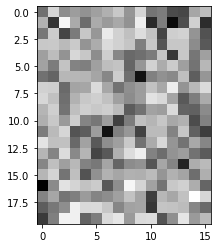

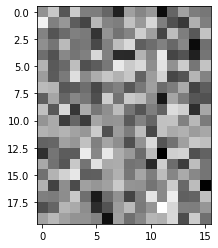

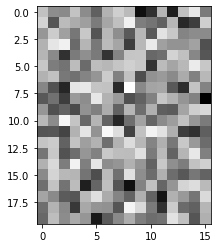

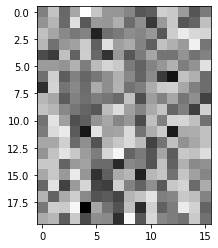

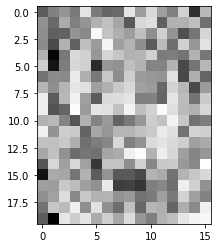

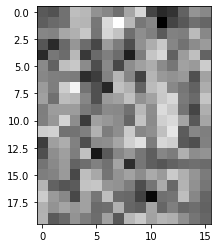

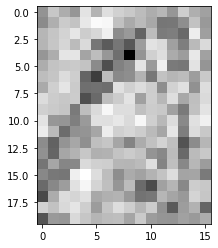

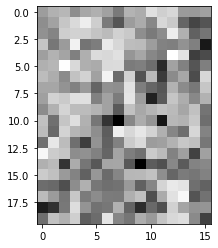

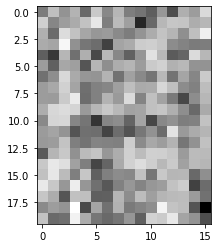

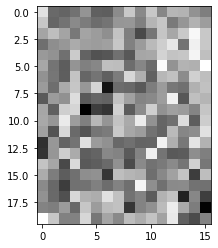

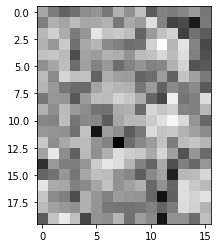

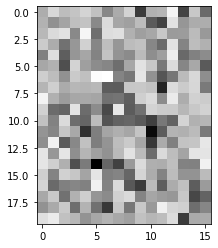

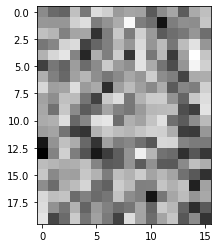

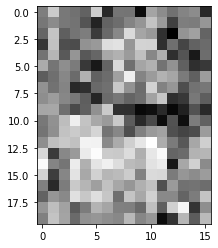

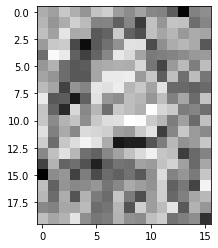

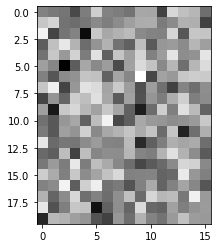

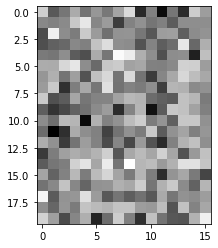

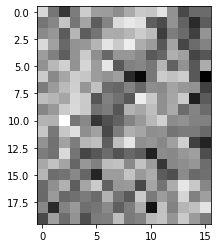

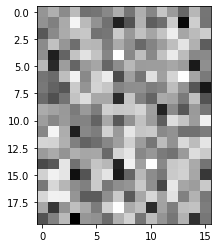

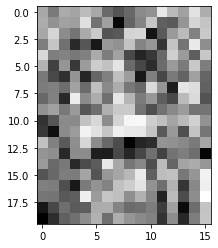

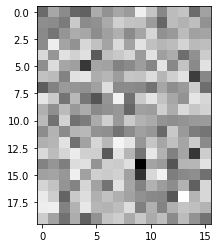

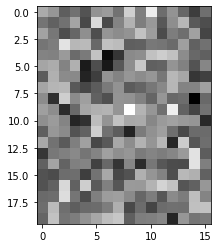

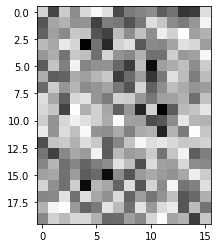

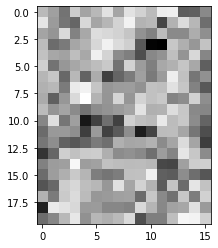

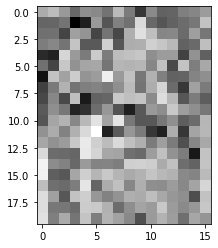

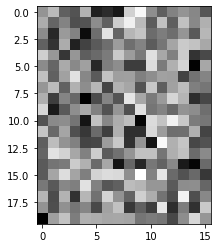

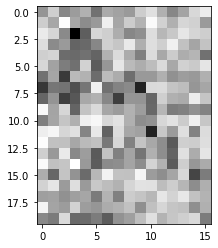

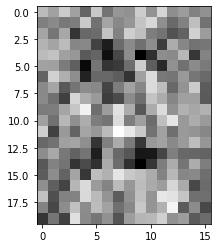

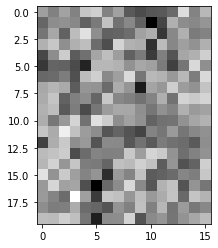

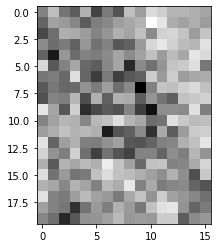

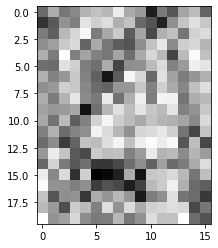

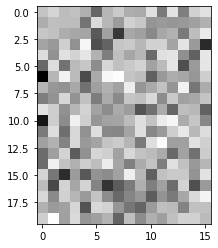

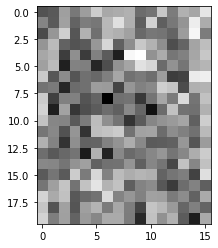

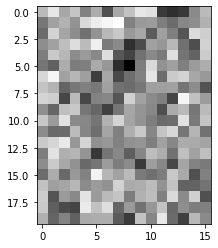

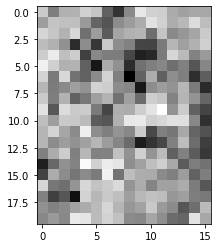

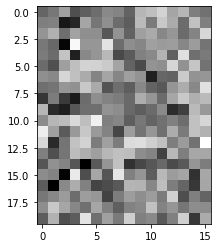

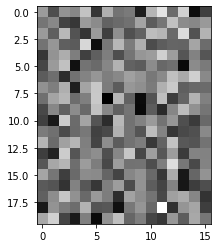

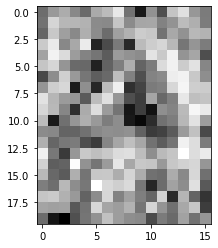

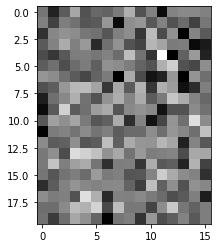

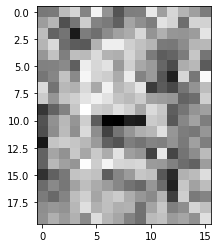

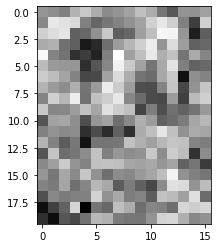

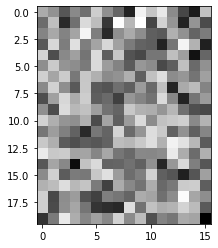

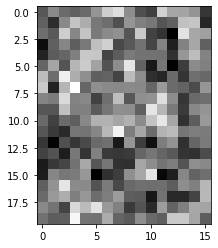

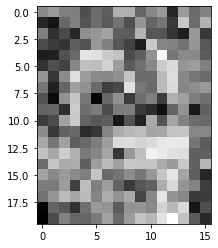

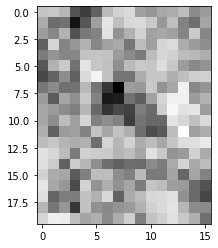

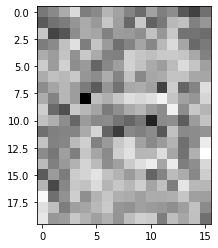

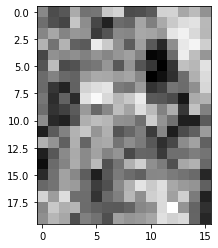

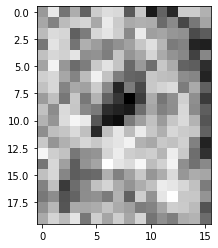

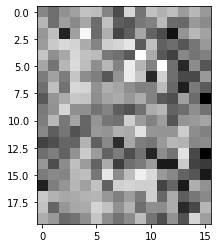

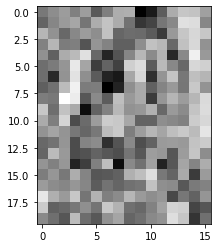

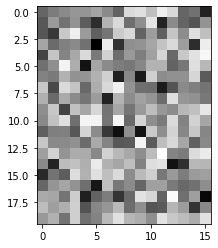

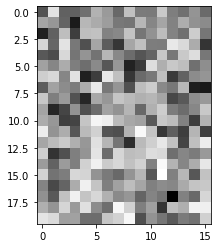

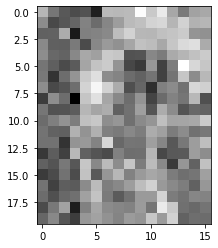

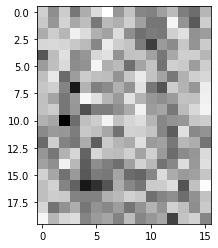

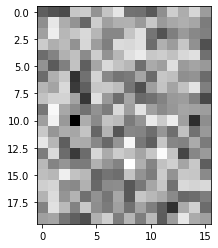

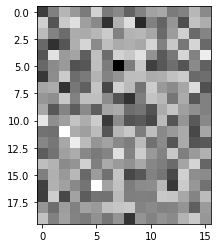

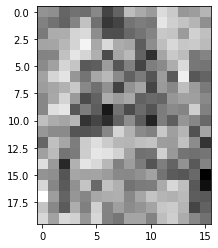

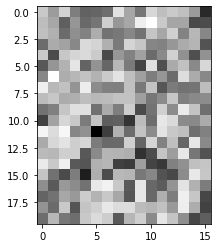

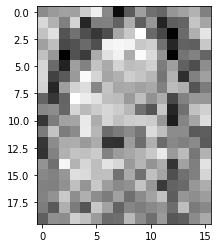

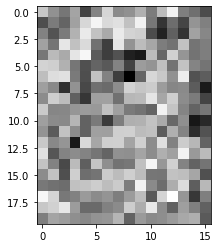

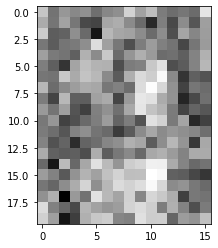

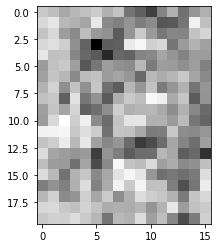

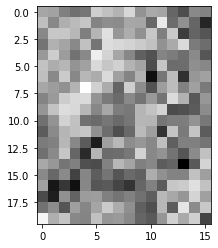

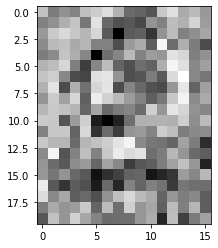

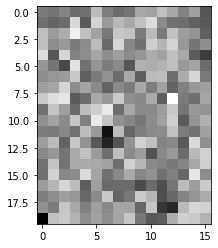

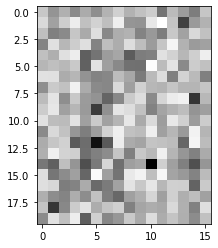

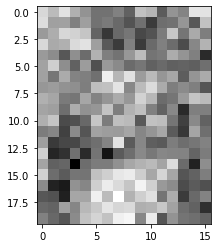

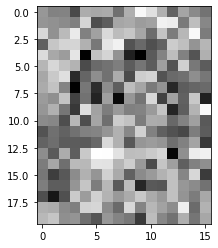

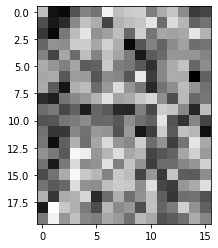

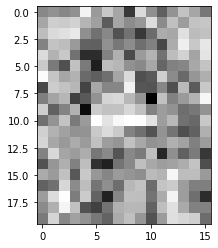

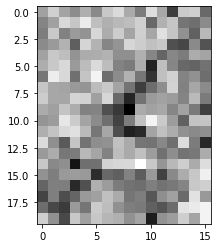

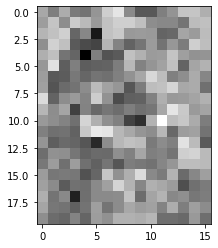

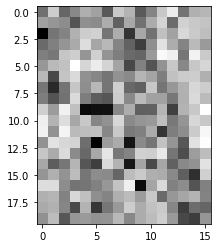

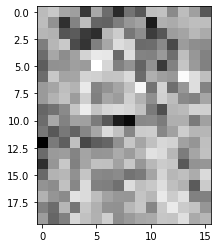

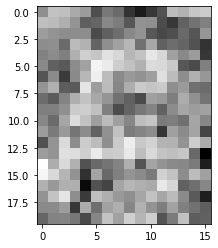

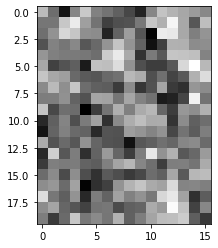

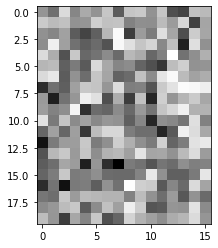

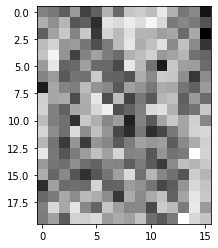

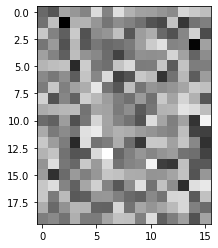

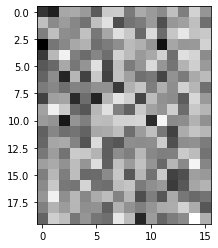

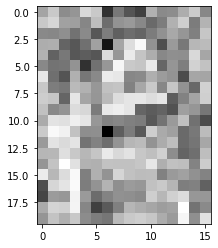

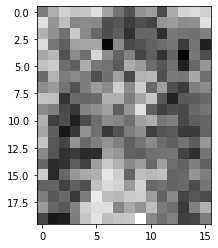

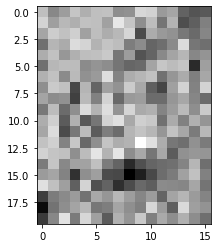

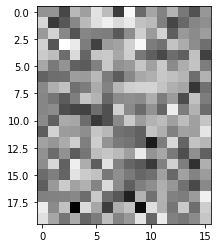

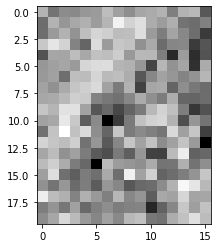

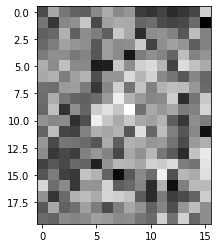

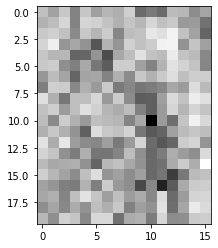

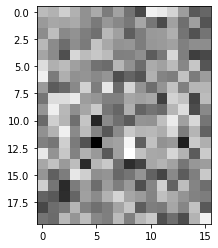

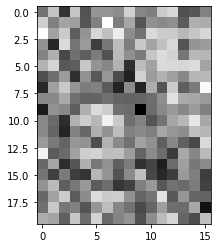

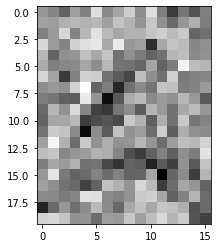

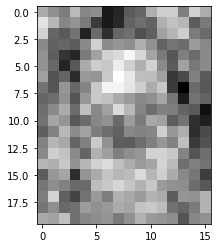

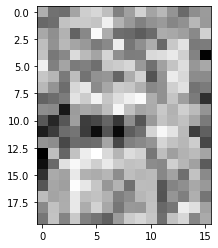

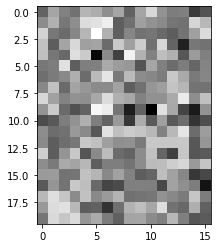

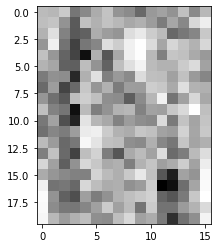

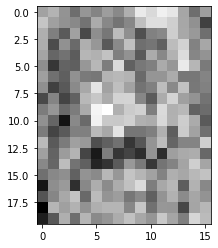

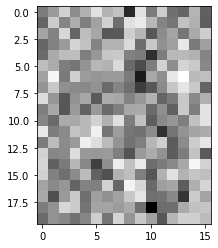

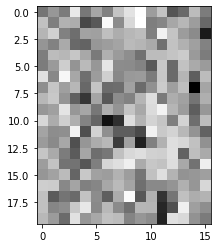

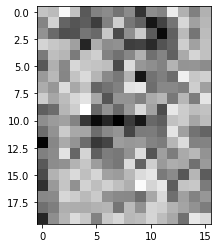

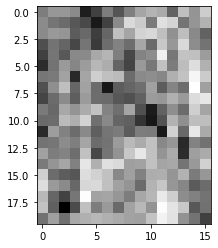

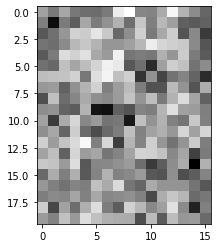

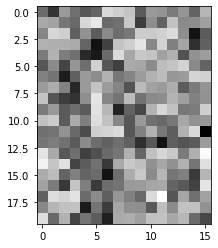

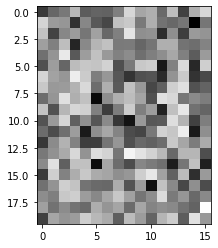

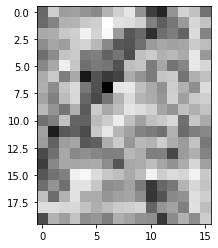

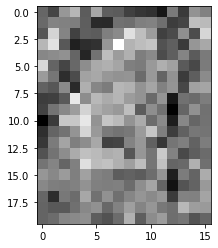

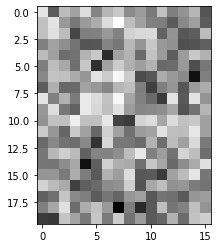

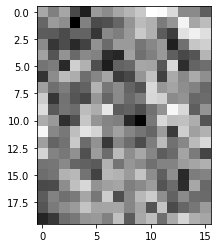

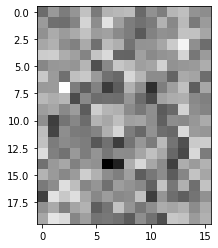

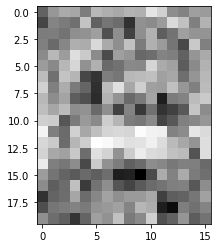

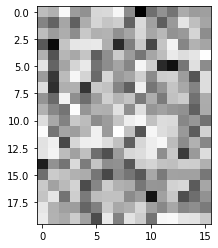

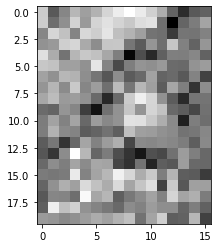

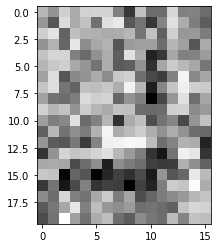

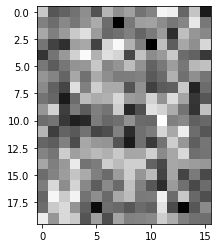

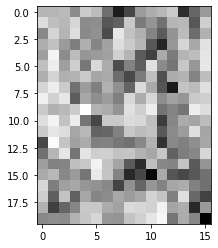

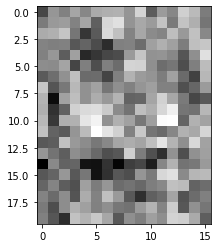

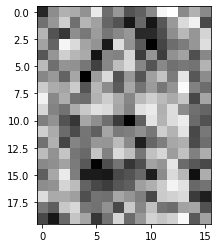

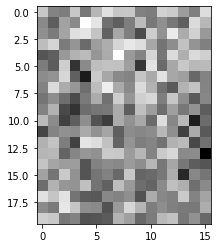

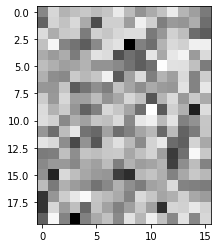

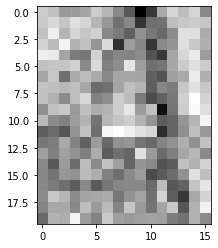

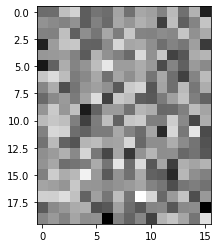

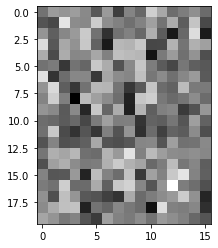

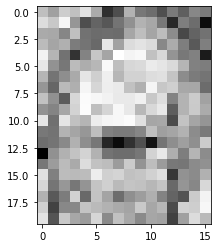

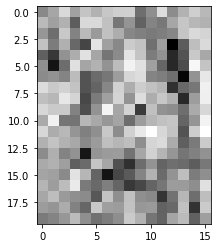

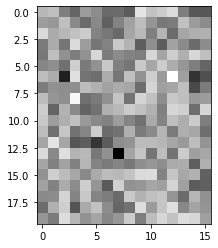

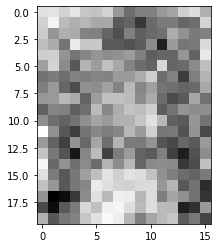

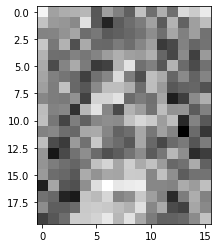

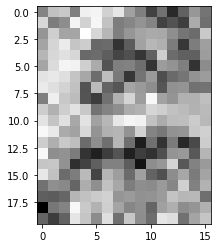

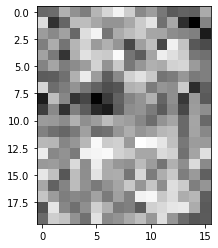

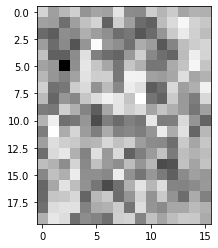

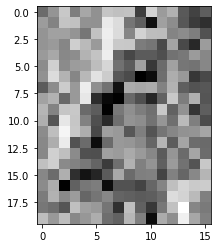

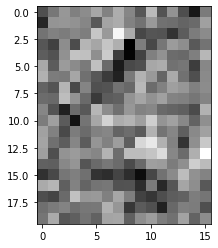

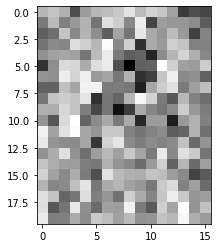

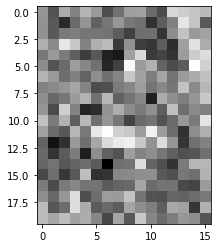

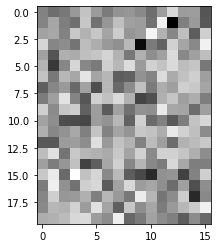

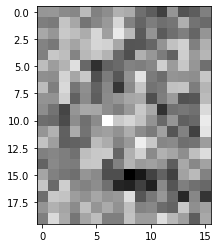

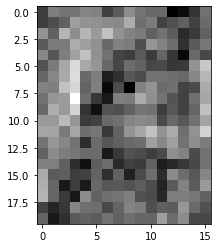

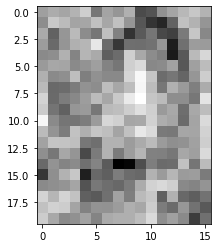

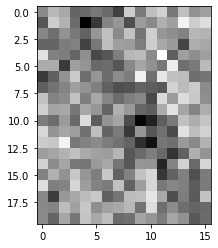

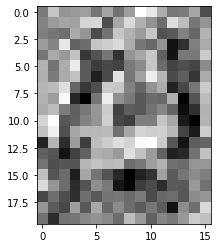

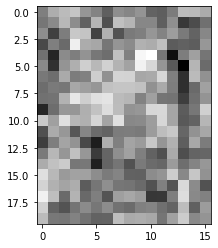

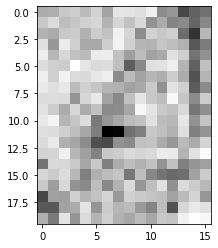

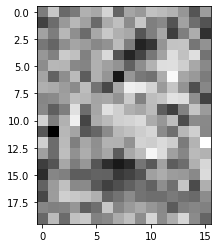

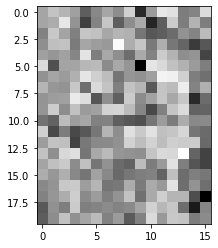

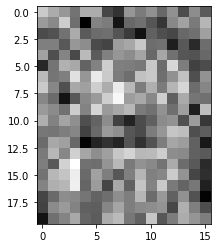

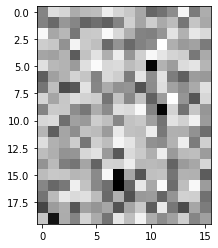

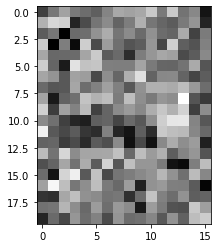

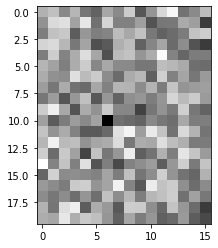

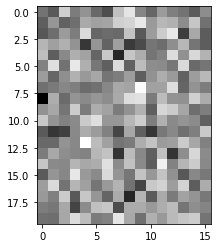

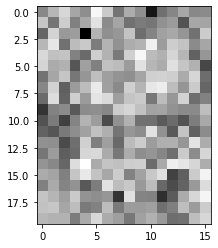

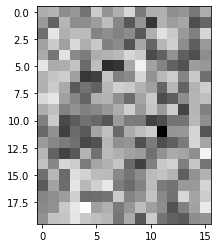

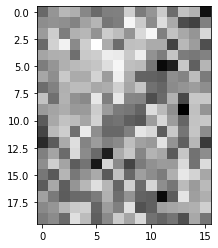

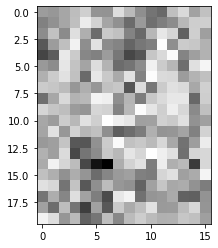

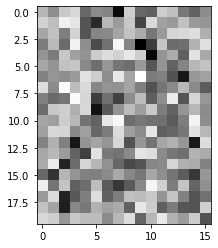

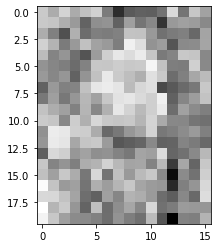

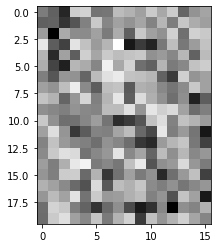

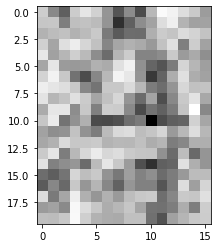

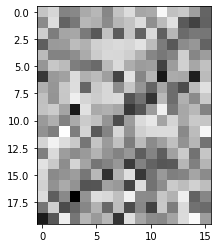

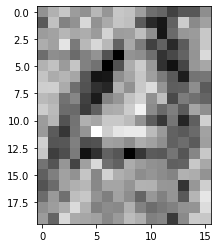

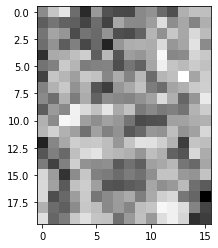

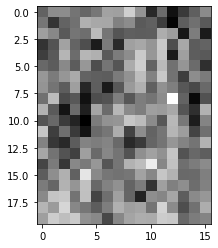

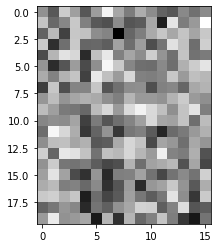

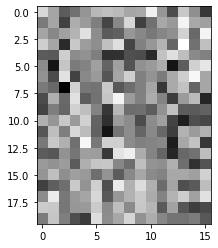

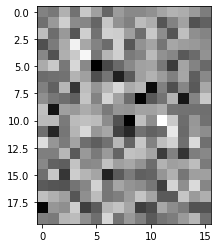

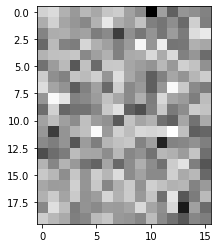

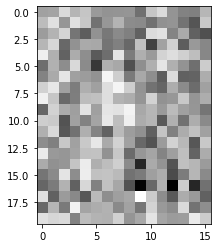

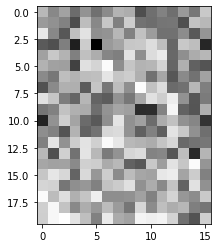

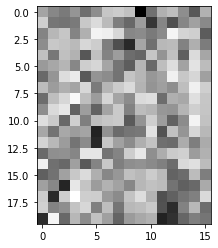

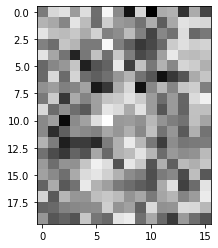

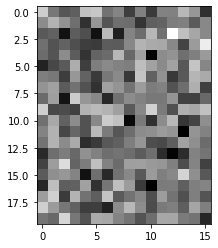

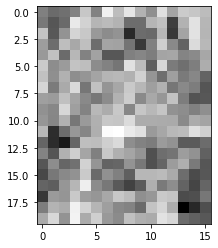

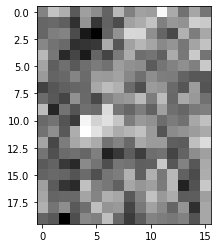

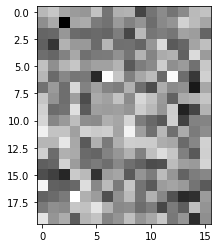

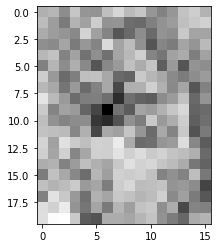

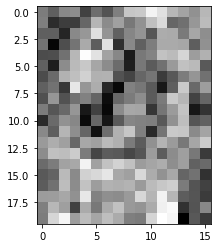

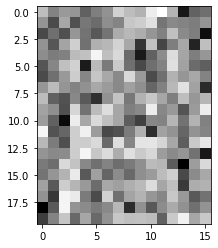

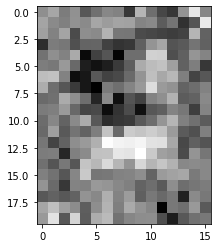

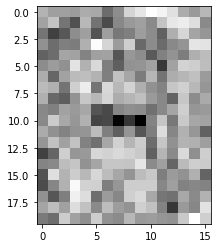

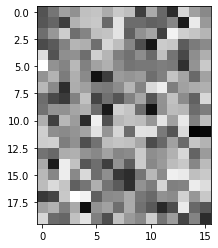

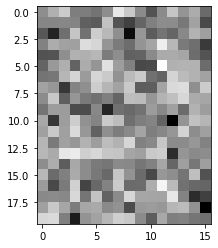

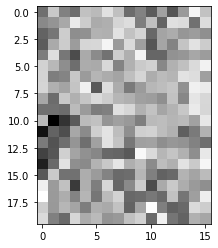

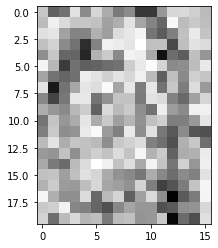

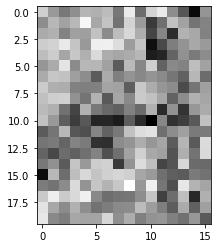

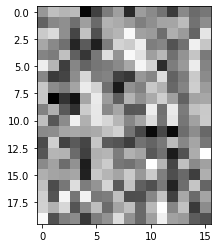

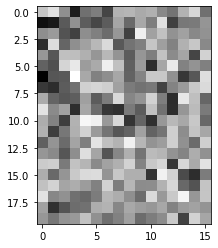

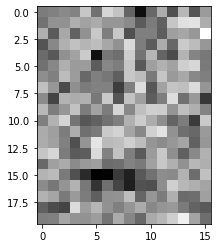

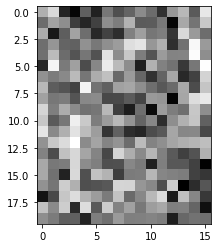

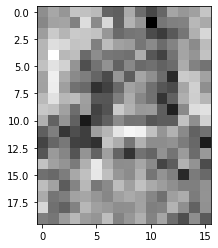

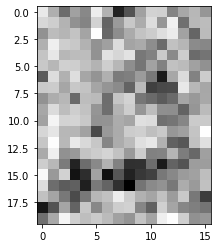

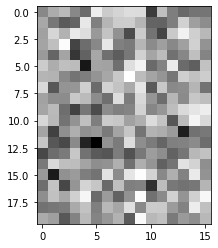

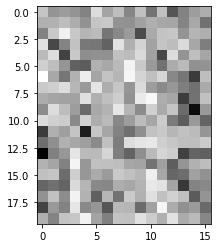

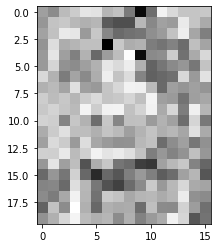

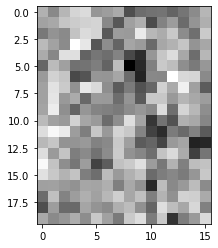

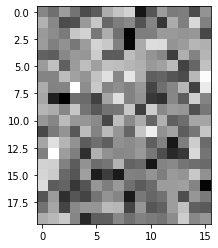

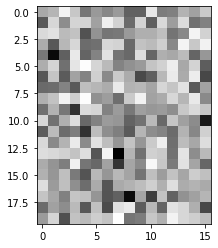

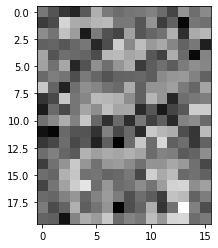

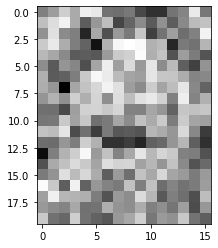

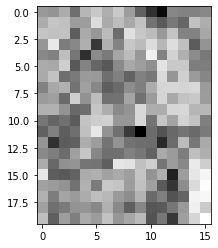

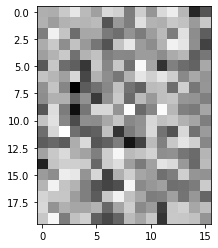

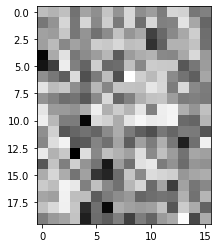

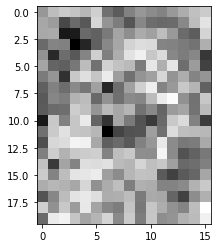

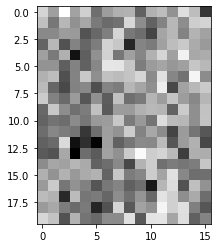

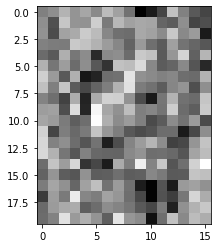

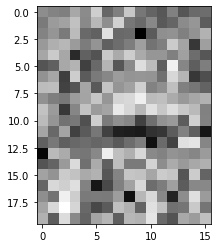

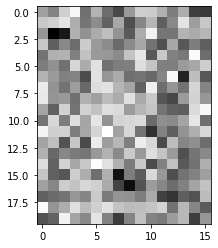

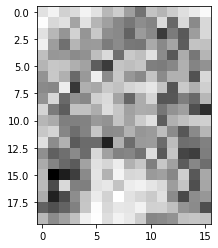

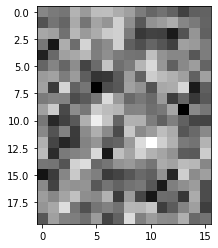

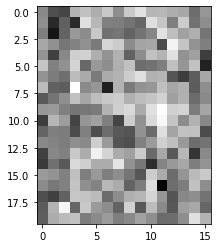

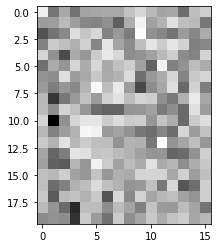

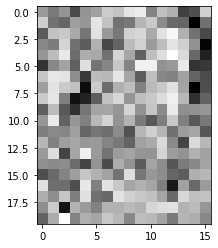

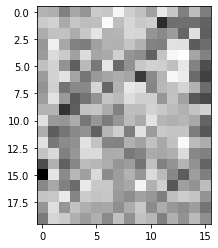

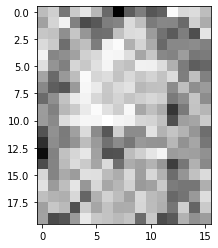

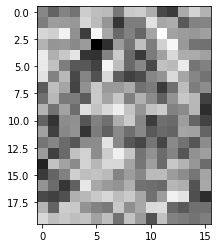

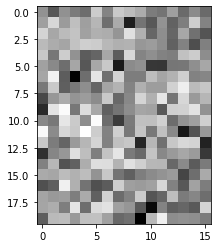

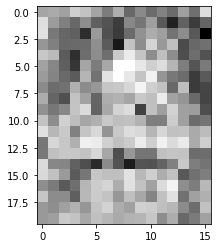

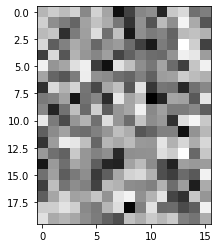

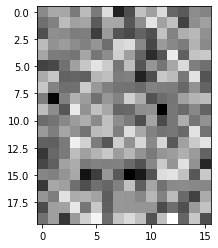

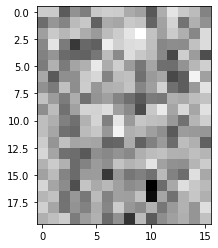

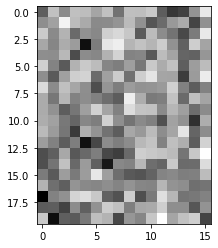

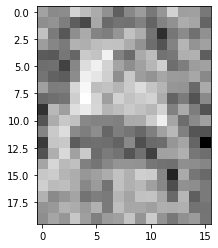

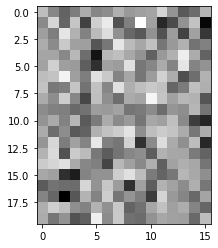

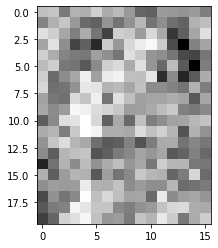

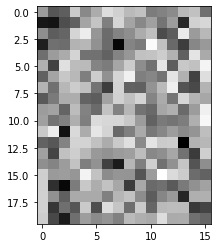

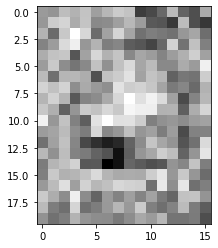

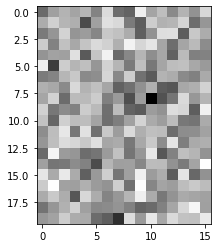

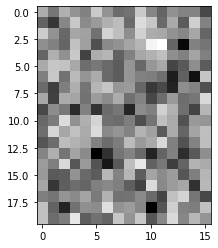

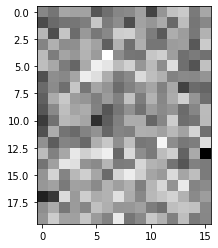

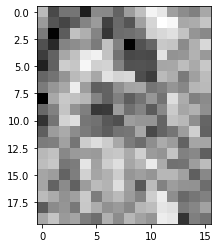

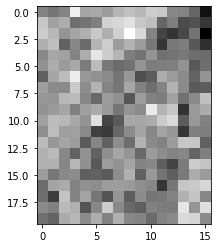

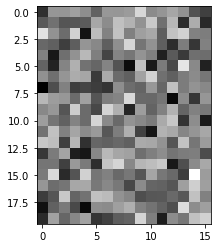

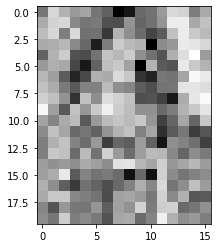

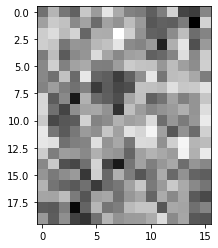

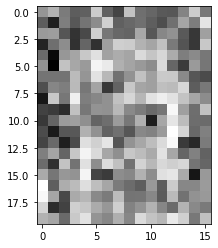

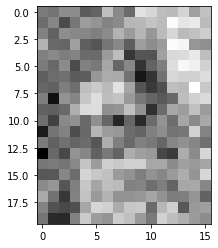

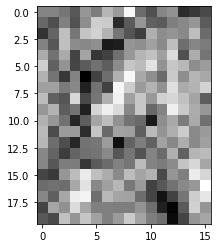

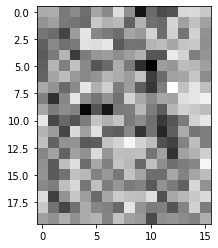

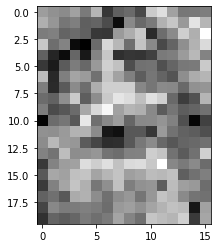

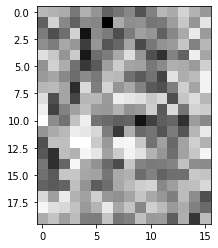

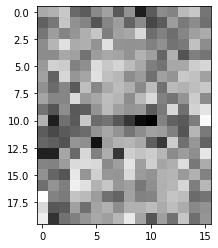

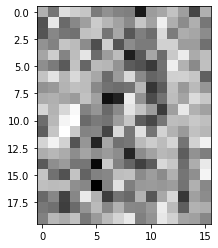

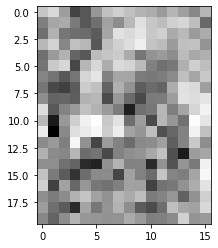

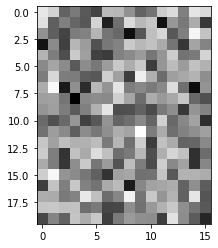

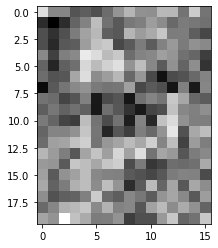

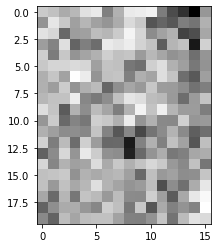

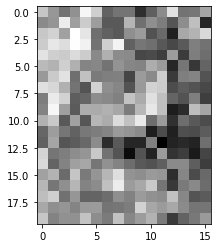

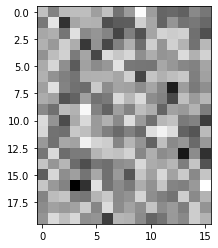

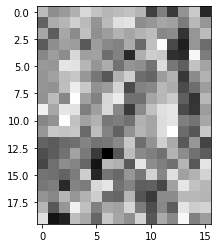

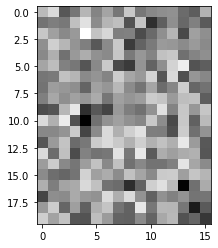

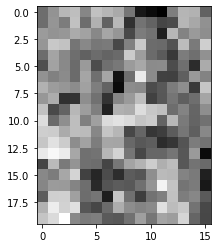

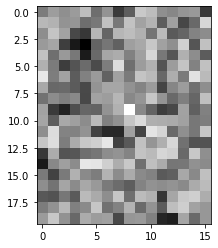

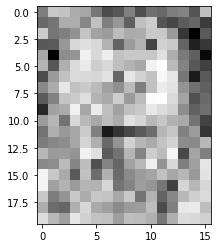

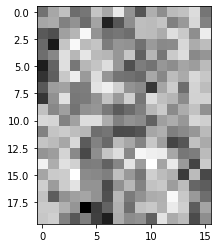

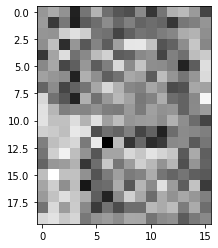

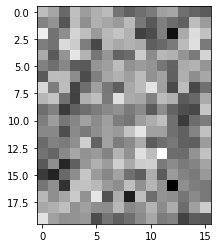

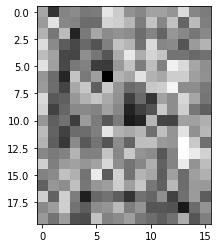

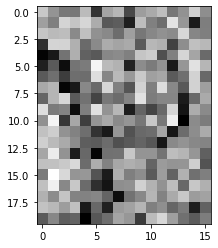

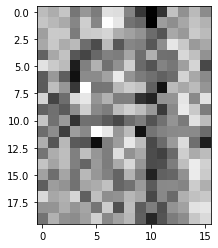

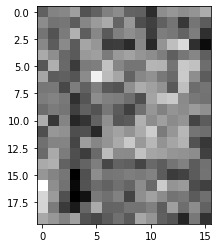

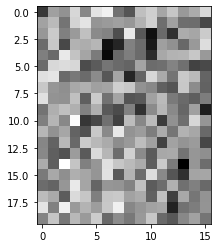

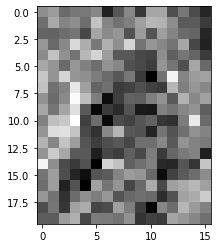

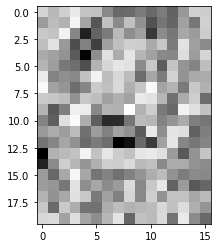

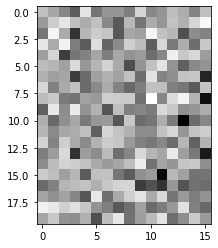

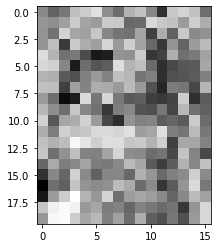

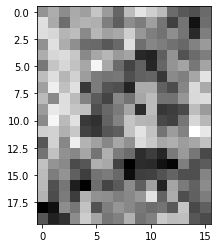

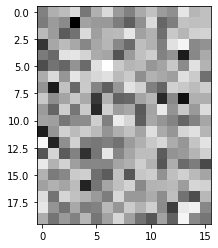

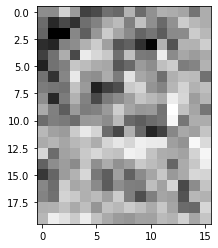

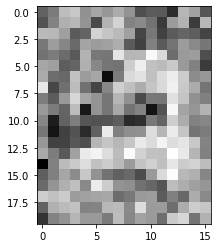

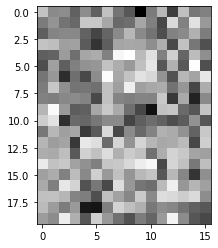

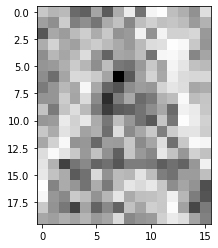

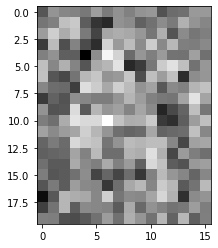

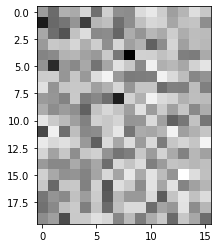

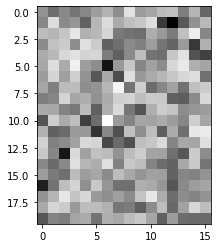

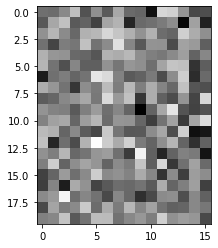

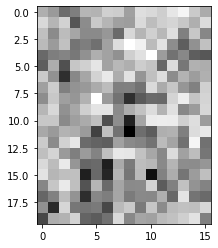

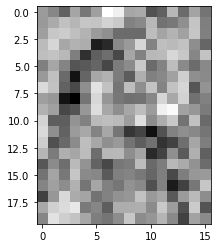

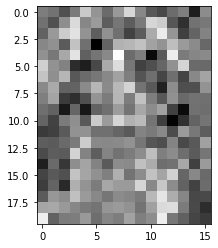

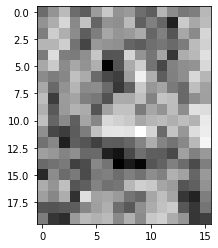

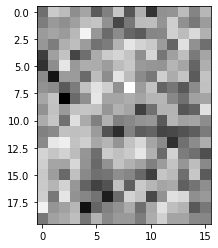

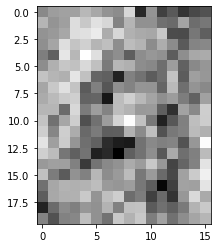

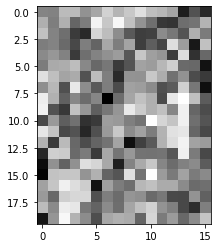

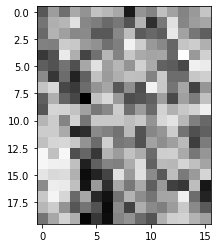

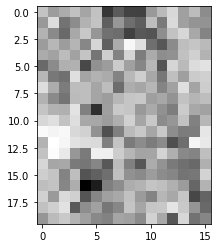

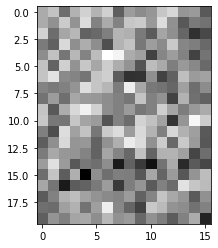

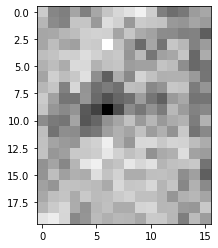

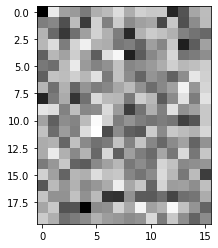

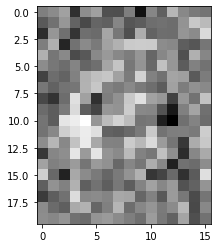

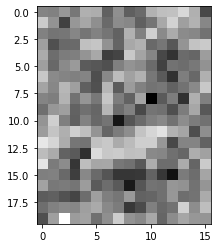

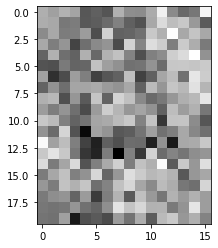

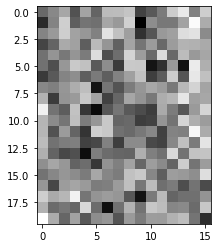

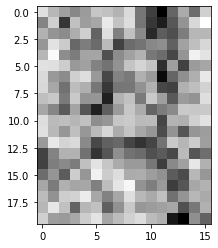

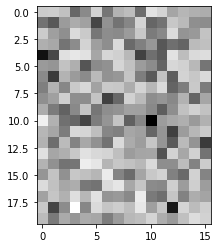

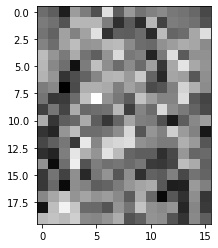

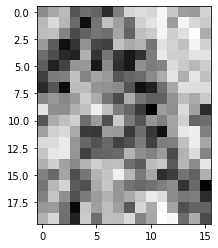

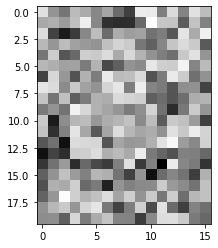

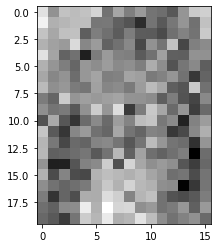

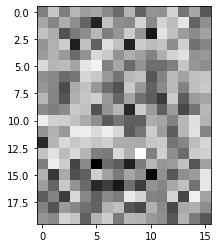

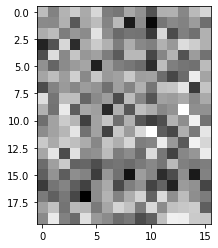

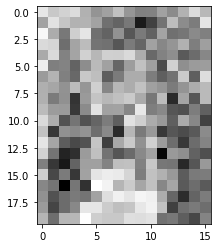

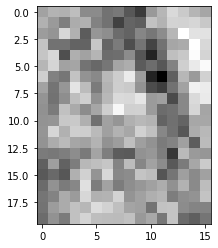

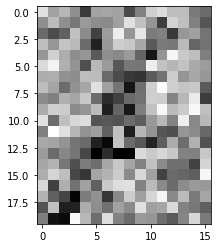

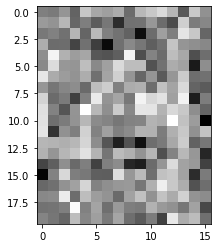

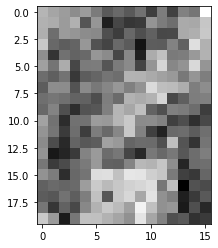

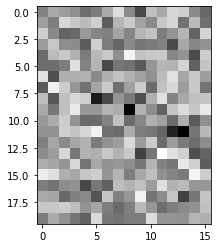

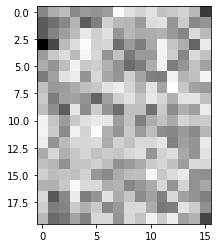

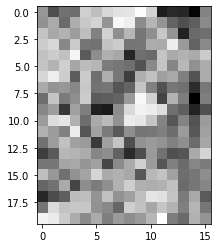

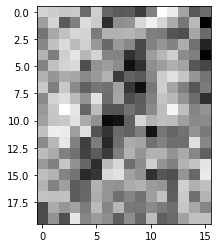

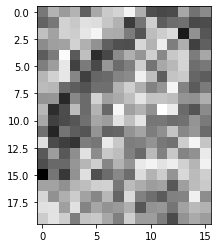

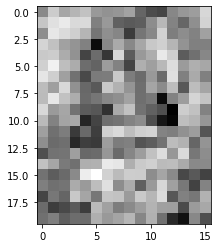

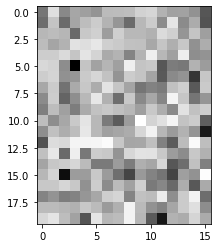

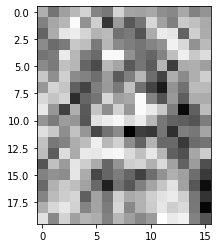

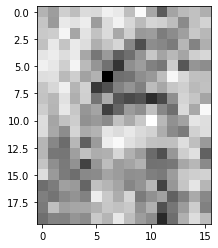

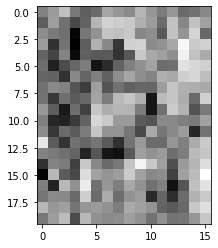

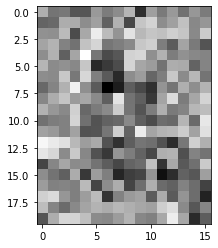

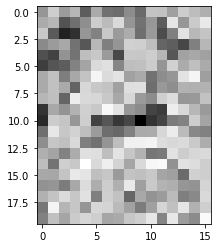

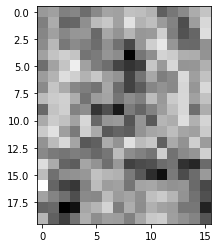

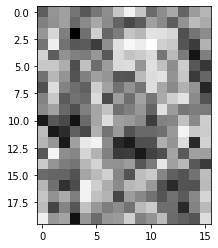

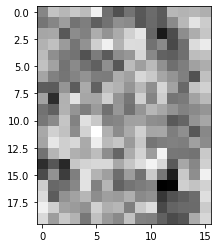

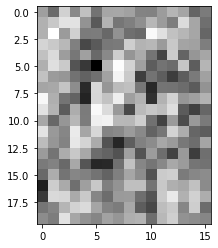

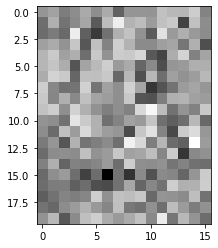

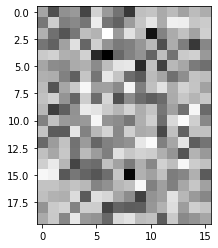

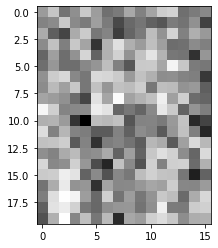

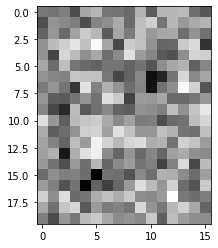

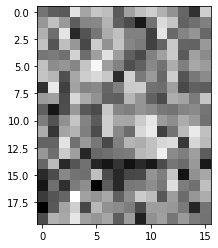

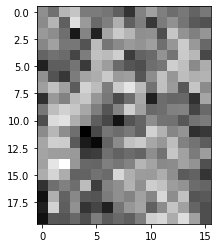

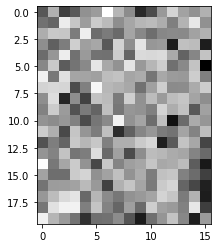

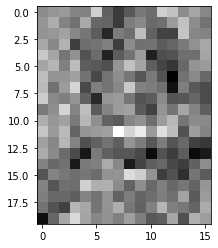

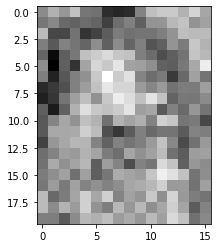

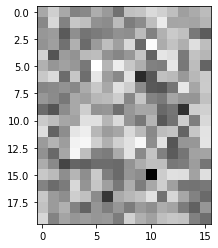

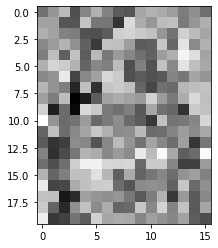

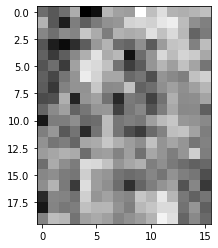

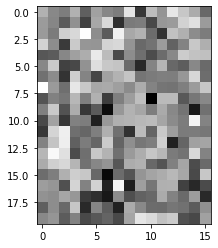

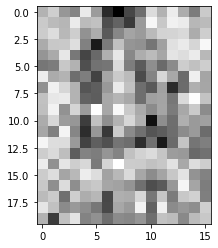

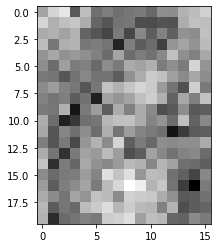

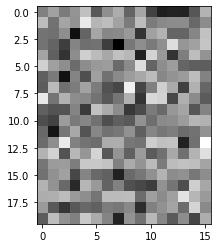

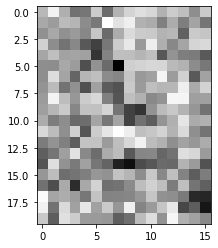

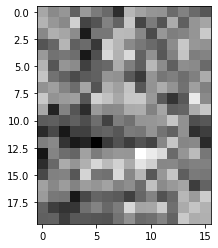

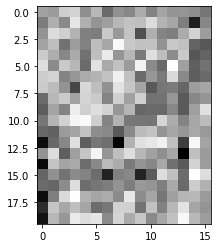

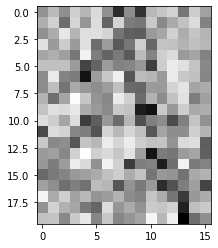

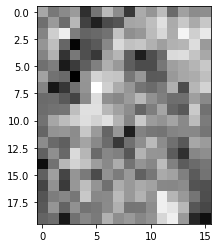

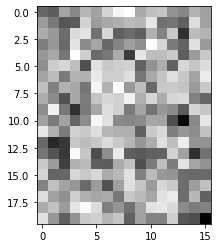

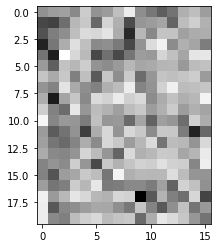

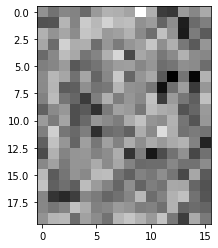

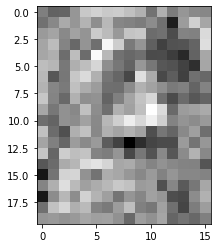

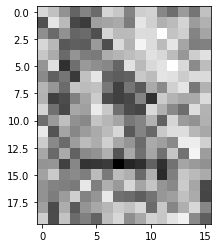

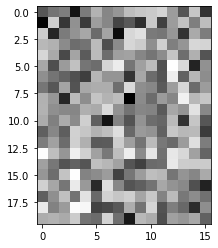

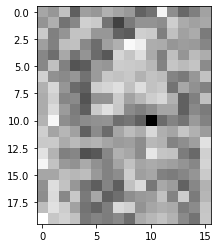

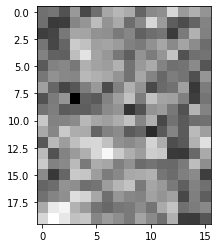

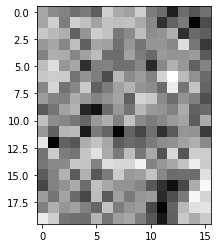

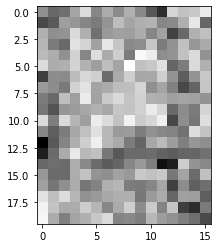

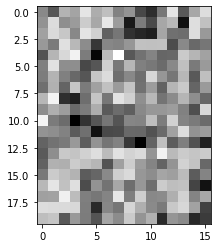

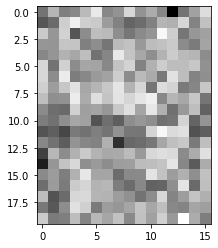

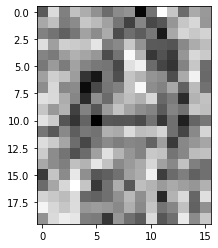

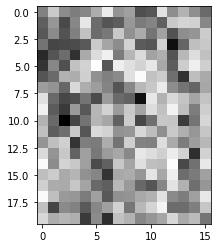

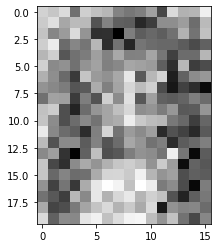

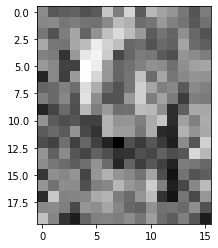

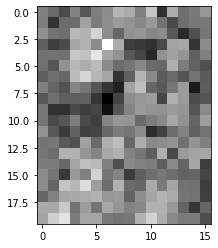

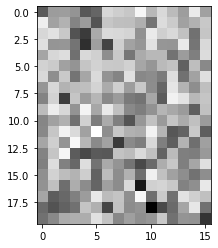

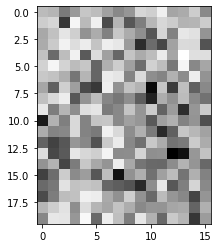

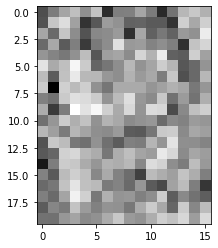

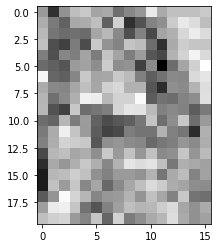

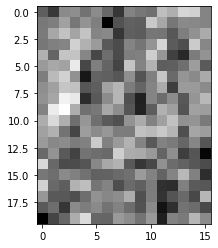

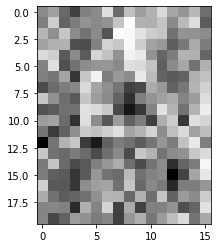

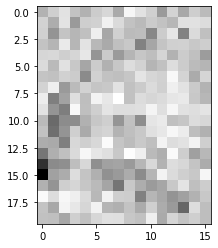

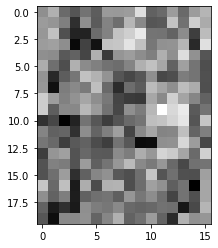

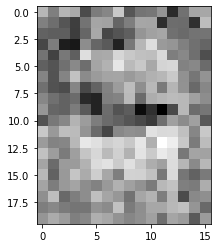

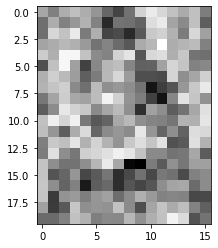

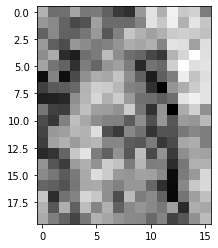

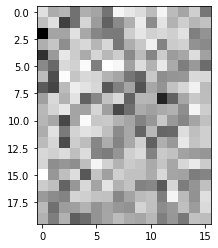

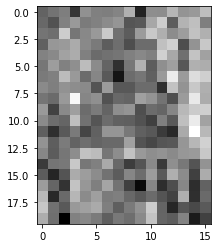

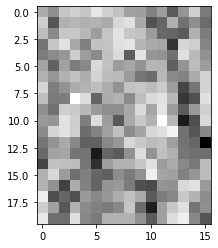

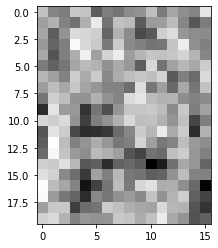

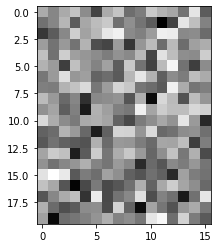

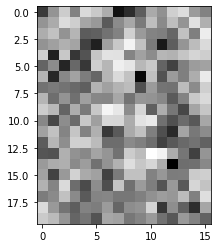

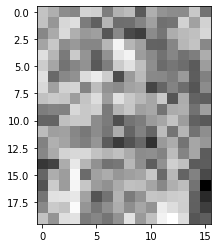

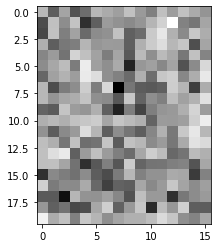

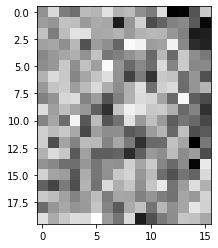

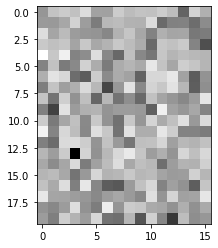

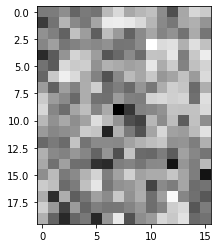

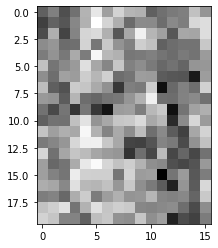

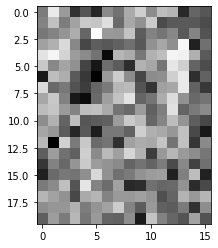

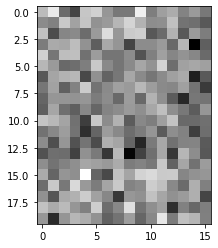

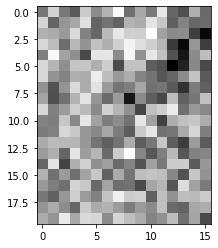

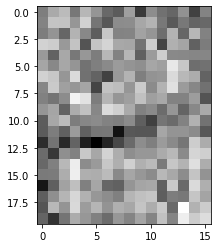

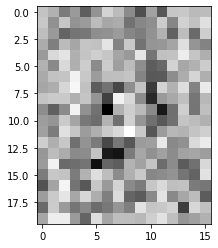

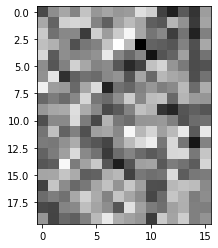

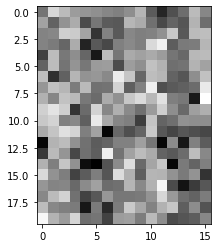

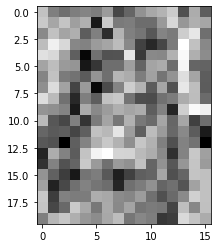

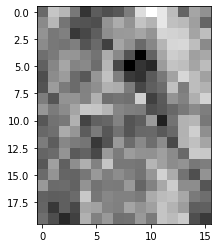

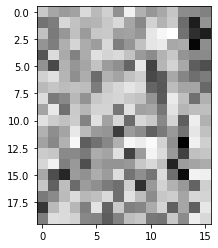

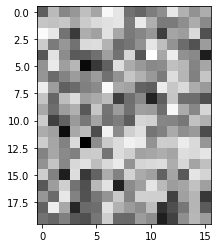

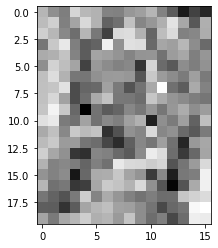

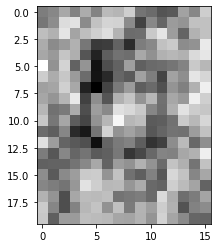

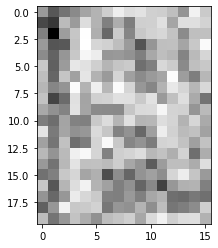

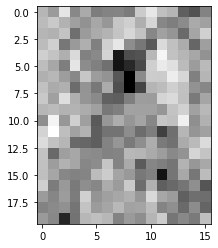

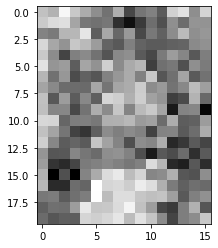

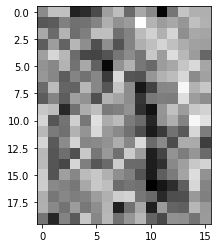

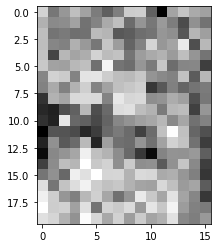

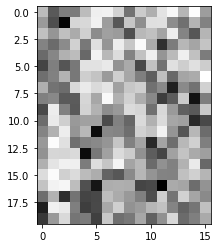

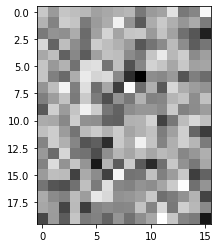

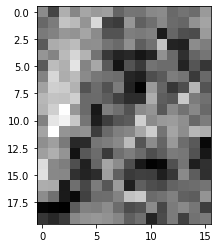

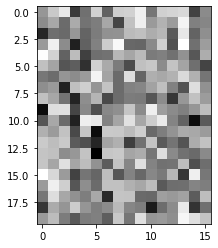

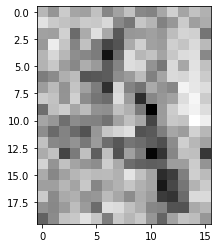

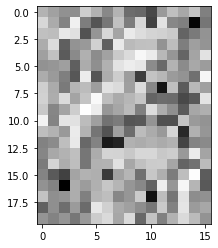

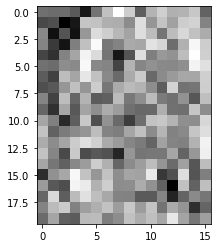

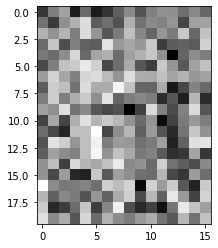

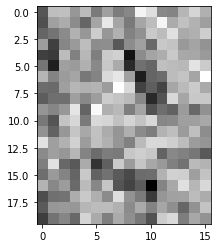

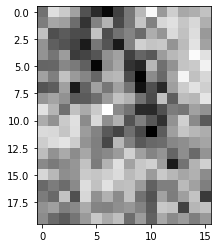

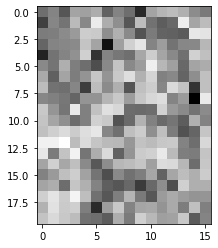

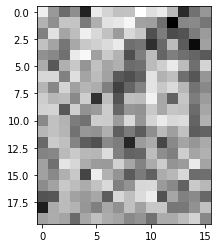

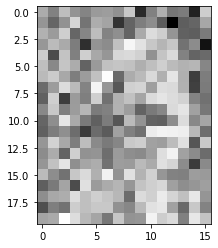

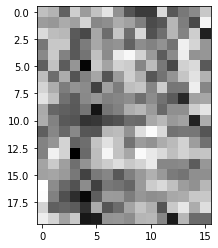

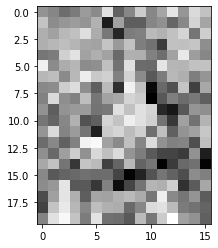

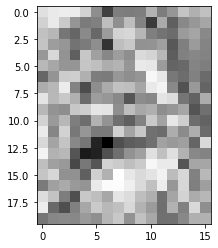

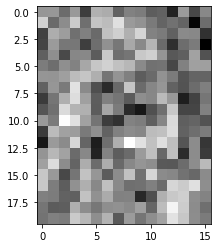

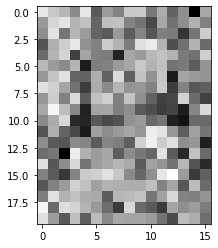

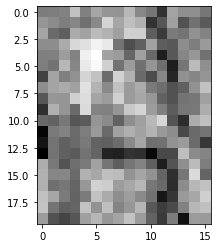

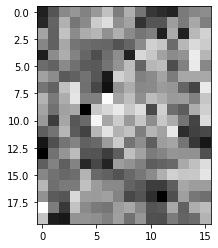

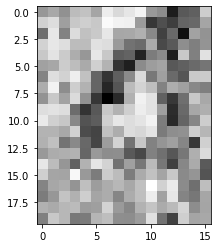

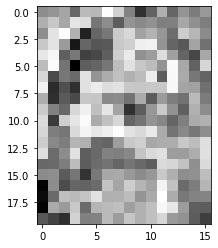

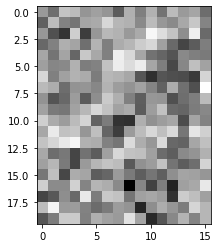

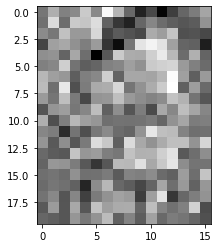

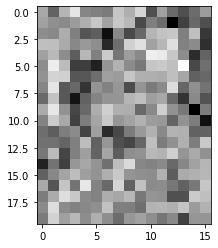

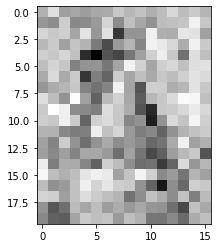

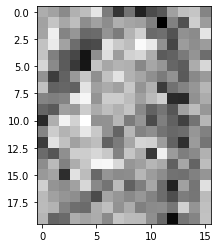

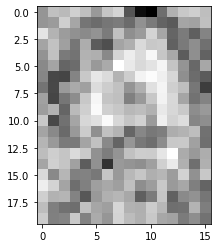

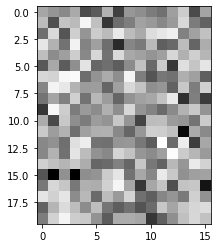

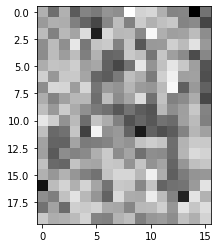

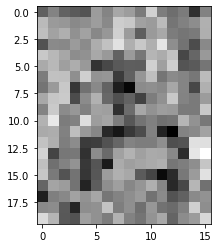

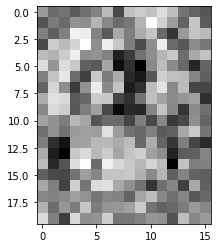

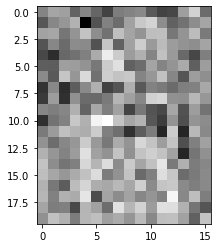

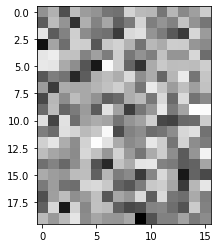

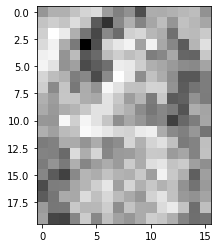

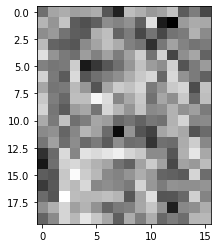

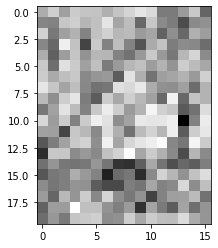

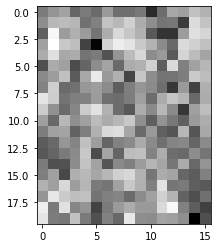

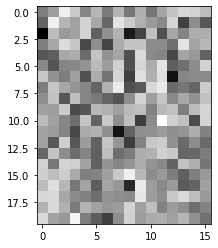

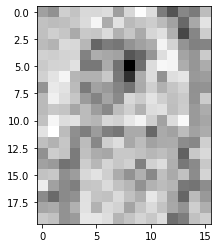

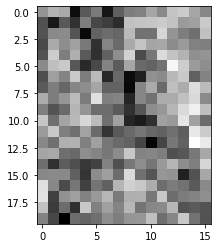

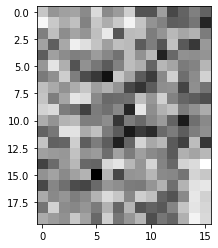

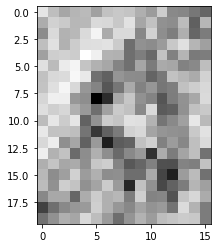

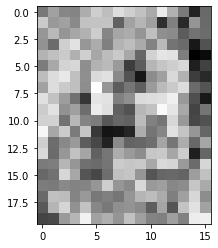

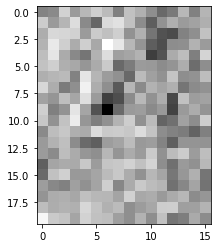

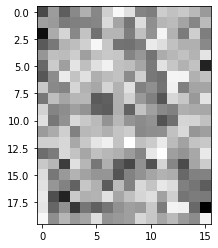

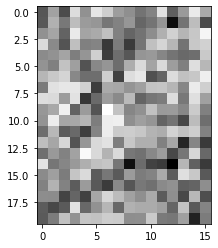

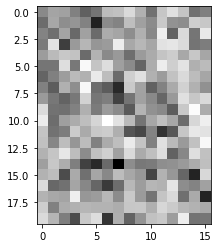

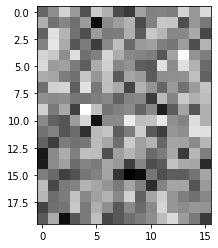

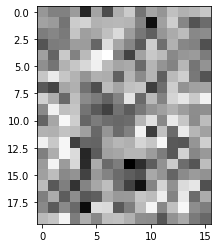

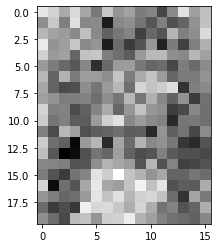

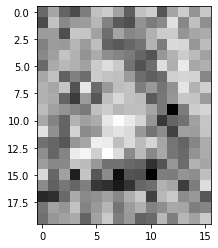

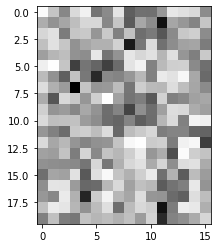

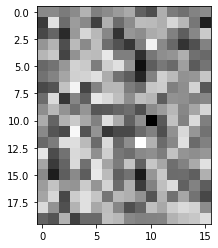

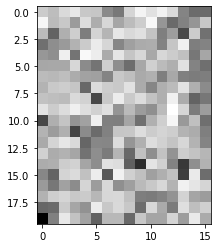

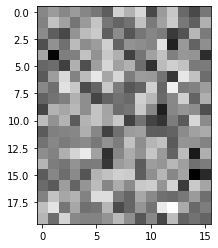

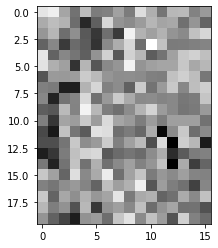

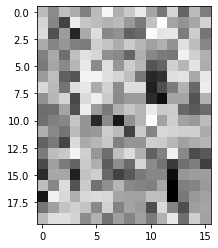

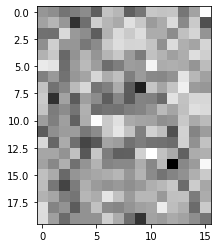

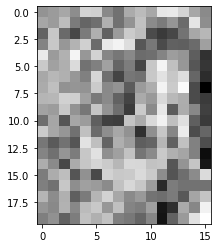

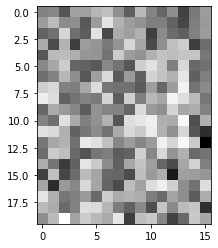

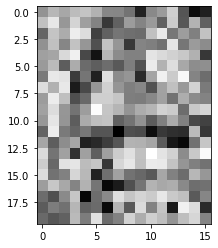

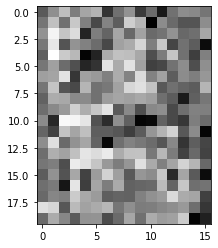

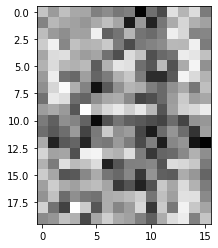

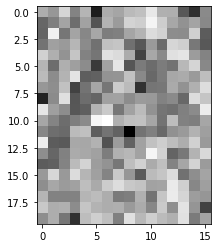

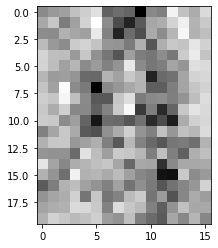

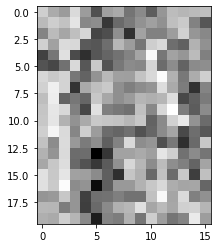

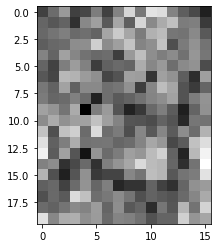

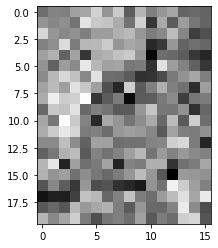

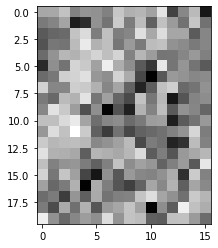

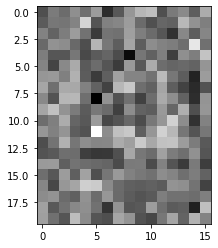

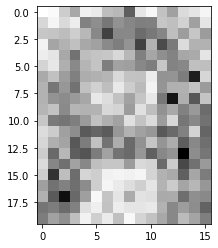

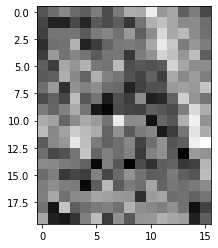

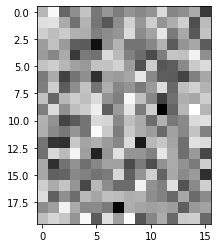

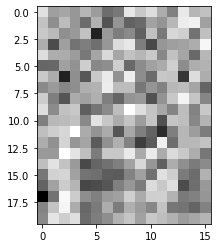

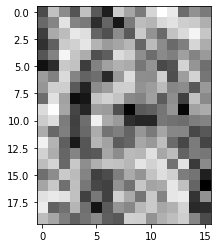

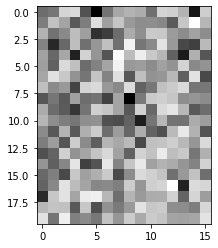

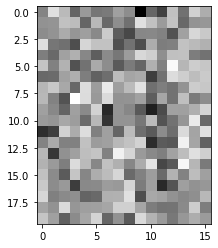

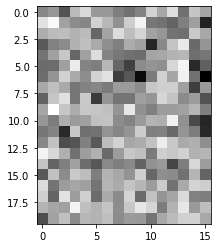

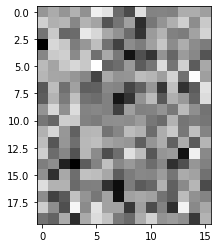

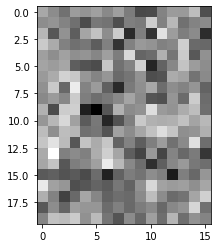

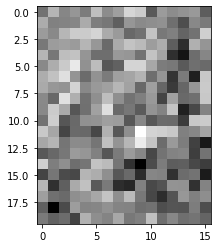

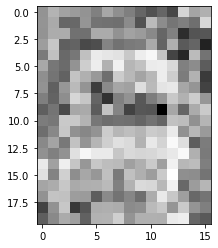

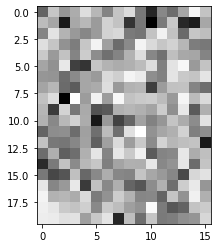

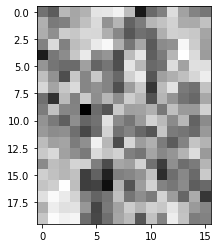

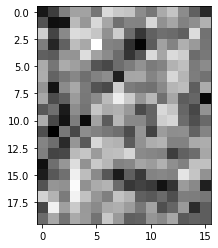

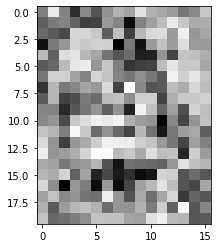

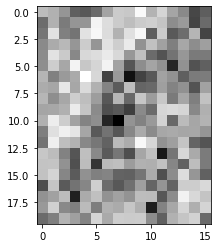

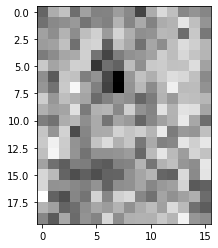

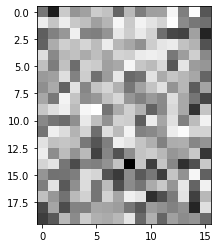

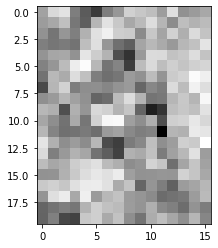

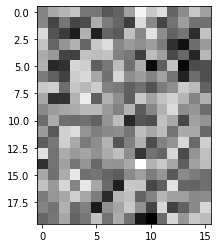

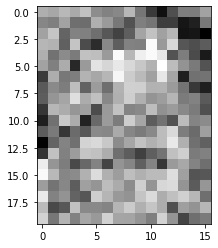

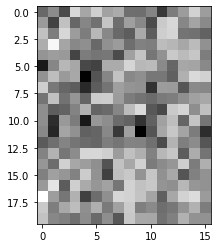

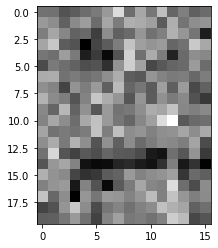

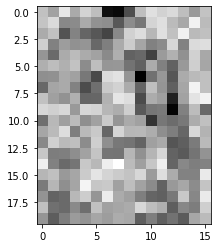

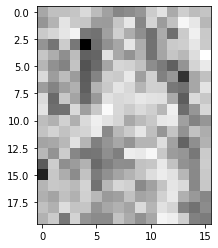

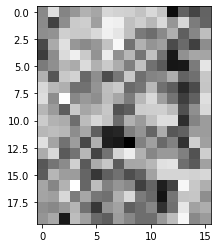

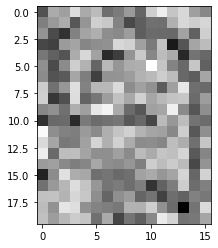

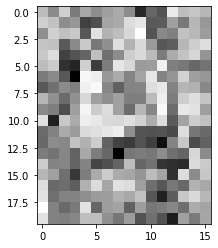

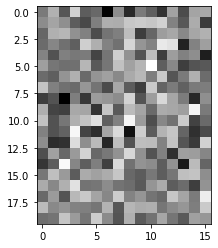

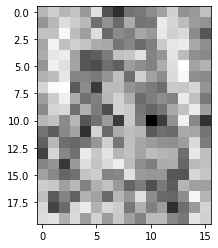

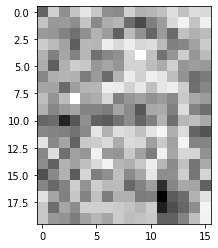

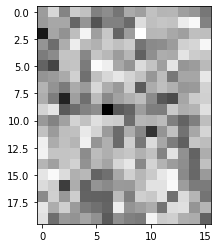

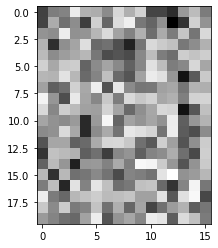

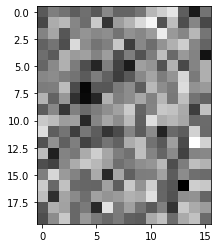

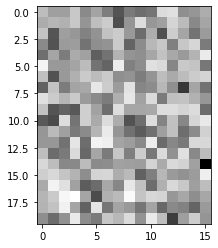

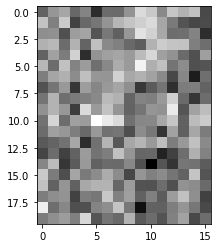

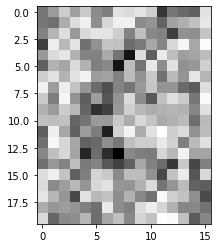

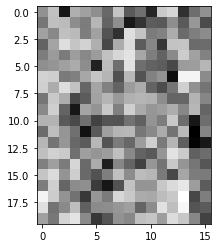

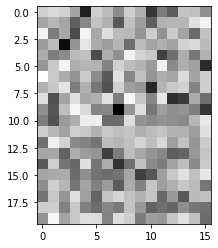

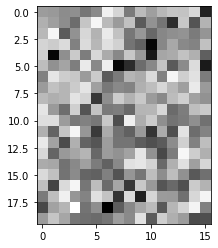

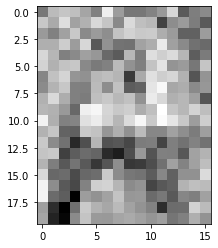

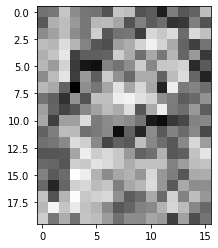

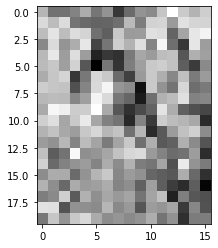

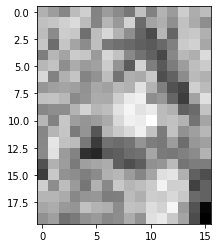

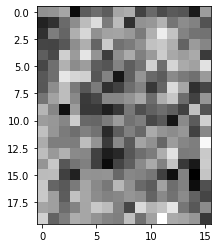

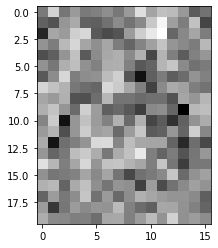

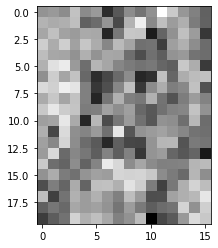

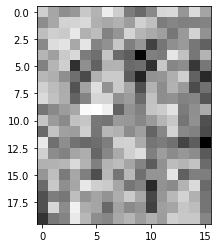

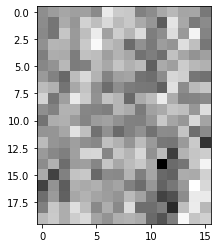

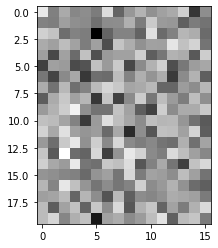

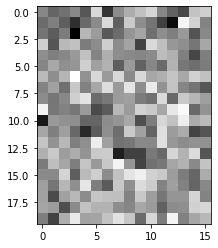

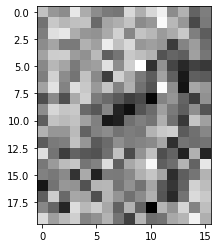

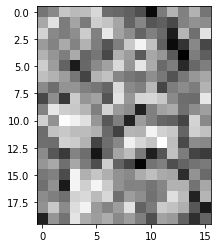

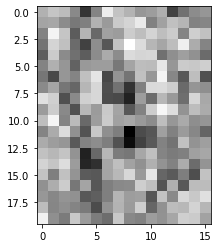

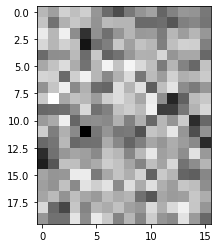

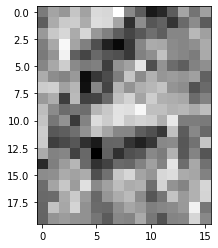

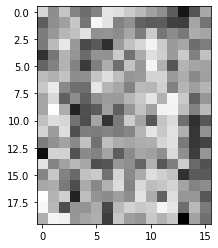

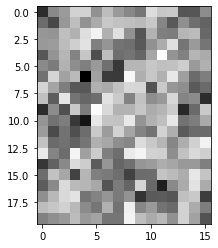

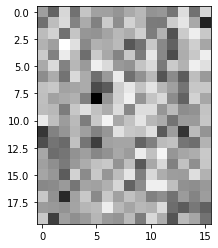

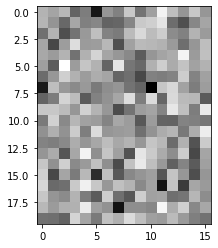

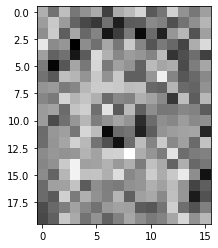

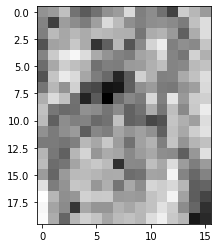

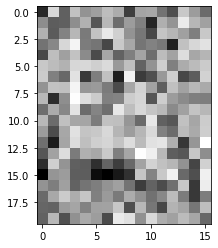

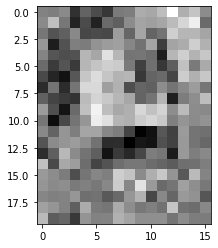

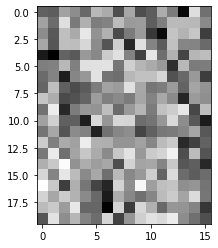

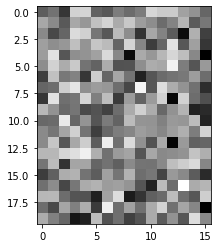

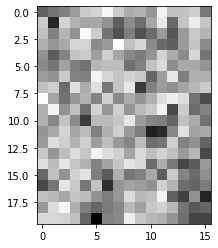

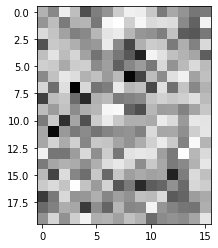

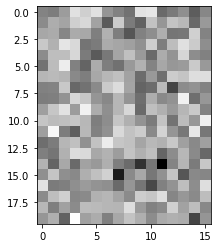

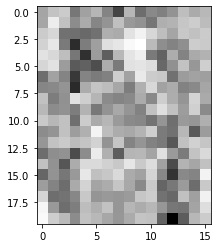

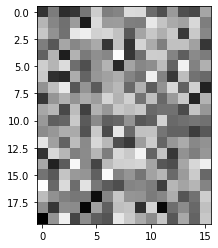

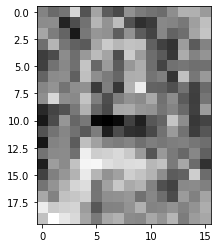

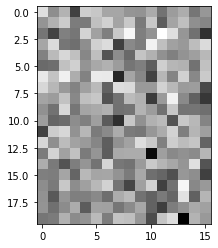

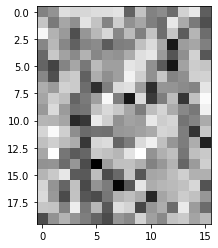

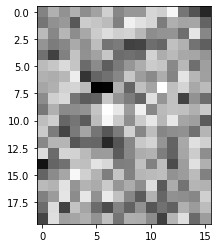

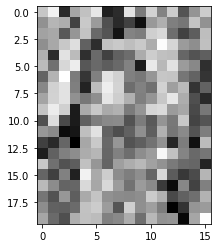

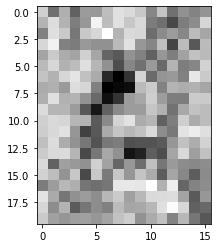

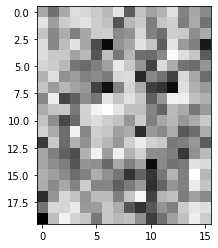

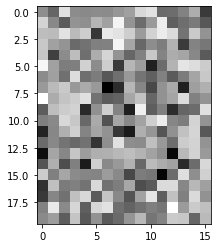

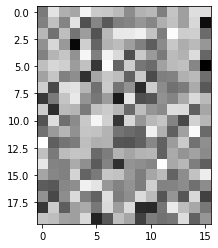

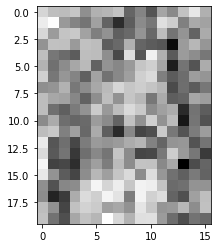

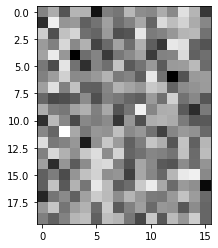

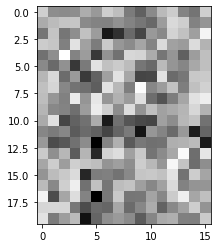

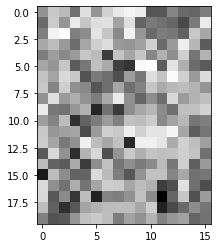

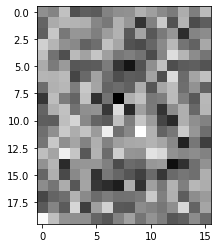

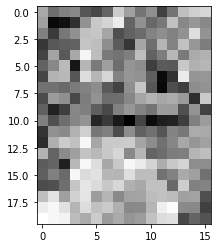

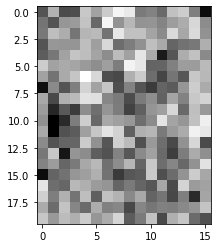

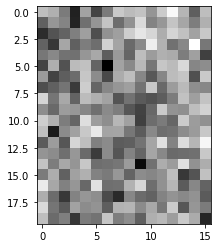

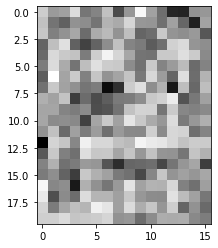

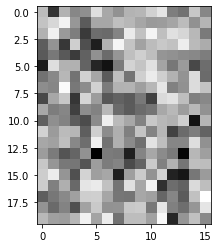

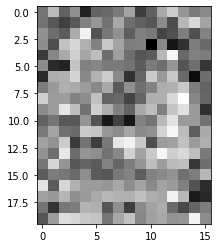

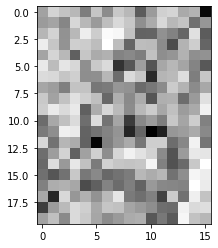

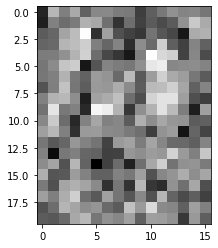

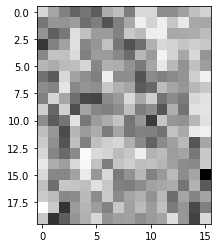

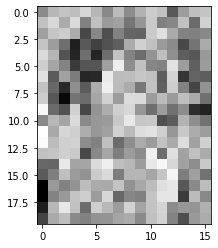

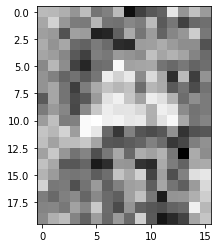

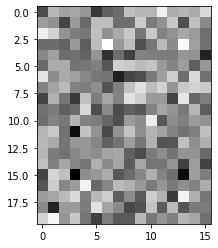

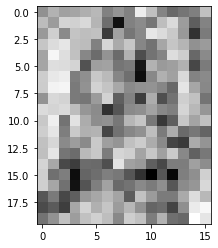

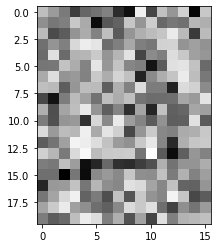

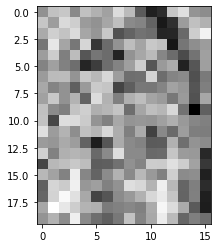

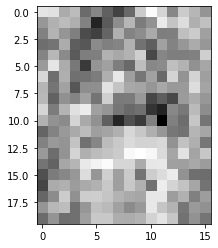

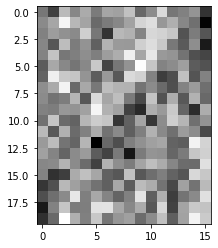

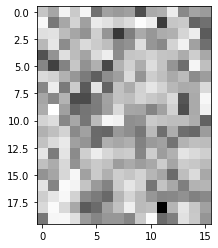

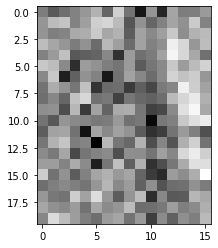

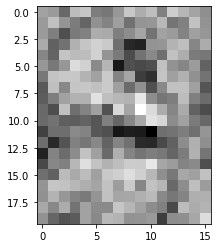

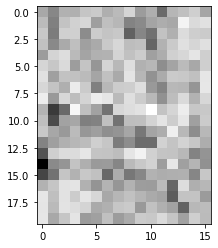

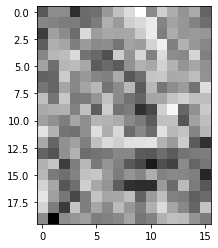

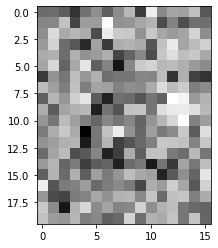

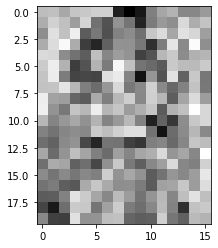

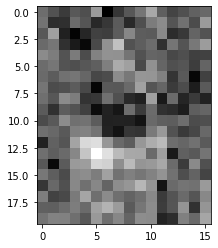

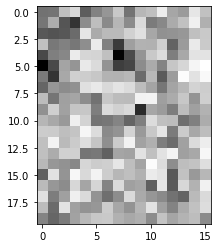

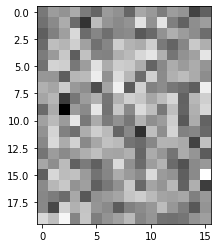

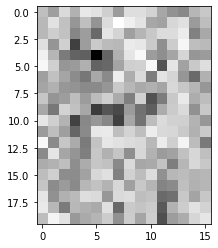

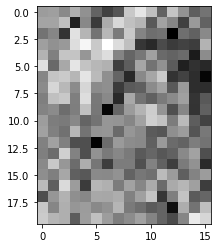

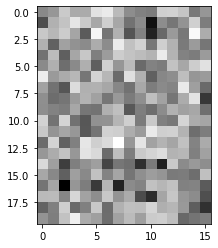

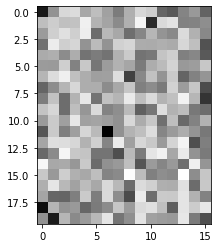

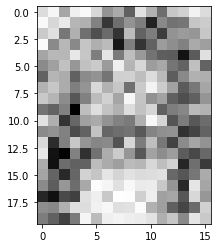

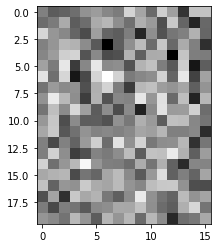

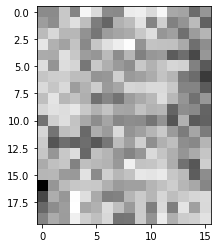

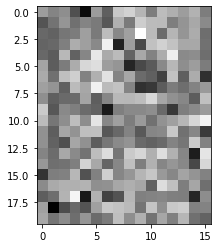

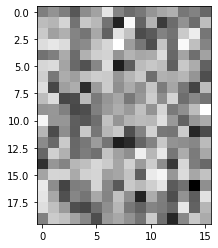

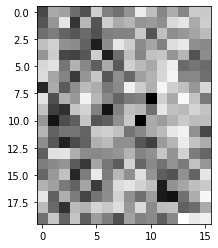

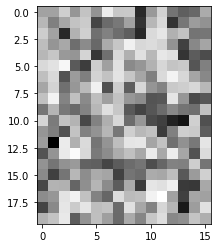

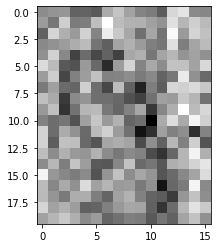

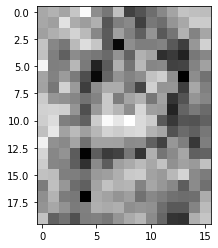

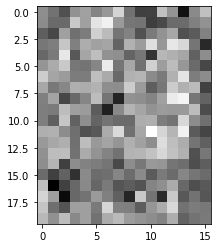

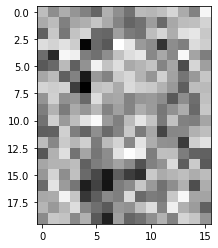

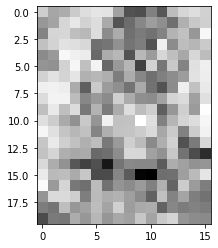

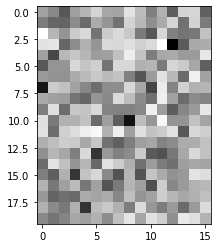

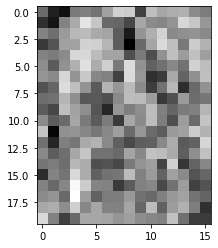

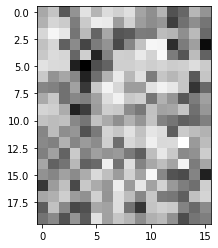

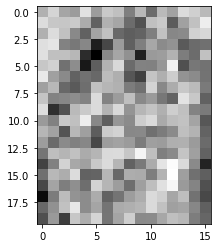

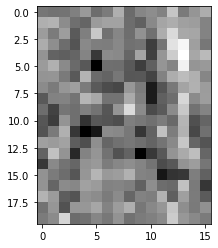

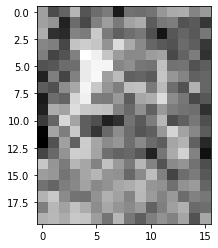

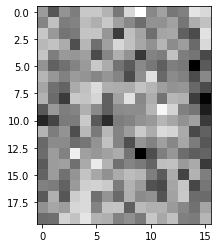

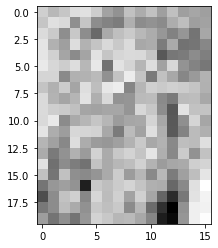

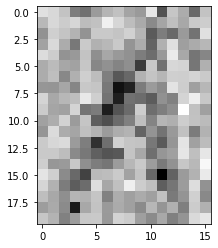

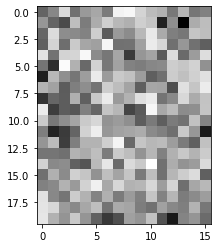

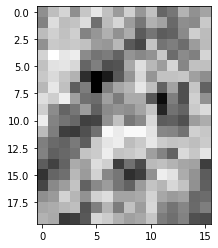

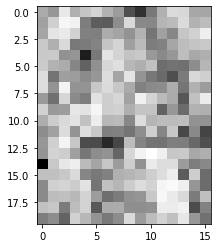

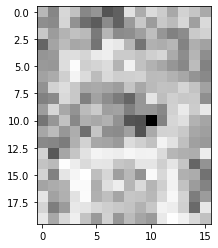

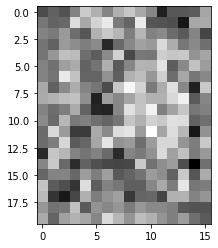

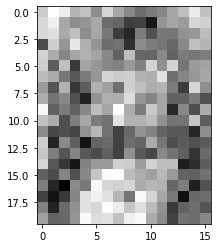

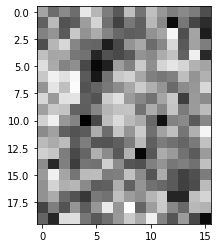

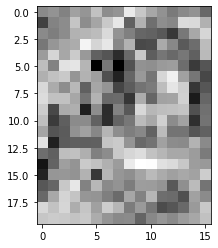

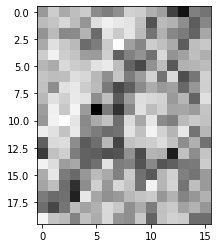

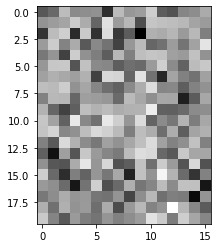

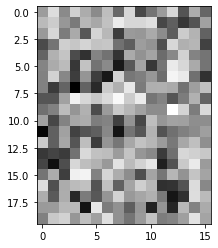

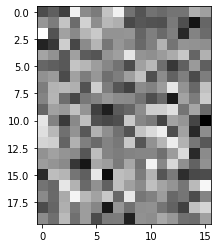

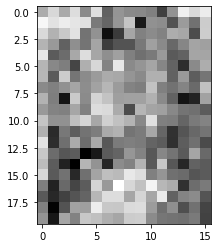

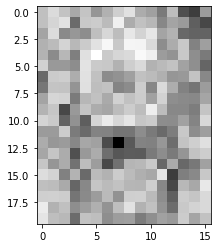

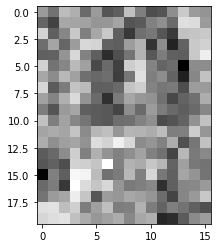

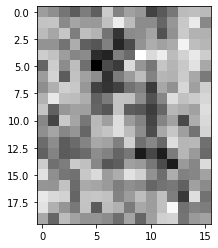

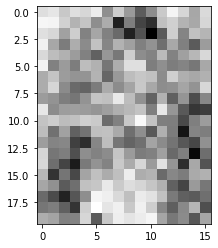

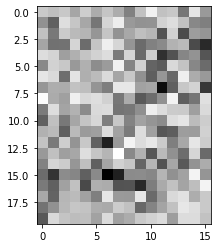

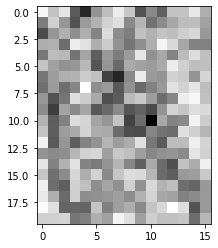

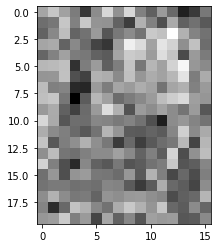

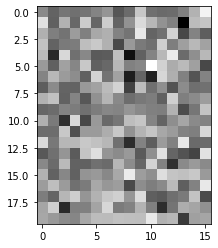

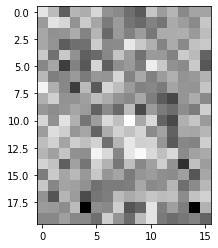

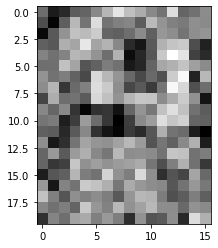

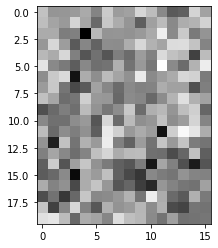

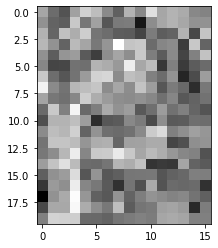

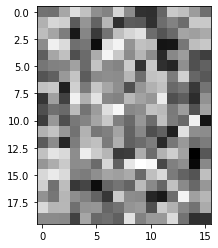

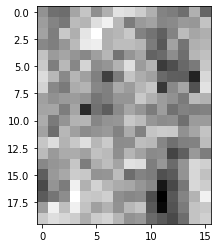

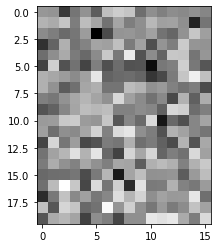

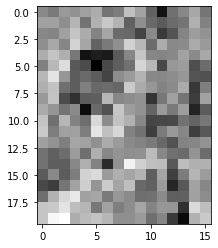

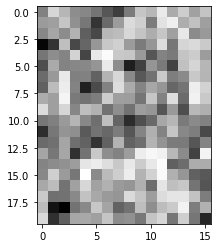

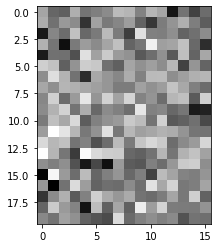

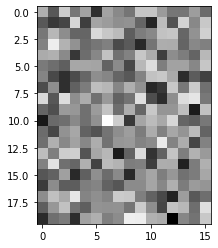

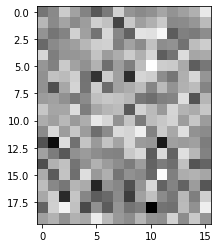

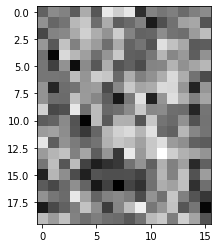

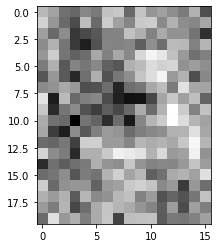

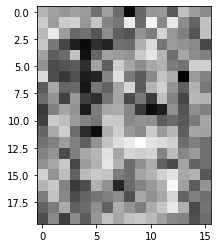

In [19]:
for idx in range(my_rbm.W.shape[1]):
  weights = my_rbm.W[:,idx]
  filter = weights.reshape(20, 16)
  plt.imshow(filter, cmap='Greys')
  plt.show()

# MNIST

In [20]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print("Original dimensions train_X: {}".format(train_X.shape))
print("Original dimensions test_X: {}\n".format(test_X.shape))
print("Original dimensions train_y: {}".format(train_y.shape))
print("Original dimensions train_y: {}".format(test_y.shape))


N_train = train_X.shape[0]
N_test = test_X.shape[0]
size = train_X.shape[1]*train_X.shape[2]

train_X = train_X.reshape(N_train, size)
test_X = test_X.reshape(N_test, size)
print("Flattened dimensions train_X: {}".format(train_X.shape))
print("Flattened dimensions test_X: {}\n".format(test_X.shape))

thresh = 50
X = np.vstack((train_X, test_X))
X = (X>thresh).astype(int) 
y = np.hstack((train_y, test_y))
print("Full flattened dataset dimensions: {}".format(X.shape))
print("Full label set dimensions: {}".format(y.shape))

11501568/11490434 [==============================] - 0s 0us/step
Original dimensions train_X: (60000, 28, 28)
Original dimensions test_X: (10000, 28, 28)

Original dimensions train_y: (60000,)
Original dimensions train_y: (10000,)
Flattened dimensions train_X: (60000, 784)
Flattened dimensions test_X: (10000, 784)

Full flattened dataset dimensions: (70000, 784)
Full label set dimensions: (70000,)


In [21]:
def select_digits(X, y, digits):
    mask = np.zeros(y.shape)
    for label in digits:
        mask = np.logical_or(mask, y == label)
    return X[mask], y[mask]

0 samples with label 0
0 samples with label 1
0 samples with label 2
7141 samples with label 3
0 samples with label 4
0 samples with label 5
0 samples with label 6
0 samples with label 7
6825 samples with label 8
0 samples with label 9


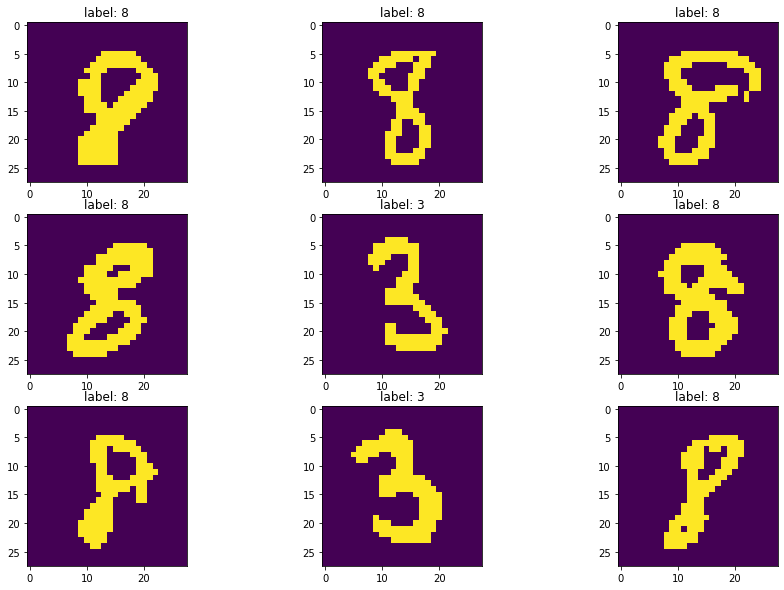

In [22]:
N_train = 70000
X_selected, y_selected = select_digits(X, y, [8,3])
X_train_rbm = X_selected[:N_train]
y_train_rbm = y_selected[:N_train]

for digit in range(10):
    print('{} samples with label {}'.format(sum(y_train_rbm == digit), digit))
n, _ = X_train_rbm.shape
nrow = 3
ncol = nrow

fig, axs = plt.subplots(nrow, ncol, figsize=(15,10))
for i in range(nrow*ncol):
    ax = axs[i//ncol,i%ncol]
    rand_idx = np.random.randint(n)
    rand_sample = X_train_rbm[rand_idx]
    rand_sample = rand_sample.reshape(28,28)
    ax.imshow(rand_sample)
    ax.set_title('label: {}'.format(y_train_rbm[rand_idx]))
    
fig.show()


##### Epoch: 0/100 #####
>>> samples 12289/13966 [88%]

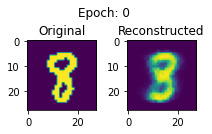


>>> MSE: 0.0633948448729546

##### Epoch: 1/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.050130356125794195

##### Epoch: 2/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.047174766101897615

##### Epoch: 3/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04341576239019375

##### Epoch: 4/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04201518195393356

##### Epoch: 5/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.04004100823715812

##### Epoch: 6/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03918010439058451

##### Epoch: 7/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.036297612351080956

##### Epoch: 8/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03526551889649536

##### Epoch: 9/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.033457032911555384

##### Epoch: 10/100 #####
>>> samples 12289/13966 [88%]

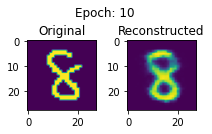


>>> MSE: 0.033283158889342045

##### Epoch: 11/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03168584721476503

##### Epoch: 12/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.03125141632972818

##### Epoch: 13/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.030434760085245482

##### Epoch: 14/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.029818845793820915

##### Epoch: 15/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.029240209594211915

##### Epoch: 16/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.028698613309773524

##### Epoch: 17/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.028068647110727204

##### Epoch: 18/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02800249940471107

##### Epoch: 19/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.027220853572750368

##### Epoch: 20/100 #####
>>> samples 12289/13966 [88%]

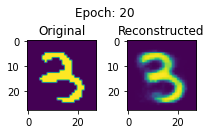


>>> MSE: 0.026919500436317054

##### Epoch: 21/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.026560616052726194

##### Epoch: 22/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02608969251296107

##### Epoch: 23/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02579556975274732

##### Epoch: 24/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025525649496301882

##### Epoch: 25/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025233813917357125

##### Epoch: 26/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.025022587353508867

##### Epoch: 27/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.024597068529732962

##### Epoch: 28/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02448091042263036

##### Epoch: 29/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.024141519419634695

##### Epoch: 30/100 #####
>>> samples 12289/13966 [88%]

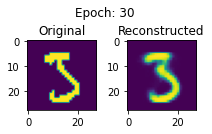


>>> MSE: 0.02397279746675838

##### Epoch: 31/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02377422034263727

##### Epoch: 32/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.023486168965128076

##### Epoch: 33/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02324633552651328

##### Epoch: 34/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.023173679864558004

##### Epoch: 35/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022964583528159176

##### Epoch: 36/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02265318432988843

##### Epoch: 37/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022543610945711515

##### Epoch: 38/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02236645951486004

##### Epoch: 39/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.022251046157940116

##### Epoch: 40/100 #####
>>> samples 12289/13966 [88%]

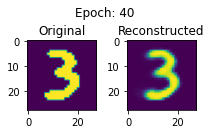


>>> MSE: 0.021950323103627305

##### Epoch: 41/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021903933985121582

##### Epoch: 42/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02180282214419974

##### Epoch: 43/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02161298720397346

##### Epoch: 44/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021426587016119148

##### Epoch: 45/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021348417993953175

##### Epoch: 46/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021230858940174256

##### Epoch: 47/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.021058575924685213

##### Epoch: 48/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02094914819042762

##### Epoch: 49/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020787297667053017

##### Epoch: 50/100 #####
>>> samples 12289/13966 [88%]

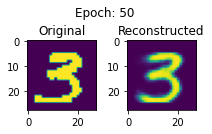


>>> MSE: 0.02071378326761321

##### Epoch: 51/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020612157789584966

##### Epoch: 52/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020499504553100477

##### Epoch: 53/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02042763757243525

##### Epoch: 54/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.020214695406702347

##### Epoch: 55/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.0201206070331481

##### Epoch: 56/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.02004411633491246

##### Epoch: 57/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01999916636990224

##### Epoch: 58/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01980663794172628

##### Epoch: 59/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019793868964260306

##### Epoch: 60/100 #####
>>> samples 12289/13966 [88%]

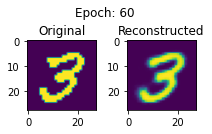


>>> MSE: 0.0196612500692324

##### Epoch: 61/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019583629996976753

##### Epoch: 62/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01944066833387133

##### Epoch: 63/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019390103223172177

##### Epoch: 64/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01927913097518325

##### Epoch: 65/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01921340554658951

##### Epoch: 66/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.019167086032893514

##### Epoch: 67/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01903259390762499

##### Epoch: 68/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018960512357846793

##### Epoch: 69/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01891034423352122

##### Epoch: 70/100 #####
>>> samples 12289/13966 [88%]

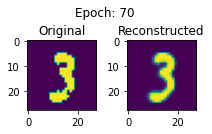


>>> MSE: 0.018804123357226633

##### Epoch: 71/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018752872950548897

##### Epoch: 72/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018650258664967494

##### Epoch: 73/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018597684415859173

##### Epoch: 74/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01849931061119434

##### Epoch: 75/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01839543131218575

##### Epoch: 76/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018403038373193143

##### Epoch: 77/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018279645624528232

##### Epoch: 78/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018142770321169416

##### Epoch: 79/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.018163918248543375

##### Epoch: 80/100 #####
>>> samples 12289/13966 [88%]

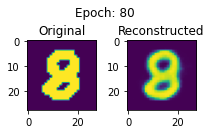


>>> MSE: 0.01807892141645782

##### Epoch: 81/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017988513319339063

##### Epoch: 82/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017936732932650874

##### Epoch: 83/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01786909095595419

##### Epoch: 84/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01780655742699315

##### Epoch: 85/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017744346047927205

##### Epoch: 86/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017725526921462308

##### Epoch: 87/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01763449969216099

##### Epoch: 88/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017542005707816777

##### Epoch: 89/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017524393062494762

##### Epoch: 90/100 #####
>>> samples 12289/13966 [88%]

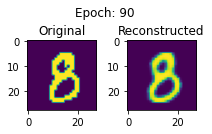


>>> MSE: 0.01745248631622137

##### Epoch: 91/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01740178752577249

##### Epoch: 92/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017317837788155765

##### Epoch: 93/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017269213483983813

##### Epoch: 94/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017215901243368265

##### Epoch: 95/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017164977704860546

##### Epoch: 96/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.017121959673565536

##### Epoch: 97/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01704195622657527

##### Epoch: 98/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.01698355259805995

##### Epoch: 99/100 #####
>>> samples 12289/13966 [88%]
>>> MSE: 0.016927439958901863


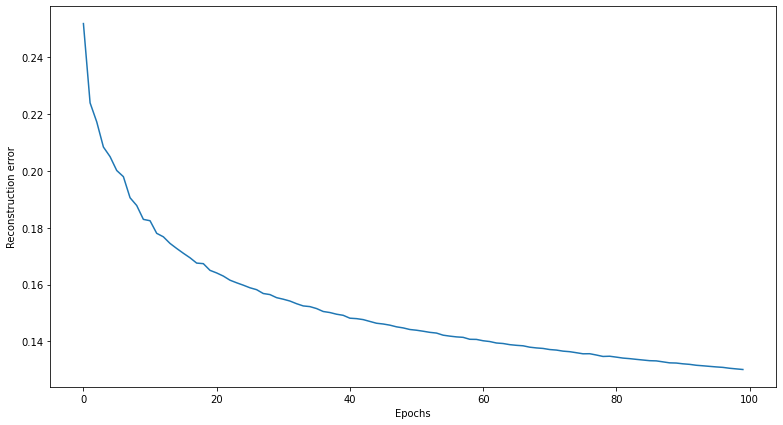

In [23]:
_, p = X_train_rbm.shape

my_rbm = RBM(p, q=512)
err_history = my_rbm.train(X_train_rbm, nb_epoch=100, batch_size=2048, lr=1e-1, 
                           height=28, width=28, epoch_per_plot=10)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

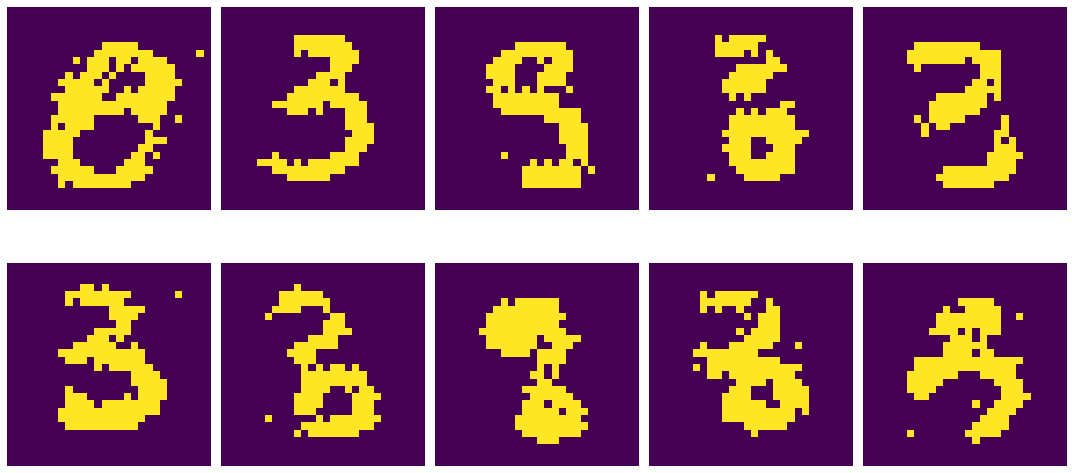

In [24]:
my_rbm.generate(nb_iter=1000, thresh=.2, height=28, width=28)


##### Epoch: 0/100 #####
>>> samples 12289/14017 [88%]

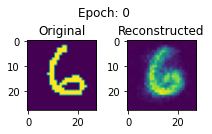


>>> MSE: 0.05456808758950746

##### Epoch: 1/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.04697631417527777

##### Epoch: 2/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.04404608630051342

##### Epoch: 3/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.04005439816294452

##### Epoch: 4/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.038471040568774775

##### Epoch: 5/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03647349990282611

##### Epoch: 6/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.035193896346495605

##### Epoch: 7/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03409337273405197

##### Epoch: 8/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03292500652856896

##### Epoch: 9/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.03191356413461428

##### Epoch: 10/100 #####
>>> samples 12289/14017 [88%]

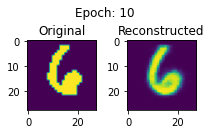


>>> MSE: 0.031204176404389165

##### Epoch: 11/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.030379363420722102

##### Epoch: 12/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02966230817028133

##### Epoch: 13/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.029180291329254343

##### Epoch: 14/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0286057492121968

##### Epoch: 15/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02796667810890865

##### Epoch: 16/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.027534894002318268

##### Epoch: 17/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.027067186863456667

##### Epoch: 18/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.026635379659467766

##### Epoch: 19/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.026304601374674632

##### Epoch: 20/100 #####
>>> samples 12289/14017 [88%]

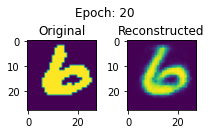


>>> MSE: 0.02596749508901813

##### Epoch: 21/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.025624055815722843

##### Epoch: 22/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.025341050534888786

##### Epoch: 23/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.024949074188636847

##### Epoch: 24/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.024784546624773012

##### Epoch: 25/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.024410231742213104

##### Epoch: 26/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.024194278147499915

##### Epoch: 27/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.023971632558317166

##### Epoch: 28/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02371090851429581

##### Epoch: 29/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.023477737887835814

##### Epoch: 30/100 #####
>>> samples 12289/14017 [88%]

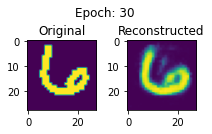


>>> MSE: 0.02328763852704189

##### Epoch: 31/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.023089355634632894

##### Epoch: 32/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.022831281412917053

##### Epoch: 33/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.022690204815010124

##### Epoch: 34/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02254097837107492

##### Epoch: 35/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02233658038899127

##### Epoch: 36/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.022152053238335013

##### Epoch: 37/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021996922023230756

##### Epoch: 38/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02189396977842329

##### Epoch: 39/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021689370707394198

##### Epoch: 40/100 #####
>>> samples 12289/14017 [88%]

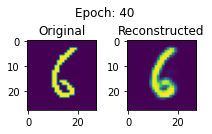


>>> MSE: 0.0215297599396203

##### Epoch: 41/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021421244884412362

##### Epoch: 42/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021224083629246163

##### Epoch: 43/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.021100108286402287

##### Epoch: 44/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020978079782358668

##### Epoch: 45/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02085255362131542

##### Epoch: 46/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020705100774199223

##### Epoch: 47/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.02059640237501202

##### Epoch: 48/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020472467739771884

##### Epoch: 49/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020372424438072936

##### Epoch: 50/100 #####
>>> samples 12289/14017 [88%]

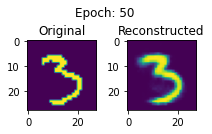


>>> MSE: 0.020255096917166416

##### Epoch: 51/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.020120869354629204

##### Epoch: 52/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01999158418317226

##### Epoch: 53/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01990226430541859

##### Epoch: 54/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019816687237002396

##### Epoch: 55/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01970757432611431

##### Epoch: 56/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019618415742321958

##### Epoch: 57/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019499341106966415

##### Epoch: 58/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019379482602642793

##### Epoch: 59/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01931304797878082

##### Epoch: 60/100 #####
>>> samples 12289/14017 [88%]

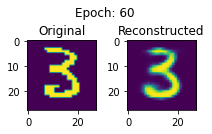


>>> MSE: 0.019202118120239444

##### Epoch: 61/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019126867170222477

##### Epoch: 62/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.019050965780535212

##### Epoch: 63/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018946435604913922

##### Epoch: 64/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018893107065625657

##### Epoch: 65/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018774723024870897

##### Epoch: 66/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01871959698819749

##### Epoch: 67/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018617329532397506

##### Epoch: 68/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018548036399267033

##### Epoch: 69/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01848073039839176

##### Epoch: 70/100 #####
>>> samples 12289/14017 [88%]

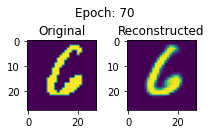


>>> MSE: 0.018363978087533872

##### Epoch: 71/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01830868726211917

##### Epoch: 72/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018239320449715435

##### Epoch: 73/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018140415025950662

##### Epoch: 74/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018026591946492608

##### Epoch: 75/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.018000272905202237

##### Epoch: 76/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017945676234899878

##### Epoch: 77/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017884394257321853

##### Epoch: 78/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017788674835450345

##### Epoch: 79/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017724366779409705

##### Epoch: 80/100 #####
>>> samples 12289/14017 [88%]

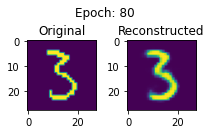


>>> MSE: 0.01765143735943598

##### Epoch: 81/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017571323836169977

##### Epoch: 82/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017530574596528313

##### Epoch: 83/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017462248025657504

##### Epoch: 84/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017374475481636974

##### Epoch: 85/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01734805881794707

##### Epoch: 86/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017268760378802553

##### Epoch: 87/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.017258759204386714

##### Epoch: 88/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01716612513474276

##### Epoch: 89/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01712870027359404

##### Epoch: 90/100 #####
>>> samples 12289/14017 [88%]

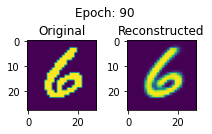


>>> MSE: 0.017037906574771212

##### Epoch: 91/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0170014426409359

##### Epoch: 92/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01693811833686908

##### Epoch: 93/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016880643076663367

##### Epoch: 94/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016805271781218514

##### Epoch: 95/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016770839674635368

##### Epoch: 96/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016735050876424247

##### Epoch: 97/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.01664285575082562

##### Epoch: 98/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.016586666680731138

##### Epoch: 99/100 #####
>>> samples 12289/14017 [88%]
>>> MSE: 0.0165622736908508


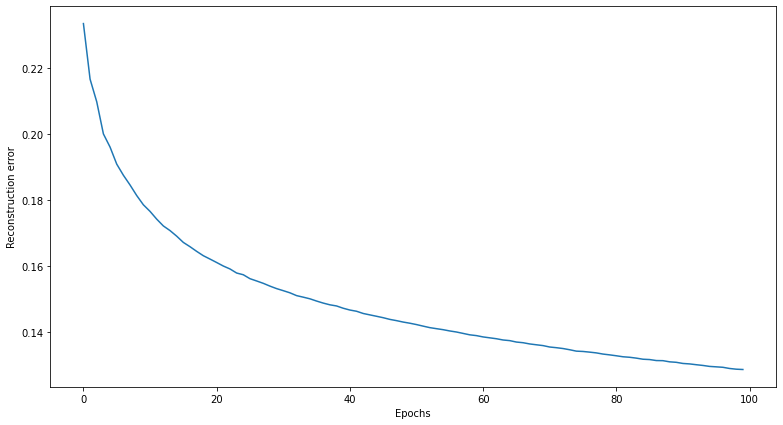

In [25]:
N_train = 70000
X_selected, y_selected = select_digits(X, y, [3,6])
X_train_rbm = X_selected[:N_train]
y_train_rbm = y_selected[:N_train]

_, p = X_train_rbm.shape

my_rbm2 = RBM(p, q=512)
err_history = my_rbm2.train(X_train_rbm, nb_epoch=100, batch_size=2048, lr=1e-1, 
                           height=28, width=28, epoch_per_plot=10)

plt.figure(figsize=(13,7))
plt.plot(np.arange(0, len(err_history)), np.sqrt(err_history))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

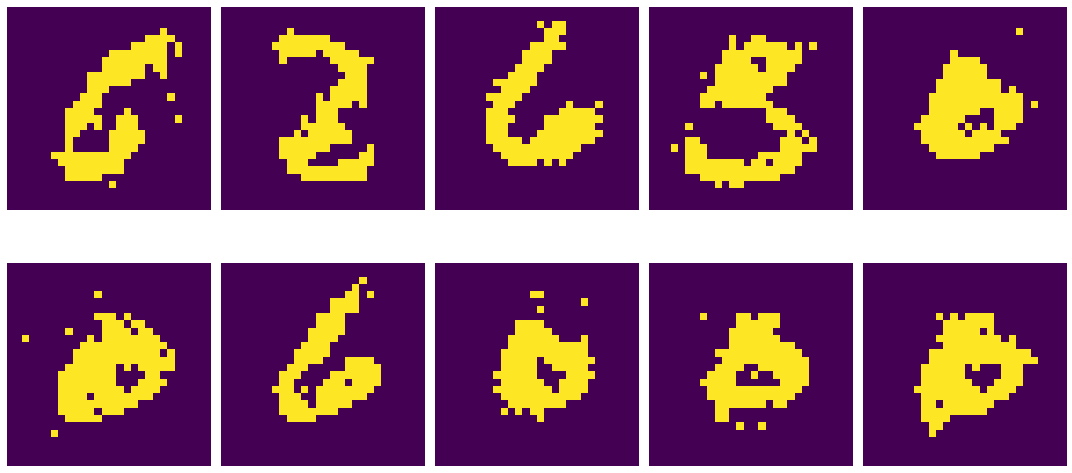

In [26]:
my_rbm2.generate(nb_iter=1000, thresh=.5, height=28, width=28)

# DBN

320


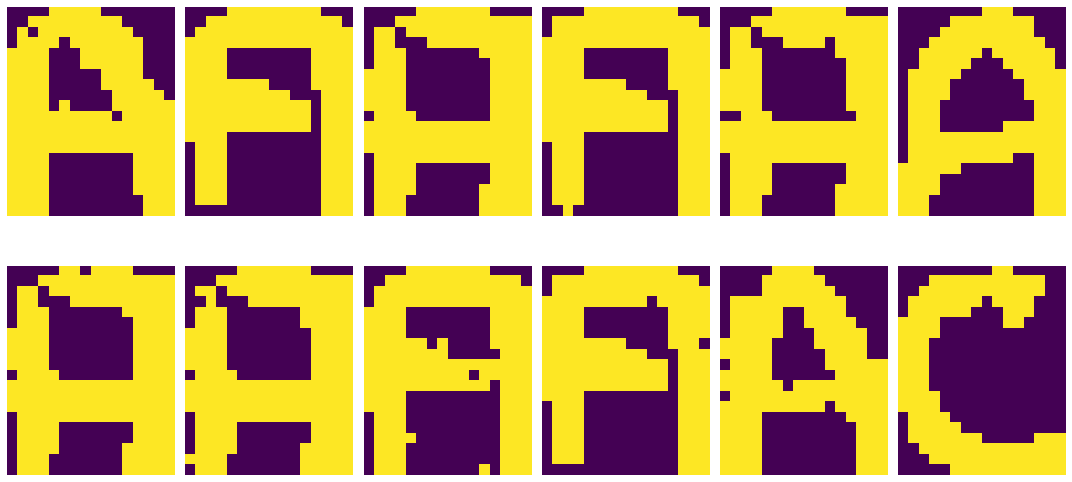

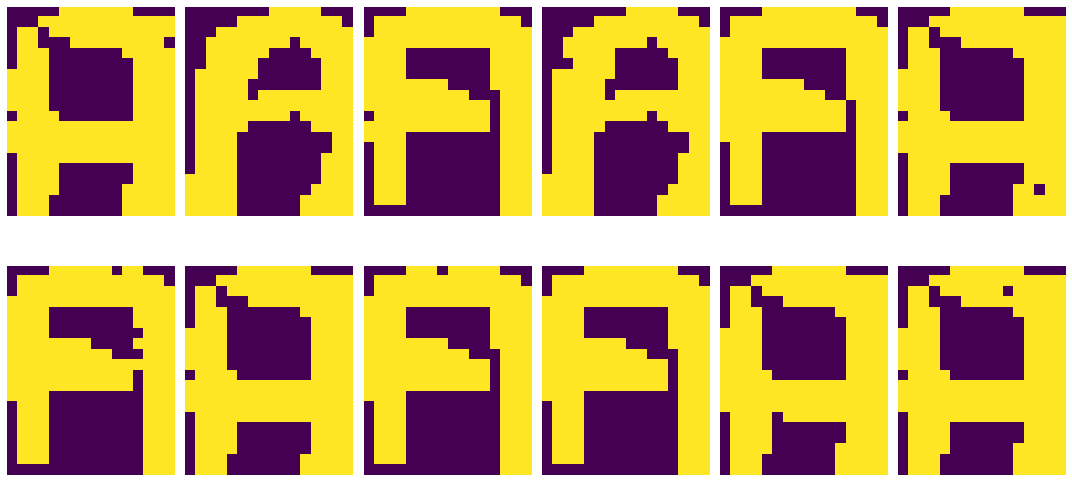

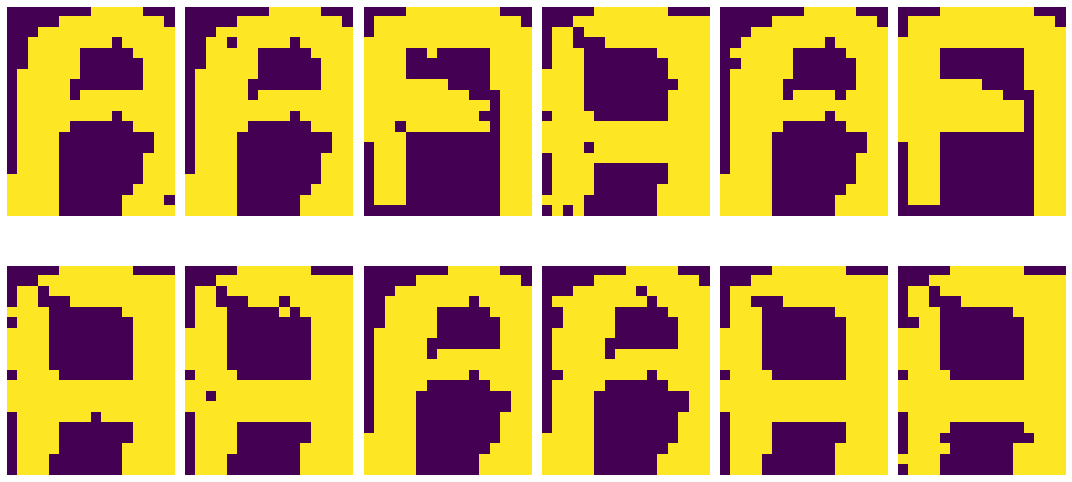

In [42]:
class DBM():
  def __init__(self, sizeRBMs, var=1e-2):
    self.L = len(sizeRBMs)-1
    self.layers = [RBM(sizeRBMs[i], sizeRBMs[i+1], var) for i in range(self.L)]
  
  def pretrain(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=False):
    for l in range(self.L):
      _ = self.layers[l].train(X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=verbose)
      X = self.layers[l].entree_sortie(X)
  
  def entree_sortie(self, X):
    H = X
    for l in range(self.L):
          H = self.layers[l].entree_sortie(H)
    return H

  def sortie_entree(self, H):
    X = H
    for l in range(self.L):
          X = self.layers[self.L-l-1].sortie_entree(H)
    return X


  def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
    p, _ = self.layers[0].W.shape
    _, q = self.layers[-1].W.shape
    nb_images = nrow*ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=(15,8))

    for i in range(nb_images):
      v = (np.random.random(p) < thresh).astype(int)
      for j in range(nb_iter):
        ph_v = self.entree_sortie(v) 
        h = (np.random.random(q) < ph_v).astype(int)
        pv_h = self.sortie_entree(h)
        v = (np.random.random(p) < pv_h).astype(int)

      image = v.reshape(height,width)
      axs[i//ncol, i%ncol].imshow(image)
      axs[i//ncol, i%ncol].axis('off')
    plt.tight_layout()
    plt.show()

X = lire_alpha_digit('binaryalphadigs.mat', 'AC')
_, p = X.shape

my_dbm = DBM([p, 100, 500, 256])
my_dbm.pretrain(X, nb_epoch=10, lr=1e-1, epoch_per_plot=1)

for _ in range(3):
  my_rbm.generate(nb_iter=10, thresh=0.5, ncol=6, nrow=2)
